Connected to cryopinn (Python 3.11.4)

In [1]:
import sys

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import deepxde as dde
from deepxde.backend import tf
def get_data(filename):
    nx = 40
    nt = 40
    data = np.load(filename)
    x = data["x"].astype(np.float32)
    t = data["t"].astype(np.float32)
    u = data["u"].astype(np.float32)  # N x nt x nx
    u0 = u[:, 0, :]  # N x nx
    xt = np.vstack((np.ravel(x), np.ravel(t))).T
    u = u.reshape(-1, nt * nx)
    return (u0, xt), u

2023-08-23 12:00:35.656676: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 12:01:24.132194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Enable just-in-time compilation with XLA.



In [3]:
def main():
    nt = 40
    nx = 40
    x_train, y_train = get_data("train_IC2.npz")
    x_test, y_test = get_data("test_IC2.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512], [2, 512, 512, 512], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    # IC1
    # losshistory, train_state = model.train(epochs=100000, batch_size=None)
    # IC2
    losshistory, train_state = model.train(epochs=250000, batch_size=None)
    y_pred = model.predict(data.test_x)
    np.savetxt("y_pred_deeponet.dat", y_pred[0].reshape(nt, nx))
    np.savetxt("y_true_deeponet.dat", data.test_y[0].reshape(nt, nx))
    np.savetxt("y_error_deeponet.dat", (y_pred[0] - data.test_y[0]).reshape(nt, nx))

if __name__ == "__main__":
    main()

FileNotFoundError: [Errno 2] No such file or directory: 'train_IC2.npz'

In [4]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from advection import Advection, Advection_v2
def main_IC1():
    ndata = 1000
    nx = 40
    nt = 40
    geom = dde.geometry.Interval(0, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)
    x = geomtime.uniform_points(nx * nt, boundary=True)
    u = []
    rng = np.random.default_rng()
    for i in range(ndata):
        height = rng.random() + 1  # [1, 2]
        width = 0.3 * rng.random() + 0.3  # [0.3, 0.6]
        x0 = 0.4 * rng.random() + 0.3  # [0.3, 0.7]
        pde = Advection(height, width, 1, x0, 0, 1)
        u.append(pde.solve(x).reshape(nt, nx))
    u = np.array(u)
    x, t = x[:, 0].reshape(nt, nx), x[:, 1].reshape(nt, nx)
    np.savez_compressed("train.npz", x=x, t=t, u=u)
    # for i in range(3):
    #     plt.figure()
    #     plt.imshow(u[i])
    #     plt.colorbar()
    # plt.show()

def main_IC2():
    ndata = 1000
    nx = 40
    nt = 40
    geom = dde.geometry.Interval(0, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)
    x = geomtime.uniform_points(nx * nt, boundary=True)
    u = []
    rng = np.random.default_rng()
    for i in range(ndata):
        c1 = 0.1 * rng.random() + 0.2  # [0.2, 0.3]
        w = 0.1 * rng.random() + 0.1  # [0.1, 0.2]
        h1 = 1.5 * rng.random() + 0.5  # [0.5, 2]
        c2 = 0.1 * rng.random() + 0.7  # [0.7, 0.8]
        a = 5 * rng.random() + 5  # 1 / [0.1, 0.2] = [5, 10]
        h2 = 1.5 * rng.random() + 0.5  # [0.5, 2]
        pde = Advection_v2(0, 1, c1, w, h1, c2, a, h2)
        u.append(pde.solve(x).reshape(nt, nx))
    u = np.array(u)
    x, t = x[:, 0].reshape(nt, nx), x[:, 1].reshape(nt, nx)
    np.savez_compressed("train_IC2.npz", x=x, t=t, u=u)
    for i in range(3):
        plt.figure()
        plt.imshow(u[i])
        plt.colorbar()
    plt.show()

if __name__ == "__main__":
    # main_IC1()
    main_IC2()

ModuleNotFoundError: No module named 'advection'

In [5]:
import numpy as np
class Advection:
    def __init__(self, height, width, c, xm, xa, xb):
        """PBC"""
        self.h = height  # height
        self.w = width  # width
        self.xm = xm  # center location
        self.c = c  # velocity
        self.xa = xa  # Left domain point
        self.xb = xb  # right domain point
    def solve(self, X):
        x = X[:, 0:1]
        t = X[:, 1:2]
        n = np.shape(x)[0]
        u = np.zeros_like(x)
        h = self.h
        w = self.w
        c = self.c
        xm = self.xm
        xa = self.xa
        xb = self.xb
        for i in range(n):
            na = (xm - w / 2.0 + c * t[i, 0] - xa) // (xb - xa)
            nb = (xm + w / 2.0 + c * t[i, 0] - xa) // (xb - xa)
            xl = xa + (xm - w / 2.0 + c * t[i, 0] - xa) - na * (xb - xa)
            xr = xa + (xm + w / 2.0 + c * t[i, 0] - xa) - nb * (xb - xa)
            if xl < xr:
                if x[i, 0] >= xl and x[i, 0] <= xr:
                    u[i, 0] = h
                else:
                    u[i, 0] = 0.0
            else:
                if x[i, 0] >= xl or x[i, 0] <= xr:
                    u[i, 0] = h
                else:
                    u[i, 0] = 0.0
        # for i in range(n):
        #    if (x[i,0]-c*t[i,0]>=xm-w/2.0 and x[i,0]-c*t[i,0]<=xm+w/2.0):
        #        u[i,0] = h
        #    else:
        #        u[i,0] = 0.0
        return u

class Advection_v2:
    def __init__(self, x0, x1, c1, w, h1, c2, a, h2):
        self.x0 = x0
        self.x1 = x1
        self.c1 = c1
        self.w = w
        self.h1 = h1
        self.c2 = c2
        self.a = a
        self.h2 = h2
    def solve(self, X):
        x = X[:, 0:1] - X[:, 1:2]
        dx = x - self.x0
        n = dx // (self.x1 - self.x0)
        x -= n * (self.x1 - self.x0)
        xl = self.c1 - self.w / 2
        xr = self.c1 + self.w / 2
        u1 = self.h1 * np.heaviside(x - xl, 0.5) * np.heaviside(xr - x, 0.5)
        u2 = np.sqrt(np.maximum(self.h2 ** 2 - self.a ** 2 * (x - self.c2) ** 2, 0))
        return u1 + u2

In [6]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from advection import Advection, Advection_v2
def main_IC1():
    ndata = 1000
    nx = 40
    nt = 40
    geom = dde.geometry.Interval(0, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)
    x = geomtime.uniform_points(nx * nt, boundary=True)
    u = []
    rng = np.random.default_rng()
    for i in range(ndata):
        height = rng.random() + 1  # [1, 2]
        width = 0.3 * rng.random() + 0.3  # [0.3, 0.6]
        x0 = 0.4 * rng.random() + 0.3  # [0.3, 0.7]
        pde = Advection(height, width, 1, x0, 0, 1)
        u.append(pde.solve(x).reshape(nt, nx))
    u = np.array(u)
    x, t = x[:, 0].reshape(nt, nx), x[:, 1].reshape(nt, nx)
    np.savez_compressed("train.npz", x=x, t=t, u=u)
    # for i in range(3):
    #     plt.figure()
    #     plt.imshow(u[i])
    #     plt.colorbar()
    # plt.show()

def main_IC2():
    ndata = 1000
    nx = 40
    nt = 40
    geom = dde.geometry.Interval(0, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)
    x = geomtime.uniform_points(nx * nt, boundary=True)
    u = []
    rng = np.random.default_rng()
    for i in range(ndata):
        c1 = 0.1 * rng.random() + 0.2  # [0.2, 0.3]
        w = 0.1 * rng.random() + 0.1  # [0.1, 0.2]
        h1 = 1.5 * rng.random() + 0.5  # [0.5, 2]
        c2 = 0.1 * rng.random() + 0.7  # [0.7, 0.8]
        a = 5 * rng.random() + 5  # 1 / [0.1, 0.2] = [5, 10]
        h2 = 1.5 * rng.random() + 0.5  # [0.5, 2]
        pde = Advection_v2(0, 1, c1, w, h1, c2, a, h2)
        u.append(pde.solve(x).reshape(nt, nx))
    u = np.array(u)
    x, t = x[:, 0].reshape(nt, nx), x[:, 1].reshape(nt, nx)
    np.savez_compressed("train_IC2.npz", x=x, t=t, u=u)
    for i in range(3):
        plt.figure()
        plt.imshow(u[i])
        plt.colorbar()
    plt.show()

if __name__ == "__main__":
    # main_IC1()
    main_IC2()

ModuleNotFoundError: No module named 'advection'

In [7]:
from .advection import Advection, Advection_v2

ImportError: attempted relative import with no known parent package

In [8]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

In [9]:
class Advection:
    def __init__(self, height, width, c, xm, xa, xb):
        """PBC"""
        self.h = height  # height
        self.w = width  # width
        self.xm = xm  # center location
        self.c = c  # velocity
        self.xa = xa  # Left domain point
        self.xb = xb  # right domain point
    def solve(self, X):
        x = X[:, 0:1]
        t = X[:, 1:2]
        n = np.shape(x)[0]
        u = np.zeros_like(x)
        h = self.h
        w = self.w
        c = self.c
        xm = self.xm
        xa = self.xa
        xb = self.xb
        for i in range(n):
            na = (xm - w / 2.0 + c * t[i, 0] - xa) // (xb - xa)
            nb = (xm + w / 2.0 + c * t[i, 0] - xa) // (xb - xa)
            xl = xa + (xm - w / 2.0 + c * t[i, 0] - xa) - na * (xb - xa)
            xr = xa + (xm + w / 2.0 + c * t[i, 0] - xa) - nb * (xb - xa)
            if xl < xr:
                if x[i, 0] >= xl and x[i, 0] <= xr:
                    u[i, 0] = h
                else:
                    u[i, 0] = 0.0
            else:
                if x[i, 0] >= xl or x[i, 0] <= xr:
                    u[i, 0] = h
                else:
                    u[i, 0] = 0.0
        # for i in range(n):
        #    if (x[i,0]-c*t[i,0]>=xm-w/2.0 and x[i,0]-c*t[i,0]<=xm+w/2.0):
        #        u[i,0] = h
        #    else:
        #        u[i,0] = 0.0
        return u

class Advection_v2:
    def __init__(self, x0, x1, c1, w, h1, c2, a, h2):
        self.x0 = x0
        self.x1 = x1
        self.c1 = c1
        self.w = w
        self.h1 = h1
        self.c2 = c2
        self.a = a
        self.h2 = h2
    def solve(self, X):
        x = X[:, 0:1] - X[:, 1:2]
        dx = x - self.x0
        n = dx // (self.x1 - self.x0)
        x -= n * (self.x1 - self.x0)
        xl = self.c1 - self.w / 2
        xr = self.c1 + self.w / 2
        u1 = self.h1 * np.heaviside(x - xl, 0.5) * np.heaviside(xr - x, 0.5)
        u2 = np.sqrt(np.maximum(self.h2 ** 2 - self.a ** 2 * (x - self.c2) ** 2, 0))
        return u1 + u2

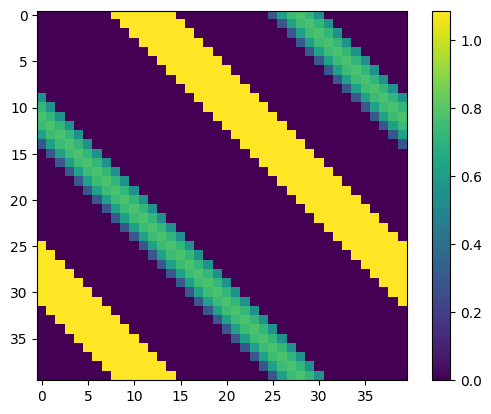

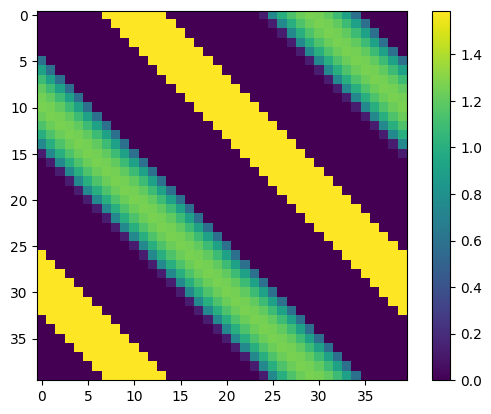

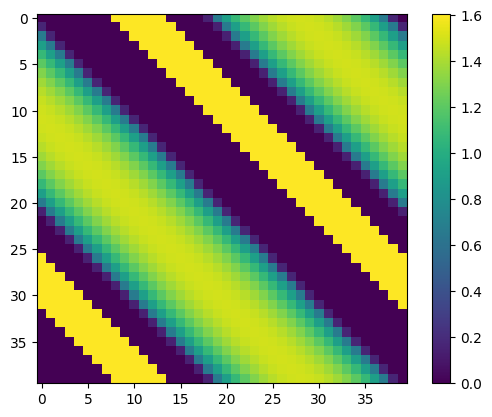

In [10]:
def main_IC1():
    ndata = 1000
    nx = 40
    nt = 40
    geom = dde.geometry.Interval(0, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)
    x = geomtime.uniform_points(nx * nt, boundary=True)
    u = []
    rng = np.random.default_rng()
    for i in range(ndata):
        height = rng.random() + 1  # [1, 2]
        width = 0.3 * rng.random() + 0.3  # [0.3, 0.6]
        x0 = 0.4 * rng.random() + 0.3  # [0.3, 0.7]
        pde = Advection(height, width, 1, x0, 0, 1)
        u.append(pde.solve(x).reshape(nt, nx))
    u = np.array(u)
    x, t = x[:, 0].reshape(nt, nx), x[:, 1].reshape(nt, nx)
    np.savez_compressed("train.npz", x=x, t=t, u=u)
    # for i in range(3):
    #     plt.figure()
    #     plt.imshow(u[i])
    #     plt.colorbar()
    # plt.show()

def main_IC2():
    ndata = 1000
    nx = 40
    nt = 40
    geom = dde.geometry.Interval(0, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)
    x = geomtime.uniform_points(nx * nt, boundary=True)
    u = []
    rng = np.random.default_rng()
    for i in range(ndata):
        c1 = 0.1 * rng.random() + 0.2  # [0.2, 0.3]
        w = 0.1 * rng.random() + 0.1  # [0.1, 0.2]
        h1 = 1.5 * rng.random() + 0.5  # [0.5, 2]
        c2 = 0.1 * rng.random() + 0.7  # [0.7, 0.8]
        a = 5 * rng.random() + 5  # 1 / [0.1, 0.2] = [5, 10]
        h2 = 1.5 * rng.random() + 0.5  # [0.5, 2]
        pde = Advection_v2(0, 1, c1, w, h1, c2, a, h2)
        u.append(pde.solve(x).reshape(nt, nx))
    u = np.array(u)
    x, t = x[:, 0].reshape(nt, nx), x[:, 1].reshape(nt, nx)
    np.savez_compressed("train_IC2.npz", x=x, t=t, u=u)
    for i in range(3):
        plt.figure()
        plt.imshow(u[i])
        plt.colorbar()
    plt.show()

if __name__ == "__main__":
    # main_IC1()
    main_IC2()

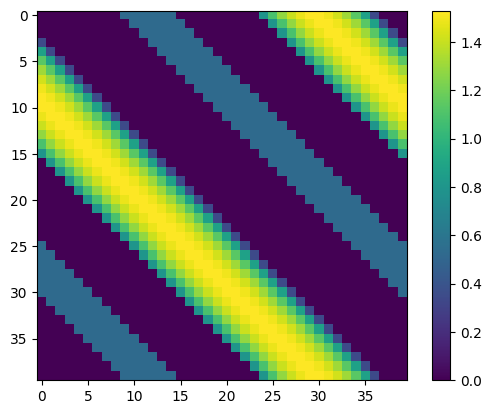

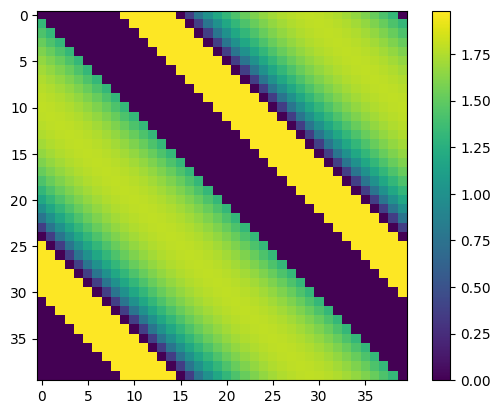

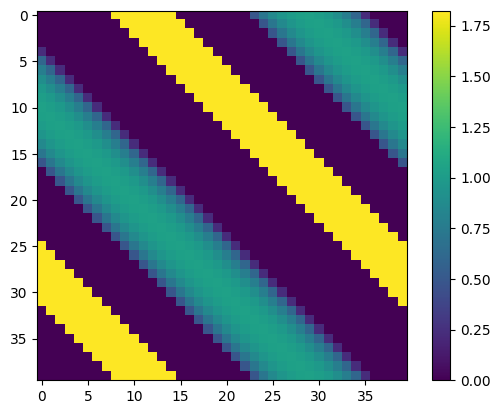

In [11]:
if __name__ == "__main__":
    # main_IC1()
    main_IC2()

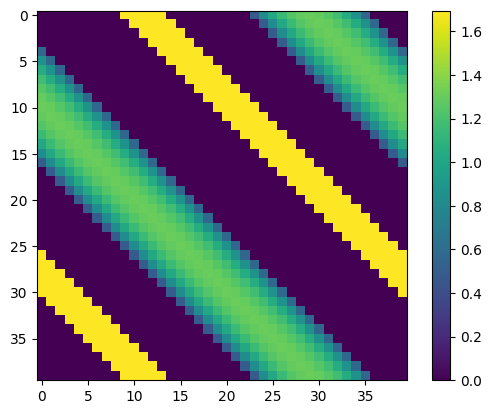

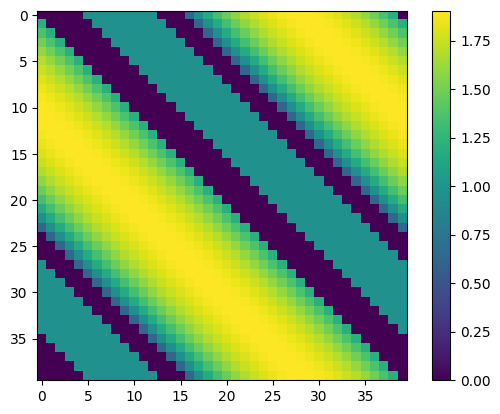

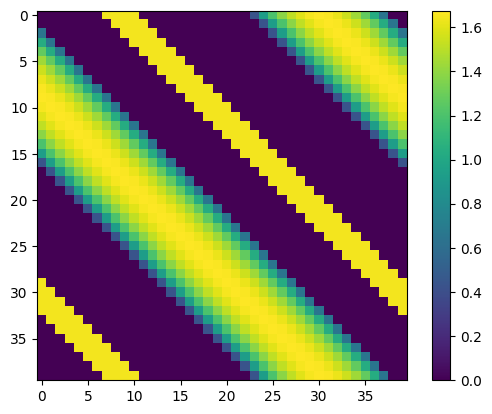

In [12]:
main_IC2()

In [13]:
def main_IC2():
    ndata = 1000
    nx = 40
    nt = 40
    geom = dde.geometry.Interval(0, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)
    x = geomtime.uniform_points(nx * nt, boundary=True)
    u = []
    rng = np.random.default_rng()
    for i in range(ndata):
        c1 = 0.1 * rng.random() + 0.2  # [0.2, 0.3]
        w = 0.1 * rng.random() + 0.1  # [0.1, 0.2]
        h1 = 1.5 * rng.random() + 0.5  # [0.5, 2]
        c2 = 0.1 * rng.random() + 0.7  # [0.7, 0.8]
        a = 5 * rng.random() + 5  # 1 / [0.1, 0.2] = [5, 10]
        h2 = 1.5 * rng.random() + 0.5  # [0.5, 2]
        pde = Advection_v2(0, 1, c1, w, h1, c2, a, h2)
        u.append(pde.solve(x).reshape(nt, nx))
    u = np.array(u)
    x, t = x[:, 0].reshape(nt, nx), x[:, 1].reshape(nt, nx)
    np.savez_compressed("train_IC2.npz", x=x, t=t, u=u)
    #for i in range(3):
    #    plt.figure()
    #    plt.imshow(u[i])
    #    plt.colorbar()
    #plt.show()

In [14]:
main_IC2()

In [15]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import deepxde as dde
from deepxde.backend import tf

In [16]:
return (u0, xt), u

SyntaxError: 'return' outside function (<ipython-input-16-98f1a07d8796>, line 1)

In [17]:
nx = 40
nt = 40
data = np.load(filename)
x = data["x"].astype(np.float32)
t = data["t"].astype(np.float32)
u = data["u"].astype(np.float32)  # N x nt x nx
u0 = u[:, 0, :]  # N x nx
xt = np.vstack((np.ravel(x), np.ravel(t))).T
u = u.reshape(-1, nt * nx)
return (u0, xt), u

NameError: name 'filename' is not defined

In [18]:
def get_data(filename):
    nx = 40
    nt = 40
    data = np.load(filename)
    x = data["x"].astype(np.float32)
    t = data["t"].astype(np.float32)
    u = data["u"].astype(np.float32)  # N x nt x nx
    u0 = u[:, 0, :]  # N x nx
    xt = np.vstack((np.ravel(x), np.ravel(t))).T
    u = u.reshape(-1, nt * nx)
    return (u0, xt), u

In [19]:
def main():
    nt = 40
    nx = 40
    x_train, y_train = get_data("train_IC2.npz")
    x_test, y_test = get_data("test_IC2.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512], [2, 512, 512, 512], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    # IC1
    # losshistory, train_state = model.train(epochs=100000, batch_size=None)
    # IC2
    losshistory, train_state = model.train(epochs=250000, batch_size=None)
    y_pred = model.predict(data.test_x)
    np.savetxt("y_pred_deeponet.dat", y_pred[0].reshape(nt, nx))
    np.savetxt("y_true_deeponet.dat", data.test_y[0].reshape(nt, nx))
    np.savetxt("y_error_deeponet.dat", (y_pred[0] - data.test_y[0]).reshape(nt, nx))

In [20]:
if __name__ == "__main__":
    main()

FileNotFoundError: [Errno 2] No such file or directory: 'test_IC2.npz'

In [21]:
if __name__ == "__main__":
    main()

FileNotFoundError: [Errno 2] No such file or directory: 'test_IC2.npz'

In [22]:
import numpy as np

In [23]:
data = np.load("train_IC2.npz")

In [24]:
x = data["x"].astype(np.float32)

In [25]:
print(x)

[[0.         0.02564103 0.05128205 ... 0.94871795 0.974359   1.        ]
 [0.         0.02564103 0.05128205 ... 0.94871795 0.974359   1.        ]
 [0.         0.02564103 0.05128205 ... 0.94871795 0.974359   1.        ]
 ...
 [0.         0.02564103 0.05128205 ... 0.94871795 0.974359   1.        ]
 [0.         0.02564103 0.05128205 ... 0.94871795 0.974359   1.        ]
 [0.         0.02564103 0.05128205 ... 0.94871795 0.974359   1.        ]]


In [26]:
print(len(x))

40


In [27]:
t = data["t"].astype(np.float32)

In [28]:
print(t)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.02564103 0.02564103 0.02564103 ... 0.02564103 0.02564103 0.02564103]
 [0.05128205 0.05128205 0.05128205 ... 0.05128205 0.05128205 0.05128205]
 ...
 [0.94871795 0.94871795 0.94871795 ... 0.94871795 0.94871795 0.94871795]
 [0.974359   0.974359   0.974359   ... 0.974359   0.974359   0.974359  ]
 [1.         1.         1.         ... 1.         1.         1.        ]]


In [29]:
print(t[1])

[0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103]


In [30]:
u = data["u"].astype(np.float32)

In [31]:
print(u)

[[[0.        0.        0.        ... 0.476272  0.        0.       ]
  [0.        0.        0.        ... 0.821189  0.476272  0.       ]
  [0.476272  0.        0.        ... 1.0294268 0.821189  0.476272 ]
  ...
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.476272  0.        0.       ]]

 [[0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.4068199 0.        0.       ]
  ...
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]]

 [[0.        0.        0.        ... 0.9080582 0.1880631 0.       ]
  [0.1880631 0.        0.        ... 1.2205466 0.9080582 0.1880631]
  [0.9080582 0.1880631 0.       

In [32]:
u0 = u[:, 0, :]  # N x nx

In [33]:
xt = np.vstack((np.ravel(x), np.ravel(t))).T

In [34]:
print(xt)

[[0.         0.        ]
 [0.02564103 0.        ]
 [0.05128205 0.        ]
 ...
 [0.94871795 1.        ]
 [0.974359   1.        ]
 [1.         1.        ]]


In [35]:
print(xt.shape)

(1600, 2)


In [36]:
print(len(x))

40


In [37]:
new_x = np.ravel(x)

In [38]:
print(new_x)

[0.         0.02564103 0.05128205 ... 0.94871795 0.974359   1.        ]


In [39]:
print(new_x.shape)

(1600,)


In [40]:
print(x)

[[0.         0.02564103 0.05128205 ... 0.94871795 0.974359   1.        ]
 [0.         0.02564103 0.05128205 ... 0.94871795 0.974359   1.        ]
 [0.         0.02564103 0.05128205 ... 0.94871795 0.974359   1.        ]
 ...
 [0.         0.02564103 0.05128205 ... 0.94871795 0.974359   1.        ]
 [0.         0.02564103 0.05128205 ... 0.94871795 0.974359   1.        ]
 [0.         0.02564103 0.05128205 ... 0.94871795 0.974359   1.        ]]


In [41]:
print(u)

[[[0.        0.        0.        ... 0.476272  0.        0.       ]
  [0.        0.        0.        ... 0.821189  0.476272  0.       ]
  [0.476272  0.        0.        ... 1.0294268 0.821189  0.476272 ]
  ...
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.476272  0.        0.       ]]

 [[0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.4068199 0.        0.       ]
  ...
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]]

 [[0.        0.        0.        ... 0.9080582 0.1880631 0.       ]
  [0.1880631 0.        0.        ... 1.2205466 0.9080582 0.1880631]
  [0.9080582 0.1880631 0.       

In [42]:
print(u.shape)

(1000, 40, 40)


In [43]:
u = u.reshape(-1, nt * nx)

In [44]:
print(u.shape)

(1000, 1600)


In [45]:
u = data["u"].astype(np.float32)

In [46]:
print(u)

[[[0.        0.        0.        ... 0.476272  0.        0.       ]
  [0.        0.        0.        ... 0.821189  0.476272  0.       ]
  [0.476272  0.        0.        ... 1.0294268 0.821189  0.476272 ]
  ...
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.476272  0.        0.       ]]

 [[0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.4068199 0.        0.       ]
  ...
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]]

 [[0.        0.        0.        ... 0.9080582 0.1880631 0.       ]
  [0.1880631 0.        0.        ... 1.2205466 0.9080582 0.1880631]
  [0.9080582 0.1880631 0.       

In [47]:
u = u.reshape(-1, nt * nx)

In [48]:
print(u.shape)

(1000, 1600)


In [49]:
print((u0, xt))

(array([[0.       , 0.       , 0.       , ..., 0.476272 , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.9080582, 0.1880631,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.3802838, 1.2070966,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32), array([[0.        , 0.        ],
       [0.02564103, 0.        ],
       [0.05128205, 0.        ],
       ...,
       [0.94871795, 1.        ],
       [0.974359  , 1.        ],
       [1.        , 1.        ]], dtype=float32))


In [50]:
print((u0, xt).shape)

AttributeError: 'tuple' object has no attribute 'shape'

In [51]:
print(xt.shape)

(1600, 2)


In [52]:
print(u0.shape)

(1000, 40)


In [53]:
print(x)

[[0.         0.02564103 0.05128205 ... 0.94871795 0.974359   1.        ]
 [0.         0.02564103 0.05128205 ... 0.94871795 0.974359   1.        ]
 [0.         0.02564103 0.05128205 ... 0.94871795 0.974359   1.        ]
 ...
 [0.         0.02564103 0.05128205 ... 0.94871795 0.974359   1.        ]
 [0.         0.02564103 0.05128205 ... 0.94871795 0.974359   1.        ]
 [0.         0.02564103 0.05128205 ... 0.94871795 0.974359   1.        ]]


In [54]:
print(t[1])

[0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103]


In [55]:
print(t)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.02564103 0.02564103 0.02564103 ... 0.02564103 0.02564103 0.02564103]
 [0.05128205 0.05128205 0.05128205 ... 0.05128205 0.05128205 0.05128205]
 ...
 [0.94871795 0.94871795 0.94871795 ... 0.94871795 0.94871795 0.94871795]
 [0.974359   0.974359   0.974359   ... 0.974359   0.974359   0.974359  ]
 [1.         1.         1.         ... 1.         1.         1.        ]]


In [56]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import deepxde as dde
from deepxde.backend import tf

In [57]:
data = np.load("train_IC2.npz")

In [58]:
x = data["x"].astype(np.float32)

In [59]:
t = data["t"].astype(np.float32)

In [60]:
u = data["u"].astype(np.float32)

In [61]:
u0 = u[:, 0, :]# N x nx

In [62]:
print(u0.shape)

(1000, 40)


In [63]:
data = np.load("test_IC2.npz")

FileNotFoundError: [Errno 2] No such file or directory: 'test_IC2.npz'

In [64]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import deepxde as dde
from deepxde.backend import tf

In [65]:
data = np.load("test_IC2.npz")

FileNotFoundError: [Errno 2] No such file or directory: 'test_IC2.npz'

In [66]:
data = np.load("test_IC2.npz")

FileNotFoundError: [Errno 2] No such file or directory: 'test_IC2.npz'

In [67]:
import sys

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [69]:
data = np.load("test_IC2.npz")

FileNotFoundError: [Errno 2] No such file or directory: 'test_IC2.npz'

In [70]:
help(dde.model)

Help on module deepxde.model in deepxde:

NAME
    deepxde.model

CLASSES
    builtins.object
        LossHistory
        Model
        TrainState
    
    class LossHistory(builtins.object)
     |  Methods defined here:
     |  
     |  __init__(self)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  append(self, step, loss_train, loss_test, metrics_test)
     |  
     |  set_loss_weights(self, loss_weights)
     |  
     |  ----------------------------------------------------------------------
     |  Data descriptors defined here:
     |  
     |  __dict__
     |      dictionary for instance variables (if defined)
     |  
     |  __weakref__
     |      list of weak references to the object (if defined)
    
    class Model(builtins.object)
     |  Model(data, net)
     |  
     |  A ``Model`` trains a ``NN`` on a ``Data``.
     |  
     |  Args:
     |      data: ``deepxde.data.Data`` instance.
     |      net: ``deepxde.nn.NN`` instance.


In [71]:
help(dde.Model)

Help on class Model in module deepxde.model:

class Model(builtins.object)
 |  Model(data, net)
 |  
 |  A ``Model`` trains a ``NN`` on a ``Data``.
 |  
 |  Args:
 |      data: ``deepxde.data.Data`` instance.
 |      net: ``deepxde.nn.NN`` instance.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data, net)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  compile(self, optimizer, lr=None, loss='MSE', metrics=None, decay=None, loss_weights=None, external_trainable_variables=None)
 |      Configures the model for training.
 |      
 |      Args:
 |          optimizer: String name of an optimizer, or a backend optimizer class
 |              instance.
 |          lr (float): The learning rate. For L-BFGS, use
 |              ``dde.optimizers.set_LBFGS_options`` to set the hyperparameters.
 |          loss: If the same loss is used for all errors, then `loss` is a String name
 |              of a loss function or a loss function. If different errors us

In [72]:
help(dde.Model.train)

Help on function train in module deepxde.model:

train(self, iterations=None, batch_size=None, display_every=1000, disregard_previous_best=False, callbacks=None, model_restore_path=None, model_save_path=None, epochs=None)
    Trains the model.
    
    Args:
        iterations (Integer): Number of iterations to train the model, i.e., number
            of times the network weights are updated.
        batch_size: Integer, tuple, or ``None``.
    
            - If you solve PDEs via ``dde.data.PDE`` or ``dde.data.TimePDE``, do not use `batch_size`, and instead use
              `dde.callbacks.PDEPointResampler
              <https://deepxde.readthedocs.io/en/latest/modules/deepxde.html#deepxde.callbacks.PDEPointResampler>`_,
              see an `example <https://github.com/lululxvi/deepxde/blob/master/examples/diffusion_1d_resample.py>`_.
            - For DeepONet in the format of Cartesian product, if `batch_size` is an Integer,
              then it is the batch size for the branch 

In [73]:
train_DeepONet()

NameError: name 'train_DeepONet' is not defined

In [74]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import deepxde as dde
from deepxde.backend import tf

In [75]:
def get_data(filename):
    data = np.load(filename)
    u0 = data["u0"].astype(np.float32)
    xt = data["xt"].astype(np.float32)
    u = data["u"].astype(np.float32) 
    return (u0, xt), u

In [76]:
def train_DeepONet(nt=41, nx=41):
    x_train, y_train = get_data("heat_train.npz")
    x_test, y_test = get_data("heat_test.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512], [2, 512, 512, 512], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    # IC1
    # losshistory, train_state = model.train(epochs=100000, batch_size=None)
    # IC2
    losshistory, train_state = model.train(epochs=100000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [ y_pred,  data.test_x, data.test_y]
    return list_return

In [77]:
train_DeepONet()

FileNotFoundError: [Errno 2] No such file or directory: 'heat_train.npz'

In [78]:
def main():
    nt = 40
    nx = 40
    x_train, y_train = get_data("train_IC2.npz")
    x_test, y_test = get_data("test_IC2.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512], [2, 512, 512, 512], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    # IC1
    # losshistory, train_state = model.train(epochs=100000, batch_size=None)
    # IC2
    losshistory, train_state = model.train(epochs=250000, batch_size=None)
    y_pred = model.predict(data.test_x)
    np.savetxt("y_pred_deeponet.dat", y_pred[0].reshape(nt, nx))
    np.savetxt("y_true_deeponet.dat", data.test_y[0].reshape(nt, nx))
    np.savetxt("y_error_deeponet.dat", (y_pred[0] - data.test_y[0]).reshape(nt, nx))

In [79]:
if __name__ == "__main__":
    main()

KeyError: 'u0 is not a file in the archive'

In [80]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import deepxde as dde
from deepxde.backend import tf

In [81]:
def get_data(filename):
    nx = 40
    nt = 40
    data = np.load(filename)
    x = data["x"].astype(np.float32)
    t = data["t"].astype(np.float32)
    u = data["u"].astype(np.float32)  # N x nt x nx
    u0 = u[:, 0, :]  # N x nx
    xt = np.vstack((np.ravel(x), np.ravel(t))).T
    u = u.reshape(-1, nt * nx)
    return (u0, xt), u

In [82]:
def main():
    nt = 40
    nx = 40
    x_train, y_train = get_data("train_IC2.npz")
    x_test, y_test = get_data("test_IC2.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512], [2, 512, 512, 512], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    # IC1
    # losshistory, train_state = model.train(epochs=100000, batch_size=None)
    # IC2
    losshistory, train_state = model.train(epochs=250000, batch_size=None)
    y_pred = model.predict(data.test_x)
    np.savetxt("y_pred_deeponet.dat", y_pred[0].reshape(nt, nx))
    np.savetxt("y_true_deeponet.dat", data.test_y[0].reshape(nt, nx))
    np.savetxt("y_error_deeponet.dat", (y_pred[0] - data.test_y[0]).reshape(nt, nx))

In [83]:
if __name__ == "__main__":
    main()

FileNotFoundError: [Errno 2] No such file or directory: 'test_IC2.npz'

In [84]:
if __name__ == "__main__":
    main()

FileNotFoundError: [Errno 2] No such file or directory: 'test_IC2.npz'

In [85]:
?dde.data

Type:        module
String form: <module 'deepxde.data' from '/home/guest/lizhen001/anaconda3/envs/cryopinn/lib/python3.11/site-packages/deepxde/data/__init__.py'>
File:        ~/anaconda3/envs/cryopinn/lib/python3.11/site-packages/deepxde/data/__init__.py
Docstring:   <no docstring>

In [86]:
help(dde.data)

Help on package deepxde.data in deepxde:

NAME
    deepxde.data

PACKAGE CONTENTS
    constraint
    data
    dataset
    fpde
    func_constraint
    function
    function_spaces
    helper
    ide
    mf
    pde
    pde_operator
    quadruple
    sampler
    triple

CLASSES
    abc.ABC(builtins.object)
        deepxde.data.data.Data
            deepxde.data.constraint.Constraint
            deepxde.data.dataset.DataSet
            deepxde.data.func_constraint.FuncConstraint
            deepxde.data.function.Function
            deepxde.data.mf.MfDataSet
            deepxde.data.mf.MfFunc
            deepxde.data.pde.PDE
                deepxde.data.fpde.FPDE
                    deepxde.data.fpde.TimeFPDE
                deepxde.data.ide.IDE
                deepxde.data.pde.TimePDE
            deepxde.data.pde_operator.PDEOperator
            deepxde.data.pde_operator.PDEOperatorCartesianProd
            deepxde.data.quadruple.Quadruple
            deepxde.data.quadruple.QuadrupleCart

In [87]:
a = np.array([1, 2, 3])

In [88]:
b = np.array([4,5,6])

In [89]:
c = np.vstack((a,b))

In [90]:
c

array([[1, 2, 3],
       [4, 5, 6]])

In [91]:
a

array([1, 2, 3])

In [92]:
c.shape

(2, 3)

In [93]:
d = np.hstack((a,b))

In [94]:
d

array([1, 2, 3, 4, 5, 6])

In [95]:
d.shape

(6,)

In [96]:
arr = np.array([[1, 2, 3], [4, 5, 6]])

In [97]:
arr.shape

(2, 3)

In [98]:
arr_xt = np.array([[1, 2], [3, 4], [5,6], [7,8]])

In [99]:
arr_xt.shape

(4, 2)

In [100]:
arr_u = np.array([[11], [12], [13], [14]])

In [101]:
arr_u.shape

(4, 1)

In [102]:
np.vstack(arr_xt, arr_u)

TypeError: vstack() takes 1 positional argument but 2 were given

In [103]:
np.vstack((arr_xt, arr_u))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 1

In [104]:
np.hstack((arr_xt, arr_u))

array([[ 1,  2, 11],
       [ 3,  4, 12],
       [ 5,  6, 13],
       [ 7,  8, 14]])

In [105]:
arr_new = np.hstack((arr_xt, arr_u))

In [107]:
np.savetxt("test.dat", arr_new)

In [108]:
xt

array([[0.        , 0.        ],
       [0.02564103, 0.        ],
       [0.05128205, 0.        ],
       ...,
       [0.94871795, 1.        ],
       [0.974359  , 1.        ],
       [1.        , 1.        ]], dtype=float32)

In [109]:
pwd

'/sparc/personal_accounts/02_Praktika/Zhengyang_Li/workspace/cryopinn/scripts/python'

In [110]:
cd ..

/sparc/personal_accounts/02_Praktika/Zhengyang_Li/workspace/cryopinn/scripts


In [111]:
cd ..

/sparc/personal_accounts/02_Praktika/Zhengyang_Li/workspace/cryopinn


In [112]:
cd ..

/sparc/personal_accounts/02_Praktika/Zhengyang_Li/workspace


In [113]:
cd deeponet-fno/

/sparc/personal_accounts/02_Praktika/Zhengyang_Li/workspace/deeponet-fno


In [114]:
cd src/advection_II_III/

/sparc/personal_accounts/02_Praktika/Zhengyang_Li/workspace/deeponet-fno/src/advection_II_III


In [115]:
arr1 = np.array([1, 2, 3, 4, 5, 6, 7,8])

In [116]:
arr2 = arr1.reshape(8, 1)

In [117]:
arr2

array([[1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8]])

In [118]:
xt

array([[0.        , 0.        ],
       [0.02564103, 0.        ],
       [0.05128205, 0.        ],
       ...,
       [0.94871795, 1.        ],
       [0.974359  , 1.        ],
       [1.        , 1.        ]], dtype=float32)

In [119]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import deepxde as dde
from deepxde.backend import tf
def get_data(filename):
    data = np.load(filename)
    u0 = data["u0"].astype(np.float32)
    xt = data["xt"].astype(np.float32)
    u = data["u"].astype(np.float32) 
    return (u0, xt), u

In [120]:
def train_DeepONet(nt=41, nx=41):
    x_train, y_train = get_data("heat_train.npz")
    x_test, y_test = get_data("heat_test.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512], [2, 512, 512, 512], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    # IC1
    # losshistory, train_state = model.train(epochs=100000, batch_size=None)
    # IC2
    losshistory, train_state = model.train(epochs=100000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [ y_pred,  data.test_x, data.test_y]
    return list_return

In [121]:
list_return = train_DeepONet()

2023-08-28 12:54:24.873355: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-28 12:54:24.873424: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38370 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-08-28 12:54:24.876429: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-28 12:54:24.876454: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38370 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-08-28 12:54:24.879201: W tensorflow/core/

Compiling model...
'compile' took 0.350742 s

Training model...



/home/guest/lizhen001/anaconda3/envs/cryopinn/lib/python3.11/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
2023-08-28 12:54:26.347954: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x5641d29eca60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-28 12:54:26.347994: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-08-28 12:54:26.347998: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-08-28 12:54:26.348003: I tensorflow/compiler/xla/service/service.cc:177

Step      Train loss    Test loss     Test metric   
0         [1.61e-01]    [1.86e-01]    [3.53e+00]    
1000      [5.42e-03]    [5.70e-04]    [1.89e-01]    
2000      [3.44e-03]    [2.19e-04]    [1.21e-01]    
3000      [2.01e-03]    [1.33e-04]    [9.61e-02]    
4000      [1.45e-03]    [1.10e-04]    [8.67e-02]    
5000      [7.61e-04]    [7.02e-05]    [6.97e-02]    
6000      [3.19e-04]    [6.43e-05]    [6.71e-02]    
7000      [3.32e-05]    [1.73e-05]    [3.41e-02]    
8000      [1.02e-04]    [2.10e-05]    [3.58e-02]    
9000      [2.95e-05]    [1.09e-05]    [2.62e-02]    
10000     [5.15e-05]    [1.43e-05]    [3.05e-02]    
11000     [2.92e-05]    [9.48e-06]    [2.41e-02]    
12000     [8.98e-05]    [2.13e-05]    [3.43e-02]    
13000     [1.39e-05]    [5.65e-06]    [1.82e-02]    
14000     [8.97e-06]    [3.72e-06]    [1.53e-02]    
15000     [7.30e-06]    [2.89e-06]    [1.34e-02]    
16000     [1.04e-05]    [2.61e-06]    [1.25e-02]    
17000     [9.05e-06]    [3.44e-06]    [1.47e-0

In [122]:
list_return[0]

array([[ 3.63416439e-05,  7.87750632e-02,  1.53937101e-01, ...,
         1.81820081e-03,  7.56379741e-04,  5.51114135e-06],
       [-2.05903733e-03,  1.55428663e-01,  3.08947355e-01, ...,
        -1.25121980e-04,  1.24503902e-04,  5.51114135e-06],
       [ 4.22520126e-04,  2.32745379e-01,  4.52999979e-01, ...,
        -4.71963613e-05, -2.01754810e-04,  5.51114135e-06],
       ...,
       [ 8.29813594e-04,  5.81636548e-01,  9.48406339e-01, ...,
        -4.77302128e-05, -2.26737502e-05,  5.51114135e-06],
       [ 4.47986211e-04,  6.42182171e-01,  9.90156651e-01, ...,
         6.81663514e-05,  4.12393238e-05,  5.51114135e-06],
       [ 1.12277965e-04,  6.98071122e-01,  1.00190854e+00, ...,
        -8.77958155e-06,  1.09257671e-05,  5.51114135e-06]], dtype=float32)

In [123]:
list_return[0].shape

(10, 1681)

In [124]:
y_predict_arr = list_return[0].reshape(41*41, 1)

ValueError: cannot reshape array of size 16810 into shape (1681,1)

In [125]:
y_predict_arr = list_return[0][0].reshape(41*41, 1)

In [126]:
xt_arr = list_return[1][1]

In [127]:
xt_arr

array([[0.   , 0.   ],
       [0.   , 0.025],
       [0.   , 0.05 ],
       ...,
       [1.   , 0.95 ],
       [1.   , 0.975],
       [1.   , 1.   ]], dtype=float32)

In [128]:
xt_arr.shape

(1681, 2)

In [129]:
y_true_arr = list_return[2][0].reshape(41*41, 1)

In [130]:
np.savetxt("test_heat_new.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator

In [132]:
data = np.genfromtxt("test_heat_new.dat", delimiter=' ')

In [133]:
interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])

In [134]:
interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])

In [135]:
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

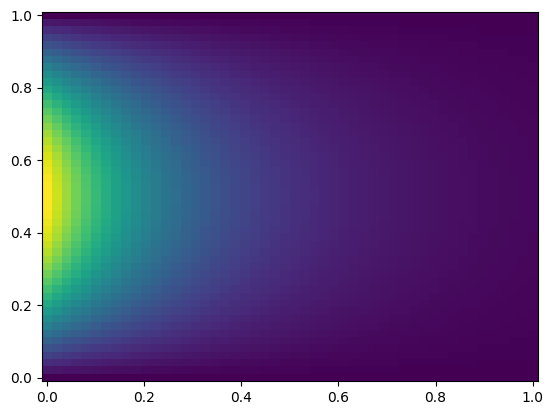

<Figure size 640x480 with 0 Axes>

In [136]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.show()
plt.savefig('heat_reference_1.png')

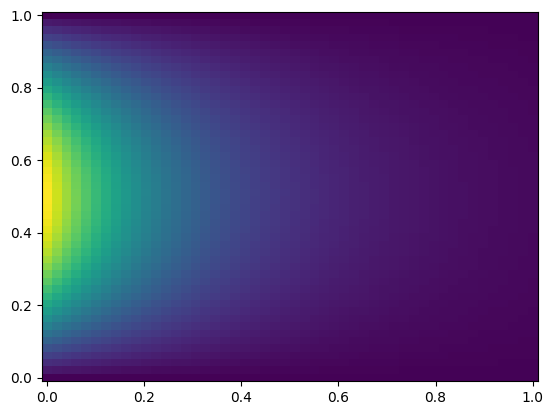

<Figure size 640x480 with 0 Axes>

In [137]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.show()
plt.savefig('heat_predict_1.png')

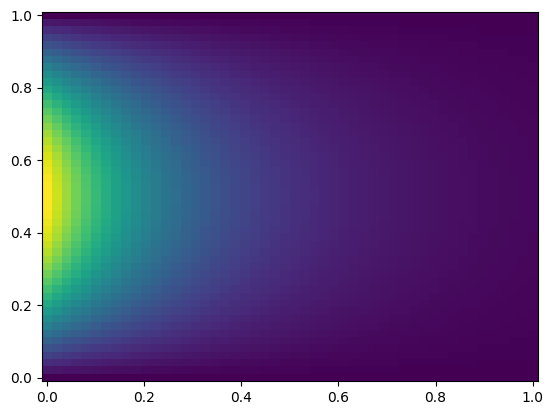

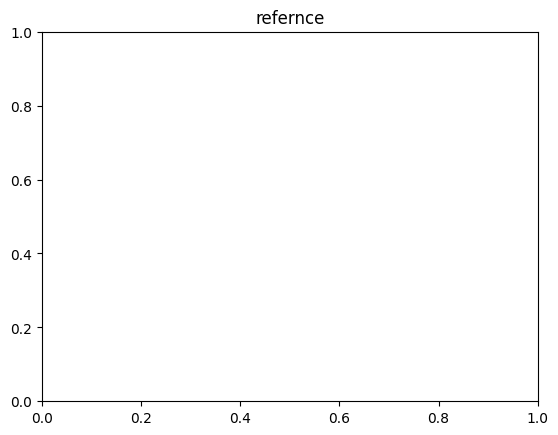

In [138]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.show()
plt.title('refernce')
plt.savefig('heat_reference_1.png')

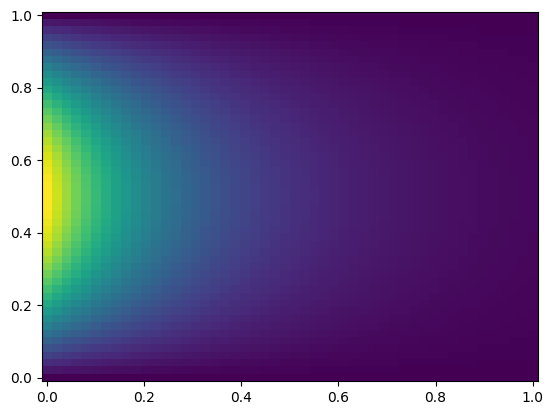

<Figure size 640x480 with 0 Axes>

In [139]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.show()
plt.savefig('heat_reference_1.png')

In [140]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import deepxde as dde
from deepxde.backend import tf

In [141]:
def get_data(filename):
    data = np.load(filename)
    u0 = data["u0"].astype(np.float32)
    xt = data["xt"].astype(np.float32)
    u = data["u"].astype(np.float32) 
    return (u0, xt), u

def train_DeepONet(nt=41, nx=41):
    x_train, y_train = get_data("heat_train.npz")
    x_test, y_test = get_data("heat_test.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512], [2, 512, 512, 512], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    # IC1
    # losshistory, train_state = model.train(epochs=100000, batch_size=None)
    # IC2
    losshistory, train_state = model.train(epochs=100000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [ y_pred,  data.test_x, data.test_y]
    return list_return

In [142]:
def train_DeepONet(nt=41, nx=41):
    x_train, y_train = get_data("heat_train.npz")
    x_test, y_test = get_data("heat_test.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512], [2, 512, 512, 512], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    # IC1
    # losshistory, train_state = model.train(epochs=100000, batch_size=None)
    # IC2
    losshistory, train_state = model.train(epochs=100000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [143]:
list_return = train_DeepONet()

Compiling model...
'compile' took 0.002551 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.61e-01]    [1.64e-01]    [7.81e+11]    
1000      [5.42e-03]    [8.56e-03]    [1.20e+11]    
2000      [3.44e-03]    [8.29e-03]    [1.68e+11]    
3000      [2.01e-03]    [8.46e-03]    [2.00e+11]    
4000      [1.45e-03]    [8.58e-03]    [2.06e+11]    
5000      [7.61e-04]    [8.47e-03]    [2.18e+11]    
6000      [3.19e-04]    [8.70e-03]    [2.18e+11]    
7000      [3.32e-05]    [8.65e-03]    [2.11e+11]    
8000      [1.02e-04]    [8.46e-03]    [2.02e+11]    
9000      [2.95e-05]    [8.42e-03]    [2.02e+11]    
10000     [5.15e-05]    [8.48e-03]    [2.03e+11]    
11000     [2.92e-05]    [8.41e-03]    [2.01e+11]    
12000     [8.98e-05]    [8.39e-03]    [1.99e+11]    
13000     [1.39e-05]    [8.39e-03]    [1.99e+11]    
14000     [8.97e-06]    [8.33e-03]    [1.99e+11]    
15000     [7.30e-06]    [8.30e-03]    [1.98e+11]    
16000     [1.04e-05]    [8.30e-03]

In [144]:
y_predict_arr = list_return[0][0].reshape(41*41, 1)
xt_arr = list_return[1][1]
y_true_arr = list_return[2][0].reshape(41*41, 1)
np.savetxt("test_heat_new.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
data = np.genfromtxt("test_heat_new.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])

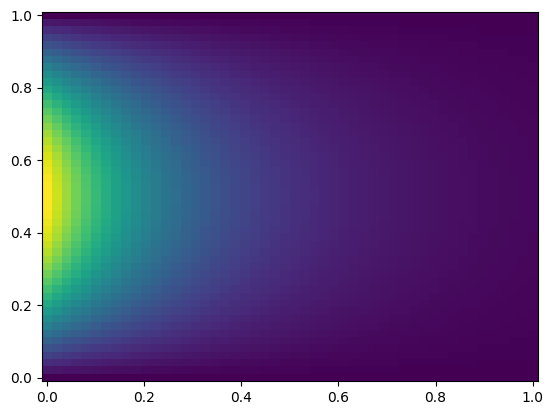

<Figure size 640x480 with 0 Axes>

In [146]:
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)
#plotting  the refernce data

Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.show()
plt.savefig('heat_reference_1.2.png')

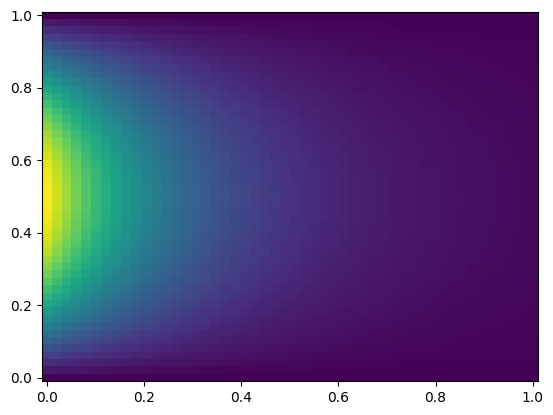

<Figure size 640x480 with 0 Axes>

In [147]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.show()
plt.savefig('heat_predict_1.2.png')

In [148]:
y_predict_arr = list_return[0][0].reshape(41*41, 1)
xt_arr = list_return[1][1]
y_true_arr = list_return[2][0].reshape(41*41, 1)
np.savetxt("test_heat_1.2.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [149]:
y_predict_arr = list_return[0][3].reshape(41*41, 1)
xt_arr = list_return[1][1]
y_true_arr = list_return[2][3].reshape(41*41, 1)
np.savetxt("test_heat_1.3.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

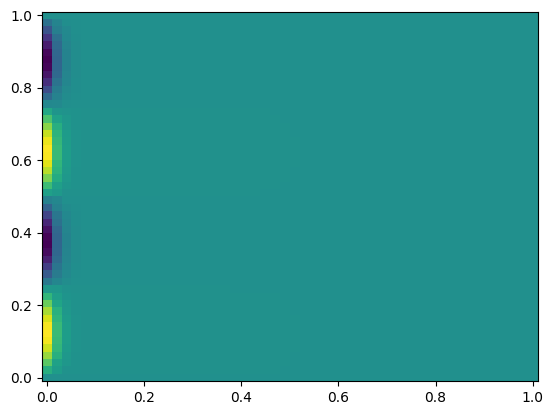

<Figure size 640x480 with 0 Axes>

In [150]:
data = np.genfromtxt("test_heat_1.3.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)
#plotting  the refernce data

Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.show()
plt.savefig('heat_reference_1.3.png')

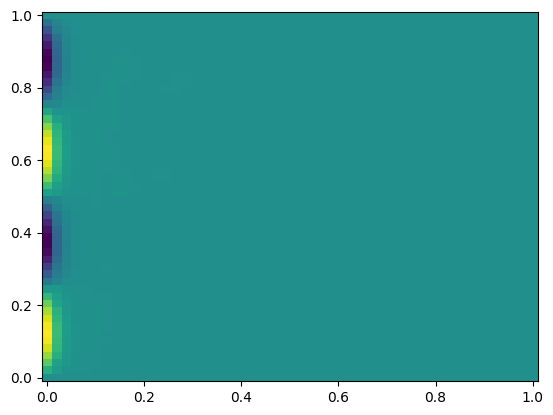

<Figure size 640x480 with 0 Axes>

In [151]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.show()
plt.savefig('heat_predict_1.3.png')

In [152]:
Model

NameError: name 'Model' is not defined

In [153]:
dde.Model

deepxde.model.Model

In [154]:
dde.model.comple

AttributeError: module 'deepxde.model' has no attribute 'comple'

In [155]:
dde.model.compile

AttributeError: module 'deepxde.model' has no attribute 'compile'

In [156]:
dde.model

<module 'deepxde.model' from '/home/guest/lizhen001/anaconda3/envs/cryopinn/lib/python3.11/site-packages/deepxde/model.py'>

In [157]:
help(dde.model)

Help on module deepxde.model in deepxde:

NAME
    deepxde.model

CLASSES
    builtins.object
        LossHistory
        Model
        TrainState
    
    class LossHistory(builtins.object)
     |  Methods defined here:
     |  
     |  __init__(self)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  append(self, step, loss_train, loss_test, metrics_test)
     |  
     |  set_loss_weights(self, loss_weights)
     |  
     |  ----------------------------------------------------------------------
     |  Data descriptors defined here:
     |  
     |  __dict__
     |      dictionary for instance variables (if defined)
     |  
     |  __weakref__
     |      list of weak references to the object (if defined)
    
    class Model(builtins.object)
     |  Model(data, net)
     |  
     |  A ``Model`` trains a ``NN`` on a ``Data``.
     |  
     |  Args:
     |      data: ``deepxde.data.Data`` instance.
     |      net: ``deepxde.nn.NN`` instance.


In [158]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import deepxde as dde
from deepxde.backend import tf
#function for orgnising the data of refernce simulations to be input into DeepONet 

def get_data(filename):
    data = np.load(filename)
    u0 = data["u0"].astype(np.float32)
    xt = data["xt"].astype(np.float32)
    u = data["u"].astype(np.float32) 
    return (u0, xt), u

In [159]:
def train_DeepONet(nt=41, nx=41):
    x_train, y_train = get_data("heat_train_linearic.npz")
    x_test, y_test = get_data("heat_test_linearic.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 1024, 1024], [2, 1024, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=100000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [161]:
def train_DeepONet(nt=41, nx=41):
    x_train, y_train = get_data("heat_train_linearic.npz")
    x_test, y_test = get_data("heat_test_linearic.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024], [2, 512, 512, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=100000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [163]:
def train_DeepONet(nt=41, nx=41):
    x_train, y_train = get_data("heat_train_linearic.npz")
    x_test, y_test = get_data("heat_test_linearic.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024], [2, 512, 512, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=100000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [164]:
list_return = train_DeepONet()

Compiling model...
'compile' took 0.002491 s

Training model...

0         [4.47e-01]    [1.40e+00]    [2.55e+00]    
1000      [6.40e-04]    [1.04e+00]    [2.20e+00]    
2000      [9.14e-04]    [1.08e+00]    [2.24e+00]    
3000      [3.50e-04]    [1.05e+00]    [2.20e+00]    
4000      [1.27e-04]    [1.04e+00]    [2.20e+00]    
5000      [6.93e-05]    [1.05e+00]    [2.20e+00]    
6000      [7.99e-06]    [1.06e+00]    [2.21e+00]    
7000      [9.42e-06]    [1.06e+00]    [2.21e+00]    
8000      [6.88e-04]    [1.06e+00]    [2.21e+00]    
9000      [3.30e-06]    [1.05e+00]    [2.21e+00]    
10000     [1.33e-05]    [1.06e+00]    [2.21e+00]    
11000     [6.80e-06]    [1.06e+00]    [2.21e+00]    
12000     [6.58e-06]    [1.06e+00]    [2.21e+00]    
13000     [4.49e-06]    [1.06e+00]    [2.21e+00]    
14000     [4.45e-06]    [1.06e+00]    [2.21e+00]    
15000     [2.52e-06]    [1.06e+00]    [2.21e+00]    
16000     [2.61e-06]    [1.05e+00]    [2.21e+00]    
17000     [4.96e-04]    [1.04e+00]

In [165]:
def train_DeepONet(nt=41, nx=41):
    x_train, y_train = get_data("heat_train2.npz")
    x_test, y_test = get_data("heat_test2.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024], [2, 512, 512, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=100000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return
#implement the training and testing rpocedure

In [166]:
def get_data(filename):
    data = np.load(filename)
    u0 = data["u0"].astype(np.float32)
    xt = data["xt"].astype(np.float32)
    u = data["u"].astype(np.float32) 
    return (u0, xt), u

In [167]:
def train_DeepONet(nt=41, nx=41):
    x_train, y_train = get_data("heat_train2.npz")
    x_test, y_test = get_data("heat_test2.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024], [2, 512, 512, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=100000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [168]:
list_return = train_DeepONet()

Compiling model...
'compile' took 0.002294 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.79e-02]    [8.48e-03]    [2.55e+00]    
1000      [5.66e-05]    [6.64e-03]    [2.34e+00]    
2000      [1.36e-04]    [6.77e-03]    [2.33e+00]    
3000      [1.56e-06]    [6.38e-03]    [2.25e+00]    
4000      [1.58e-06]    [6.38e-03]    [2.24e+00]    
5000      [8.76e-07]    [6.41e-03]    [2.23e+00]    
6000      [3.01e-06]    [6.42e-03]    [2.24e+00]    
7000      [3.52e-06]    [6.40e-03]    [2.25e+00]    
8000      [1.99e-07]    [6.38e-03]    [2.23e+00]    
9000      [7.80e-07]    [6.36e-03]    [2.23e+00]    
10000     [1.07e-07]    [6.38e-03]    [2.22e+00]    
11000     [2.02e-07]    [6.39e-03]    [2.23e+00]    
12000     [4.62e-06]    [6.42e-03]    [2.23e+00]    
13000     [5.04e-07]    [6.41e-03]    [2.23e+00]    
14000     [7.32e-08]    [6.38e-03]    [2.22e+00]    
15000     [9.02e-08]    [6.39e-03]    [2.22e+00]    
16000     [6.32e-08]    [6.38e-03]

In [169]:
y_predict_arr = list_return[0][3].reshape(41*41, 1)
xt_arr = list_return[1][1]
y_true_arr = list_return[2][3].reshape(41*41, 1)
np.savetxt("test_heat_1.3.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [170]:
y_predict_arr = list_return[0][3].reshape(41*41, 1)
xt_arr = list_return[1][1]
y_true_arr = list_return[2][3].reshape(41*41, 1)
np.savetxt("test_heat_2.3.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [171]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
data = np.genfromtxt("test_heat_2.3.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

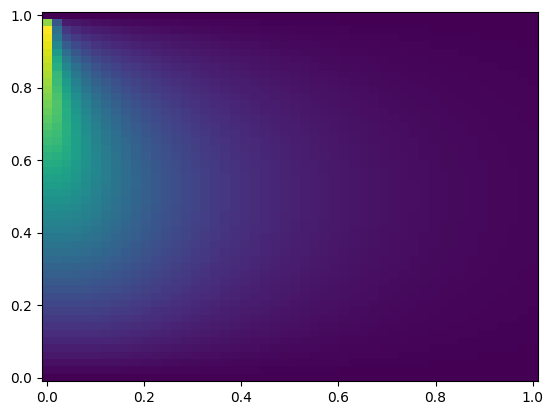

<Figure size 640x480 with 0 Axes>

In [172]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.show()
plt.savefig('heat_reference_2.3.png')

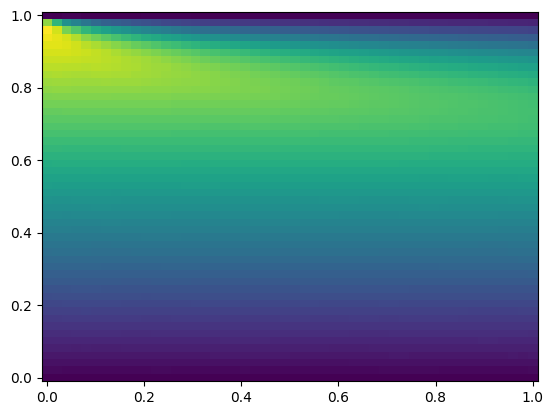

<Figure size 640x480 with 0 Axes>

In [173]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.show()
plt.savefig('heat_predict_2.3.png')

In [174]:
y_predict_arr = list_return[0][1].reshape(41*41, 1)
xt_arr = list_return[1][1]
y_true_arr = list_return[2][1].reshape(41*41, 1)
np.savetxt("test_heat_2.1.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

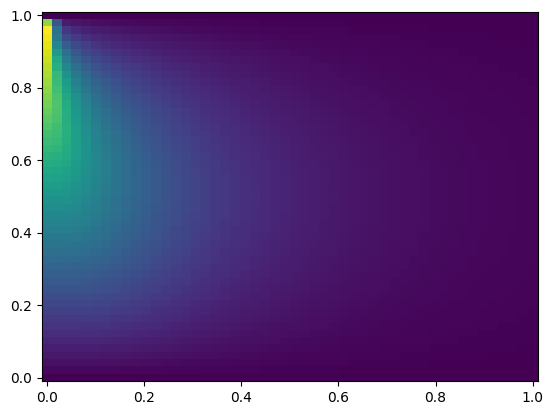

<Figure size 640x480 with 0 Axes>

In [175]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
data = np.genfromtxt("test_heat_2.1.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)
#plotting  the refernce data

Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.show()
plt.savefig('heat_reference_2.1.png')

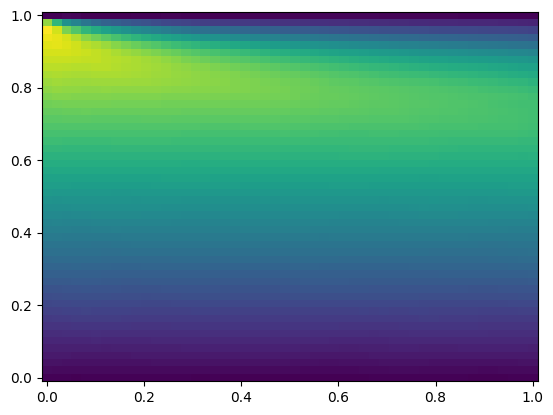

<Figure size 640x480 with 0 Axes>

In [176]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.show()
plt.savefig('heat_predict_2.1.png')

In [177]:
def train_DeepONet(nt=41, nx=41):
    x_train, y_train = get_data("heat_train2.npz")
    x_test, y_test = get_data("heat_test2.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024], [2, 512, 512, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=100000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return
#implement the training and testing rpocedure

list_return = train_DeepONet()

Compiling model...
'compile' took 0.002218 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.79e-02]    [2.26e-03]    [4.81e-01]    
1000      [5.66e-05]    [6.66e-06]    [5.81e-02]    
2000      [1.36e-04]    [1.68e-05]    [6.12e-02]    
3000      [1.56e-06]    [3.38e-07]    [2.19e-02]    
4000      [1.58e-06]    [3.41e-07]    [2.05e-02]    
5000      [8.76e-07]    [1.47e-07]    [1.32e-02]    
6000      [3.01e-06]    [3.76e-07]    [1.45e-02]    
7000      [3.52e-06]    [5.39e-07]    [1.98e-02]    
8000      [1.99e-07]    [6.18e-08]    [1.07e-02]    
9000      [7.80e-07]    [1.67e-07]    [1.36e-02]    
10000     [1.07e-07]    [3.47e-08]    [8.41e-03]    
11000     [2.02e-07]    [5.20e-08]    [9.50e-03]    
12000     [4.62e-06]    [6.31e-07]    [1.58e-02]    
13000     [5.04e-07]    [7.47e-08]    [8.00e-03]    
14000     [7.32e-08]    [2.52e-08]    [6.32e-03]    
15000     [9.02e-08]    [2.15e-08]    [5.77e-03]    
16000     [6.32e-08]    [1.98e-08]

In [178]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import deepxde as dde
from deepxde.backend import tf

In [179]:
def get_data(filename):
    data = np.load(filename)
    u0 = data["u0"].astype(np.float32)
    xt = data["xt"].astype(np.float32)
    u = data["u"].astype(np.float32) 
    return (u0, xt), u
#function for training the DeepONet and testing the model

def train_DeepONet(nt=41, nx=41):
    x_train, y_train = get_data("heat_train_nonlinear1.1.npz")
    x_test, y_test = get_data("heat_test_nonlinear1.1.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024], [2, 512, 512, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=100000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [180]:
list_return = train_DeepONet()

Compiling model...
'compile' took 0.002644 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [8.24e-02]    [1.04e-02]    [4.92e+00]    
1000      [3.26e-05]    [4.29e-06]    [1.64e-01]    
2000      [1.37e-07]    [1.45e-07]    [6.80e-02]    
3000      [2.48e-07]    [1.54e-07]    [6.10e-02]    
4000      [1.52e-06]    [2.00e-07]    [5.26e-02]    
5000      [1.13e-07]    [6.76e-08]    [4.00e-02]    
6000      [7.19e-08]    [4.21e-08]    [3.07e-02]    
7000      [2.76e-07]    [7.60e-08]    [3.72e-02]    
8000      [1.10e-07]    [4.60e-08]    [3.01e-02]    
9000      [9.55e-08]    [3.16e-08]    [2.38e-02]    
10000     [6.89e-08]    [2.25e-08]    [2.13e-02]    
11000     [9.49e-08]    [2.69e-08]    [2.18e-02]    
12000     [1.13e-07]    [2.83e-08]    [2.10e-02]    
13000     [6.82e-08]    [2.03e-08]    [1.93e-02]    
14000     [9.80e-08]    [2.36e-08]    [1.96e-02]    
15000     [4.77e-08]    [1.61e-08]    [1.85e-02]    
16000     [3.85e-08]    [1.38e-08]

In [181]:
y_predict_arr = list_return[0][3].reshape(41*41, 1)
xt_arr = list_return[1][1]
y_true_arr = list_return[2][3].reshape(41*41, 1)
np.savetxt("test_heat_2.1.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [182]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
data = np.genfromtxt("test_heat_2.1.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

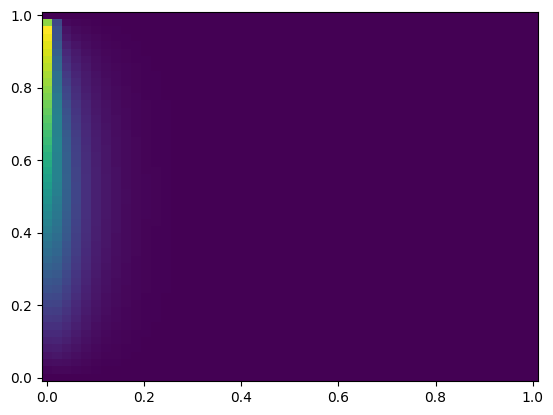

In [183]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
#plt.show()

plt.savefig('heat_reference_2.1.png')

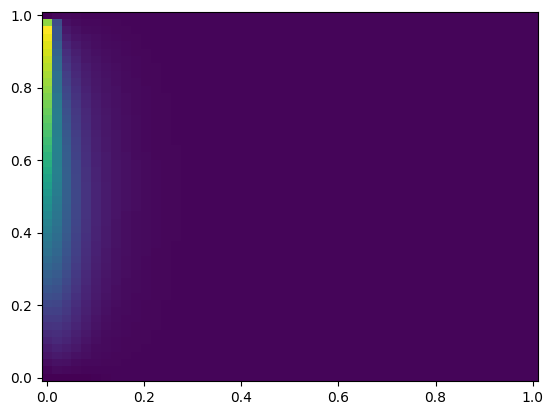

In [184]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_2.1.png')

In [185]:
y_predict_arr = list_return[0][37].reshape(41*41, 1)
xt_arr = list_return[1][1]
y_true_arr = list_return[2][37].reshape(41*41, 1)
np.savetxt("test_heat_2.37.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [186]:
data = np.genfromtxt("test_heat_2.37.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

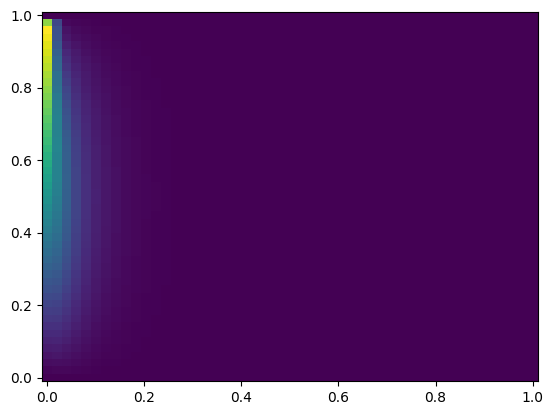

In [187]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_2.37.png')

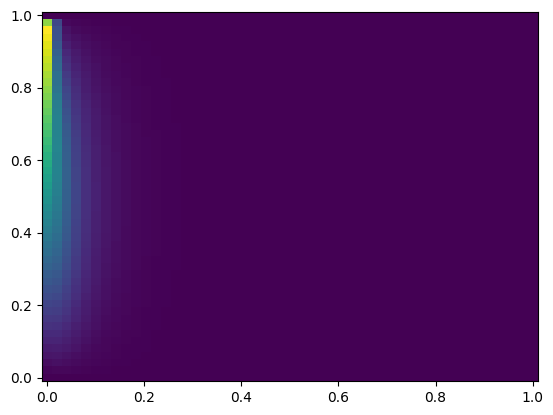

In [188]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_2.37.png')

In [189]:
ef get_data(filename):
    data = np.load(filename)
    u0 = data["u0"].astype(np.float32)
    xt = data["xt"].astype(np.float32)
    u = data["u"].astype(np.float32) 
    return (u0, xt), u

#function for training the DeepONet and testing the model
def train_DeepONet(nt=41, nx=41):
    x_train, y_train = get_data("heat_train_nonlinear1.1.npz")
    x_test, y_test = get_data("heat_test_nonlinear1.1.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)

    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024], [2, 512, 512, 1024], "relu", "Glorot normal"
    )

    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=100000, batch_size=None)

    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

SyntaxError: invalid syntax (<ipython-input-189-15831135d7e5>, line 1)

In [190]:
def get_data(filename):
    data = np.load(filename)
    u0 = data["u0"].astype(np.float32)
    xt = data["xt"].astype(np.float32)
    u = data["u"].astype(np.float32) 
    return (u0, xt), u
#function for training the DeepONet and testing the model

def train_DeepONet(nt=41, nx=41):
    x_train, y_train = get_data("heat_train_nonlinear1.1.npz")
    x_test, y_test = get_data("heat_test_nonlinear1.1.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024], [2, 512, 512, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=100000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [191]:
list_return = train_DeepONet()

Compiling model...
'compile' took 0.002266 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [8.24e-02]    [1.62e-01]    [4.90e+00]    
1000      [3.26e-05]    [6.35e-05]    [1.14e-01]    
2000      [1.37e-07]    [7.08e-07]    [2.25e-02]    
3000      [2.48e-07]    [8.77e-07]    [2.24e-02]    
4000      [1.52e-06]    [3.77e-06]    [2.98e-02]    
5000      [1.13e-07]    [6.88e-07]    [1.56e-02]    
6000      [7.19e-08]    [6.10e-07]    [1.26e-02]    
7000      [2.76e-07]    [9.90e-07]    [1.71e-02]    
8000      [1.10e-07]    [6.90e-07]    [1.32e-02]    
9000      [9.55e-08]    [6.55e-07]    [1.14e-02]    
10000     [6.89e-08]    [5.34e-07]    [1.02e-02]    
11000     [9.49e-08]    [6.41e-07]    [1.09e-02]    
12000     [1.13e-07]    [6.90e-07]    [1.10e-02]    
13000     [6.82e-08]    [5.89e-07]    [9.79e-03]    
14000     [9.80e-08]    [6.33e-07]    [1.04e-02]    
15000     [4.77e-08]    [5.30e-07]    [9.09e-03]    
16000     [3.85e-08]    [4.76e-07]

In [192]:
y_predict_arr = list_return[0][101].reshape(41*41, 1)
xt_arr = list_return[1][1]
y_true_arr = list_return[2][101].reshape(41*41, 1)
np.savetxt("test_heat_2.101.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [193]:
data = np.genfromtxt("test_heat_2.101.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

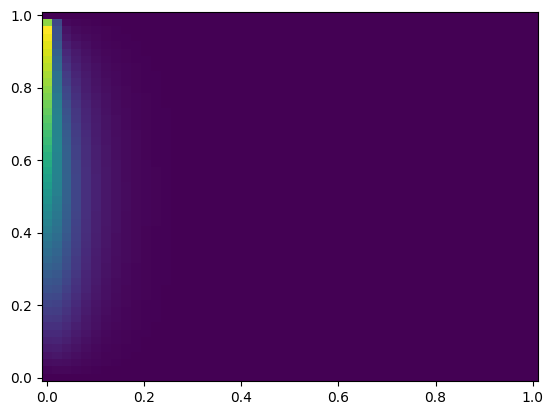

In [194]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_2.101.png')

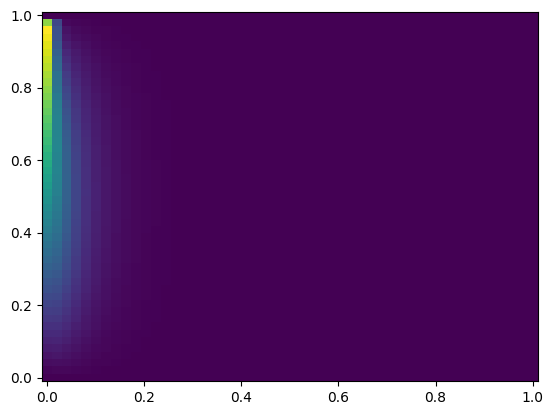

In [195]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_2.101.png')

In [196]:
y_predict_arr = list_return[0][190].reshape(41*41, 1)
xt_arr = list_return[1][1]
y_true_arr = list_return[2][190].reshape(41*41, 1)
np.savetxt("test_heat_2.190.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [197]:
data = np.genfromtxt("test_heat_2.190.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

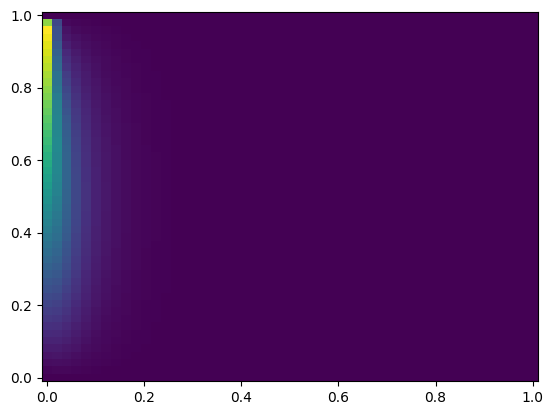

In [198]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_2.190.png')

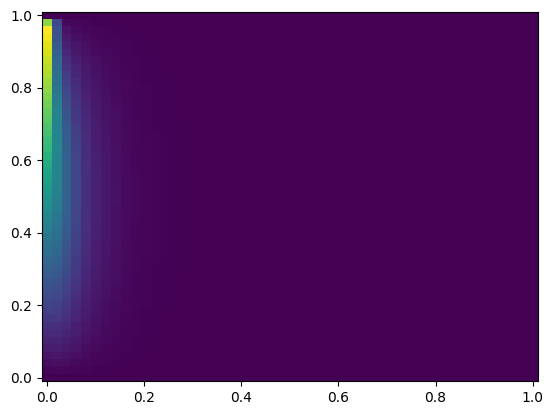

In [199]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_2.190.png')

In [200]:
import sys

In [201]:
import numpy as np

In [202]:
import matplotlib.pyplot as plt

In [203]:
import matplotlib.pyplot as plt

In [204]:
pwd

'/sparc/personal_accounts/02_Praktika/Zhengyang_Li/workspace/deeponet-fno/src/advection_II_III'

In [205]:
cd ..

/sparc/personal_accounts/02_Praktika/Zhengyang_Li/workspace/deeponet-fno/src


In [206]:
cd ..

/sparc/personal_accounts/02_Praktika/Zhengyang_Li/workspace/deeponet-fno


In [207]:
cd ..

/sparc/personal_accounts/02_Praktika/Zhengyang_Li/workspace


In [208]:
cd cryopinn/scripts/python

/sparc/personal_accounts/02_Praktika/Zhengyang_Li/workspace/cryopinn/scripts/python


In [209]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import deepxde as dde
from deepxde.backend import tf

In [210]:
def get_data(filename):
    data = np.load(filename)
    u0 = data["u0"].astype(np.float32)
    xt = data["xt"].astype(np.float32)
    u = data["u"].astype(np.float32) 
    return (u0, xt), u

In [211]:
def train_DeepONet(nt=41, nx=41):
    x_train, y_train = get_data("heat_train2.npz")
    x_test, y_test = get_data("heat_test2.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024], [2, 512, 512, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=100000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [212]:
list_return = train_DeepONet()

Compiling model...
'compile' took 0.002337 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.79e-02]    [2.26e-03]    [4.81e-01]    
1000      [5.66e-05]    [6.66e-06]    [5.81e-02]    
2000      [1.36e-04]    [1.68e-05]    [6.12e-02]    
3000      [1.56e-06]    [3.38e-07]    [2.19e-02]    
4000      [1.58e-06]    [3.41e-07]    [2.05e-02]    
5000      [8.76e-07]    [1.47e-07]    [1.32e-02]    
6000      [3.01e-06]    [3.76e-07]    [1.45e-02]    
7000      [3.52e-06]    [5.39e-07]    [1.98e-02]    
8000      [1.99e-07]    [6.18e-08]    [1.07e-02]    
9000      [7.80e-07]    [1.67e-07]    [1.36e-02]    
10000     [1.07e-07]    [3.47e-08]    [8.41e-03]    
11000     [2.02e-07]    [5.20e-08]    [9.50e-03]    
12000     [4.62e-06]    [6.31e-07]    [1.58e-02]    
13000     [5.04e-07]    [7.47e-08]    [8.00e-03]    
14000     [7.32e-08]    [2.52e-08]    [6.32e-03]    
15000     [9.02e-08]    [2.15e-08]    [5.77e-03]    
16000     [6.32e-08]    [1.98e-08]

In [213]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_linearic_large_quasi.npz")
    x_test, y_test = get_data("heat_test_linearic_large_gridsample.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024], [2, 512, 512, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=100000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [214]:
list_return = train_DeepONet()

Compiling model...
'compile' took 0.002289 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.87e+10]    [5.82e+10]    [8.48e+05]    
1000      [6.39e+00]    [2.15e+01]    [2.98e+01]    
2000      [6.37e+00]    [2.23e+01]    [2.89e+01]    
3000      [6.23e+00]    [2.20e+01]    [2.87e+01]    
4000      [6.21e+00]    [2.80e+01]    [2.90e+01]    
5000      [6.68e+00]    [2.00e+01]    [2.61e+01]    
6000      [6.35e+00]    [1.74e+01]    [2.78e+01]    
7000      [2.64e+00]    [4.30e+00]    [1.90e+01]    
8000      [2.48e+00]    [4.85e+00]    [1.87e+01]    
9000      [2.27e+00]    [4.06e+00]    [1.79e+01]    
10000     [5.66e-01]    [1.14e+00]    [1.29e+01]    
11000     [5.32e-01]    [1.16e+00]    [1.22e+01]    
12000     [5.70e-01]    [1.91e+00]    [1.21e+01]    
13000     [2.09e+01]    [3.77e+01]    [2.82e+01]    
14000     [2.59e-01]    [4.40e-01]    [7.98e+00]    
15000     [1.90e-01]    [3.37e-01]    [6.43e+00]    
16000     [1.21e-01]    [3.01e-01]

In [215]:
def get_data(filename):
    data = np.load(filename)
    u0 = data["u0"].astype(np.float32)
    xt = data["xt"].astype(np.float32)
    u = data["u"].astype(np.float32) 
    return (u0, xt), u

In [216]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_linearic_large_quasi.npz")
    x_test, y_test = get_data("heat_test_linearic_large_gridsample.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 1024, 1024], [2, 1024, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=100000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [217]:
list_return = train_DeepONet()

Compiling model...
'compile' took 0.002310 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.53e+10]    [3.11e+10]    [6.20e+05]    
1000      [2.81e+01]    [5.50e+01]    [8.51e+01]    
2000      [2.30e+01]    [3.23e+01]    [7.30e+01]    
3000      [1.37e+01]    [2.61e+01]    [6.42e+01]    
4000      [1.21e+00]    [1.47e+00]    [2.17e+01]    
5000      [1.18e+00]    [1.39e+00]    [2.13e+01]    
6000      [1.16e+00]    [1.36e+00]    [2.08e+01]    
7000      [1.11e+00]    [1.41e+00]    [2.03e+01]    
8000      [2.95e+00]    [4.74e+00]    [2.32e+01]    
9000      [8.40e-01]    [1.49e+00]    [1.21e+01]    
10000     [2.64e+01]    [5.19e+01]    [3.03e+01]    
11000     [6.50e-01]    [1.32e+00]    [8.07e+00]    
12000     [1.35e-01]    [2.45e-01]    [3.88e+00]    
13000     [1.25e-01]    [2.71e-01]    [3.48e+00]    
14000     [1.25e-01]    [2.32e-01]    [3.27e+00]    
15000     [4.20e-01]    [4.51e-01]    [1.44e+01]    
16000     [3.28e-01]    [4.87e-01]

In [218]:
y_predict_arr = list_return[0][1].reshape(2048, 1)
xt_arr = list_return[1][1]
y_true_arr = list_return[2][1].reshape(2048, 1)
np.savetxt("test_heat_3.1.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [219]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_linearic_large_quasi.npz")
    x_test, y_test = get_data("heat_test_linearic_large_gridsample.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 1024, 1024], [2, 1024, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=100000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [220]:
list_return = train_DeepONet()

Compiling model...
'compile' took 0.002370 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.53e+10]    [3.11e+10]    [6.20e+05]    
1000      [4.03e+01]    [5.95e+01]    [1.15e+02]    
2000      [1.06e+01]    [1.19e+01]    [6.55e+01]    
3000      [1.03e+01]    [1.24e+01]    [6.39e+01]    
4000      [1.58e+01]    [2.38e+01]    [6.55e+01]    
5000      [9.87e+00]    [1.01e+01]    [6.30e+01]    
6000      [1.09e+00]    [1.03e+00]    [1.88e+01]    
7000      [9.64e-01]    [1.15e+00]    [1.67e+01]    
8000      [9.60e-01]    [1.20e+00]    [1.60e+01]    
9000      [8.70e-01]    [9.46e-01]    [1.65e+01]    
10000     [7.80e-01]    [8.91e-01]    [1.55e+01]    
11000     [8.98e-02]    [1.45e-01]    [4.22e+00]    
12000     [4.46e-02]    [6.26e-02]    [2.45e+00]    
13000     [4.01e-02]    [6.05e-02]    [2.41e+00]    
14000     [3.75e-02]    [6.21e-02]    [2.38e+00]    
15000     [8.85e-02]    [1.62e-01]    [2.80e+00]    
16000     [1.12e-01]    [1.36e-01]

In [221]:
y_predict_arr = list_return[0][1].reshape(2048, 1)
xt_arr = list_return[1][1]
y_true_arr = list_return[2][1].reshape(2048, 1)
np.savetxt("test_heat_3.1.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [222]:
y_predict_arr = list_return[0][1].reshape(2048, 1)

In [223]:
y_predict_arr

array([[0.00130524],
       [0.00130524],
       [0.00130524],
       ...,
       [0.00130524],
       [0.00130524],
       [0.00130524]], dtype=float32)

In [224]:
y_true_arr

array([[2.3404033e-12],
       [1.7148098e-07],
       [4.9465325e-07],
       ...,
       [1.0146154e-11],
       [1.2812379e-10],
       [1.3085598e-12]], dtype=float32)

In [225]:
y_predict = list_return[0][1]

In [226]:
y_predict

array([0.00130524, 0.00130524, 0.00130524, ..., 0.00130524, 0.00130524,
       0.00130524], dtype=float32)

In [227]:
def get_data(filename):
    data = np.load(filename)
    u0 = data["u0"].astype(np.float32)
    xt = data["xt"].astype(np.float32)
    u = data["u"].astype(np.float32) 
    return (u0, xt), u

In [228]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_linearic_1h_quasi.npz")
    x_test, y_test = get_data("heat_test_linearic_1h_gridsample.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 1024], [2, 512, 512, 512, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=100000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [229]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_linearic_1h_quasi.npz")
    x_test, y_test = get_data("heat_test_linearic_1h_gridsample.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 1024], [2, 512, 512, 512, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [230]:
list_return = train_DeepONet()

Compiling model...
'compile' took 0.025430 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.69e+07]    [5.32e+07]    [4.97e+03]    
1000      [3.25e-01]    [7.20e-01]    [6.28e-01]    
2000      [2.60e-01]    [5.70e-01]    [5.98e-01]    
3000      [2.66e-01]    [5.88e-01]    [7.03e-01]    
4000      [2.23e-01]    [5.01e-01]    [4.96e-01]    
5000      [2.95e-01]    [6.57e-01]    [5.55e-01]    
6000      [1.37e-01]    [2.91e-01]    [3.75e-01]    
7000      [5.75e-02]    [1.29e-01]    [2.53e-01]    
8000      [6.43e-03]    [3.27e-02]    [1.33e-01]    
9000      [5.87e-02]    [1.32e-01]    [2.55e-01]    
10000     [3.06e-02]    [7.16e-02]    [2.04e-01]    
11000     [3.94e-02]    [8.84e-02]    [2.13e-01]    
12000     [5.26e-01]    [1.06e+00]    [7.09e-01]    
13000     [2.46e-02]    [5.91e-02]    [1.82e-01]    
14000     [5.75e-02]    [1.23e-01]    [2.45e-01]    
15000     [3.01e-01]    [6.08e-01]    [5.67e-01]    
16000     [2.31e-01]    [4.74e-01]

In [231]:
y_predict_arr = list_return[0][1].reshape(2048, 1)
xt_arr = list_return[1][1]
y_true_arr = list_return[2][1].reshape(2048, 1)
np.savetxt("test_heat_3.1.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [232]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
data = np.genfromtxt("test_heat_3.1.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

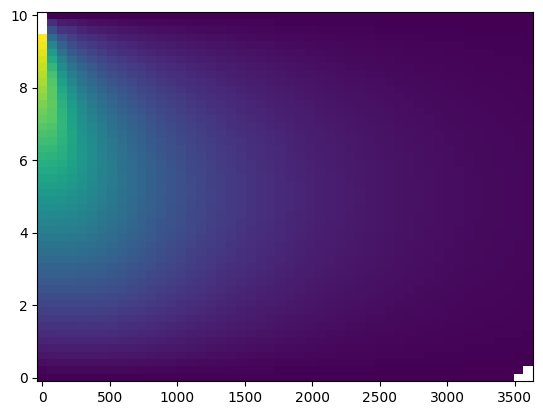

In [233]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_3.1.png')

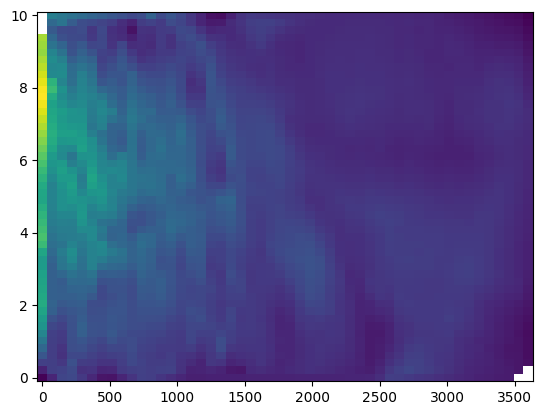

In [234]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_3.1.png')

In [235]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_linearic_1h_quasi.npz")
    x_test, y_test = get_data("heat_test_linearic_1h_gridsample.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 1024], [2, 512, 512, 512, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [236]:
list_return = train_DeepONet()

Compiling model...
'compile' took 0.002751 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.69e+07]    [5.32e+07]    [4.97e+03]    
1000      [1.96e+01]    [3.83e+01]    [4.35e+00]    
2000      [3.68e+00]    [7.27e+00]    [1.93e+00]    
3000      [2.67e-01]    [5.69e-01]    [5.45e-01]    
4000      [2.44e-01]    [5.15e-01]    [5.16e-01]    
5000      [3.80e+04]    [7.51e+04]    [1.86e+02]    
6000      [2.47e-01]    [4.82e-01]    [4.83e-01]    
7000      [1.98e-02]    [4.25e-02]    [1.70e-01]    
8000      [1.02e-02]    [2.49e-02]    [1.28e-01]    
9000      [2.54e-01]    [5.09e-01]    [5.00e-01]    
10000     [2.39e+00]    [4.77e+00]    [1.62e+00]    
11000     [1.68e-01]    [3.52e-01]    [4.12e-01]    
12000     [2.86e-02]    [6.85e-02]    [2.24e-01]    
13000     [1.81e-02]    [4.72e-02]    [1.82e-01]    
14000     [1.54e-01]    [3.09e-01]    [3.93e-01]    
15000     [3.05e-02]    [7.01e-02]    [1.97e-01]    
16000     [2.24e-02]    [4.92e-02]

In [237]:
y_predict_arr = list_return[0][1].reshape(2048, 1)
xt_arr = list_return[1][1]
y_true_arr = list_return[2][1].reshape(2048, 1)
np.savetxt("test_heat_3.2.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [238]:
data = np.genfromtxt("test_heat_3.2.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

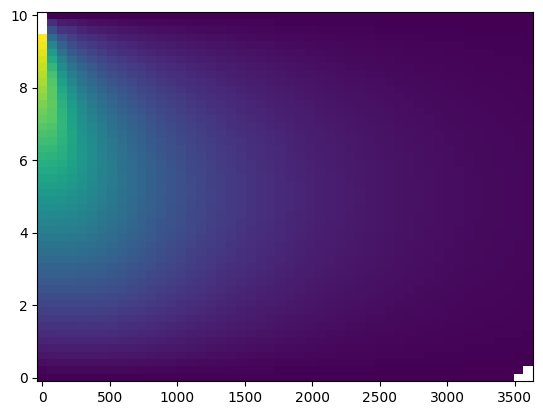

In [239]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_3.2.png')

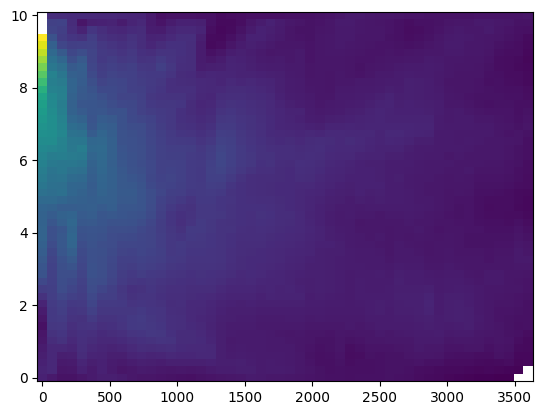

In [240]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_3.2.png')

In [241]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_linearic_1h_quasi.npz")
    x_test, y_test = get_data("heat_test_linearic_1h_gridsample.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512, 1024], [2, 512, 512, 512, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [242]:
list_return = train_DeepONet()

Compiling model...
'compile' took 0.003319 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.79e+07]    [3.61e+07]    [4.33e+03]    
1000      [1.60e+00]    [1.99e+00]    [2.34e+00]    
2000      [2.70e-01]    [5.09e-01]    [5.38e-01]    
3000      [1.23e-02]    [3.68e-02]    [1.71e-01]    
4000      [7.17e-02]    [1.44e-01]    [2.93e-01]    
5000      [1.37e-02]    [3.48e-02]    [1.49e-01]    
6000      [3.52e-02]    [7.31e-02]    [2.06e-01]    
7000      [4.36e-01]    [8.71e-01]    [7.26e-01]    
8000      [2.41e-01]    [4.69e-01]    [5.09e-01]    
9000      [4.94e-02]    [9.61e-02]    [2.62e-01]    
10000     [5.65e-02]    [1.15e-01]    [2.72e-01]    
11000     [1.17e-01]    [2.17e-01]    [3.56e-01]    
12000     [3.44e-02]    [7.53e-02]    [2.15e-01]    
13000     [2.53e-01]    [5.11e-01]    [5.60e-01]    
14000     [6.12e-02]    [1.17e-01]    [2.73e-01]    
15000     [1.72e-02]    [3.39e-02]    [1.67e-01]    
16000     [4.27e-02]    [8.84e-02]

In [243]:
y_predict_arr = list_return[0][2].reshape(3500, 1)
xt_arr = list_return[1][1]
y_true_arr = list_return[2][2].reshape(3500, 1)
np.savetxt("test_heat_3.3.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [244]:
data = np.genfromtxt("test_heat_3.3.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

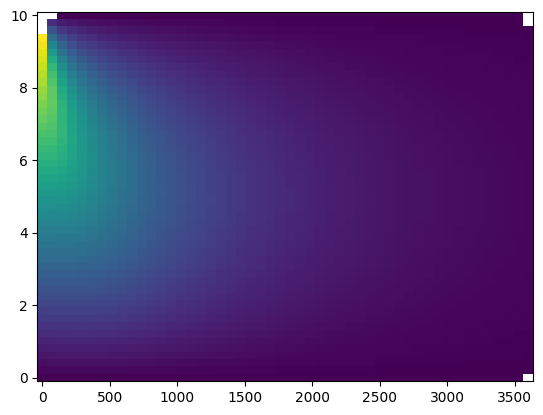

In [245]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_3.3.png')

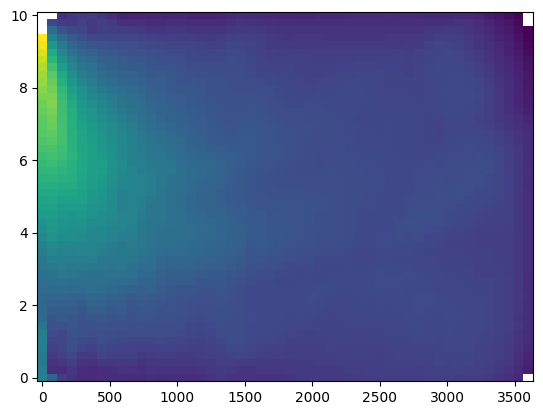

In [246]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_3.3.png')

In [247]:
def get_data(filename):
    data = np.load(filename)
    u0 = data["u0"].astype(np.float32)
    xt = data["xt"].astype(np.float32)
    u = data["u"].astype(np.float32) 
    return (u0, xt), u

In [248]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1h.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1h.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512, 1024], [2, 512, 512, 512, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=60000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [249]:
list_return = train_DeepONet()

Compiling model...
'compile' took 0.002443 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.79e+07]    [3.55e+07]    [9.86e+03]    
1000      [6.61e-03]    [2.75e-02]    [8.40e-01]    
2000      [1.60e-03]    [2.12e-02]    [4.58e-01]    
3000      [1.25e-03]    [2.12e-02]    [3.84e-01]    
4000      [1.12e-03]    [2.02e-02]    [3.44e-01]    
5000      [8.94e-04]    [1.93e-02]    [2.93e-01]    
6000      [7.95e-05]    [2.03e-02]    [2.52e-01]    
7000      [7.36e-05]    [2.14e-02]    [2.63e-01]    
8000      [5.52e-05]    [2.10e-02]    [2.62e-01]    
9000      [5.05e-05]    [2.24e-02]    [2.69e-01]    
10000     [5.68e-04]    [1.94e-02]    [2.88e-01]    
11000     [2.70e-04]    [1.82e-02]    [2.61e-01]    
12000     [1.54e-04]    [1.87e-02]    [2.62e-01]    
13000     [2.66e-04]    [1.90e-02]    [2.68e-01]    
14000     [7.78e-05]    [1.98e-02]    [2.70e-01]    
15000     [5.84e-05]    [2.34e-02]    [2.89e-01]    
16000     [3.20e-05]    [2.32e-02]

In [250]:
y_predict_arr = list_return[0][2].reshape(3500, 1)
xt_arr = list_return[1][1]
y_true_arr = list_return[2][2].reshape(3500, 1)
np.savetxt("test_heat_4.1.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [251]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1h.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1h.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 1024], [2, 512, 512, 512, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=60000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [253]:
data = np.genfromtxt("test_heat_4.1.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

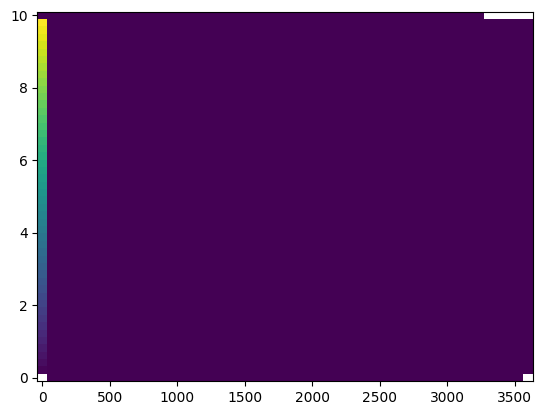

In [254]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_4.1.png')

In [255]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1h.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1h.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512], [2, 512, 512, 512, 512], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=60000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [257]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1h.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1h.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 1024], [2, 512, 512, 512, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=60000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [259]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1h.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1h.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 1024, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=60000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [261]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1h.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1h.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 1024, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=30000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [262]:
list_return = train_DeepONet()

Compiling model...
'compile' took 0.003235 s

Training model...

0         [1.62e+07]    [8.09e+06]    [1.91e+03]    
1000      [1.77e+00]    [8.82e-01]    [7.00e-01]    
2000      [1.05e+00]    [5.37e-01]    [5.37e-01]    
3000      [1.07e+00]    [5.40e-01]    [4.92e-01]    
4000      [1.02e+00]    [5.18e-01]    [4.75e-01]    
5000      [1.01e+00]    [5.12e-01]    [4.71e-01]    
6000      [2.14e+00]    [1.11e+00]    [7.14e-01]    
7000      [9.74e-01]    [4.94e-01]    [4.58e-01]    
8000      [9.96e-01]    [5.10e-01]    [4.62e-01]    
9000      [2.14e+00]    [1.10e+00]    [6.95e-01]    
10000     [1.02e+00]    [5.10e-01]    [4.92e-01]    
11000     [9.32e-01]    [4.72e-01]    [4.50e-01]    
12000     [2.36e+00]    [1.08e+00]    [6.64e-01]    
13000     [9.11e-01]    [4.66e-01]    [4.75e-01]    
14000     [1.38e+00]    [6.47e-01]    [6.42e-01]    
15000     [9.45e-01]    [4.77e-01]    [6.36e-01]    
16000     [6.97e-01]    [3.45e-01]    [5.45e-01]    
17000     [7.55e-01]    [3.90e-01]

In [263]:
y_predict_arr = list_return[0][2].reshape(3500, 1)
xt_arr = list_return[1][1]
y_true_arr = list_return[2][2].reshape(3500, 1)
np.savetxt("test_heat_4.1.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

ValueError: cannot reshape array of size 3000 into shape (3500,1)

In [264]:
y_predict_arr = list_return[0][2].reshape(3000, 1)
xt_arr = list_return[1][1]
y_true_arr = list_return[2][2].reshape(3000, 1)
np.savetxt("test_heat_4.1.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [265]:
data = np.genfromtxt("test_heat_4.1.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

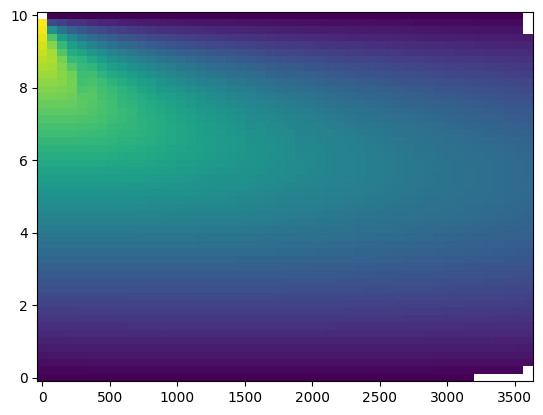

In [266]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_4.1.png')

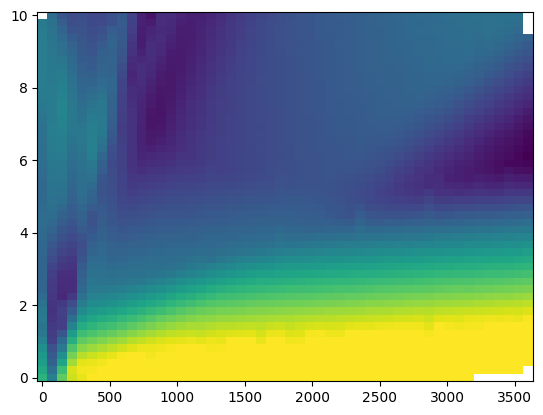

In [267]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_4.1.png')

In [268]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1h.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1h.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512, 1024], [2, 512, 512, 512, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [270]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1h.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1h.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "tanh", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [272]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1h.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1h.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "tanh", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [274]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_linearic_1h_quasi.npz")
    x_test, y_test = get_data("heat_test_linearic_1h_gridsample.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512, 1024], [2, 512, 512, 512, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None)
    y_pred = model.predict(data.train_x)
    list_return = [y_pred, data.train_x, data.train_y]
    return list_return

In [275]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_linearic_1h_quasi.npz")
    x_test, y_test = get_data("heat_test_linearic_1h_gridsample.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512, 1024], [2, 512, 512, 512, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None)
    return model

In [276]:
model_linear1h, data_linear1h = train_DeepONet()

Compiling model...
'compile' took 0.002570 s

Training model...

0         [1.79e+07]    [3.61e+07]    [4.33e+03]    
1000      [1.60e+00]    [1.99e+00]    [2.34e+00]    
2000      [2.70e-01]    [5.09e-01]    [5.38e-01]    
3000      [1.23e-02]    [3.68e-02]    [1.71e-01]    
4000      [7.17e-02]    [1.44e-01]    [2.93e-01]    
5000      [1.37e-02]    [3.48e-02]    [1.49e-01]    
6000      [3.52e-02]    [7.31e-02]    [2.06e-01]    
7000      [4.36e-01]    [8.71e-01]    [7.26e-01]    
8000      [2.41e-01]    [4.69e-01]    [5.09e-01]    
9000      [4.94e-02]    [9.61e-02]    [2.62e-01]    
10000     [5.65e-02]    [1.15e-01]    [2.72e-01]    
11000     [1.17e-01]    [2.17e-01]    [3.56e-01]    
12000     [3.44e-02]    [7.53e-02]    [2.15e-01]    
13000     [2.53e-01]    [5.11e-01]    [5.60e-01]    
14000     [6.12e-02]    [1.17e-01]    [2.73e-01]    
15000     [1.72e-02]    [3.39e-02]    [1.67e-01]    
16000     [4.27e-02]    [8.84e-02]    [2.65e-01]    
17000     [5.03e-03]    [1.19e-02]

TypeError: cannot unpack non-iterable Model object

Connected to cryopinn (Python 3.11.4)

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import deepxde as dde
from deepxde.backend import tf

2023-08-31 11:22:55.604309: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 11:23:11.951660: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Enable just-in-time compilation with XLA.



In [2]:
def get_data(filename):
    data = np.load(filename)
    u0 = data["u0"].astype(np.float32)
    xt = data["xt"].astype(np.float32)
    u = data["u"].astype(np.float32) 
    return (u0, xt), u

In [3]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_linearic_1h_quasi.npz")
    x_test, y_test = get_data("heat_test_linearic_1h_gridsample.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512, 1024], [2, 512, 512, 512, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=10, batch_size=None)
    return model, data

In [4]:
model_linear1h, data_linear1h = train_DeepONet()

2023-08-31 11:25:31.489043: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-31 11:25:31.489108: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38370 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-08-31 11:25:31.500647: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-31 11:25:31.500670: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38370 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-08-31 11:25:31.503355: W tensorflow/core/

Compiling model...
'compile' took 0.815778 s

Training model...



/home/guest/lizhen001/anaconda3/envs/cryopinn/lib/python3.11/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
2023-08-31 11:25:33.977997: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55dc8114b4a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-31 11:25:33.978045: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-08-31 11:25:33.978052: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-08-31 11:25:33.978059: I tensorflow/compiler/xla/service/service.cc:177

Step      Train loss    Test loss     Test metric   
0         [6.40e+06]    [1.29e+07]    [2.59e+03]    
10        [3.56e+04]    [7.27e+04]    [1.88e+02]    

Best model at step 10:
  train loss: 3.56e+04
  test loss: 7.27e+04
  test metric: [1.88e+02]

'train' took 31.781156 s



In [5]:
y_pred = model_linear1h.predict(data_linear1h.train_x)

In [6]:
y_pred

array([[-4.1446839e-03, -2.2029529e+00, -3.3062737e+00, ...,
        -3.7720876e+00, -2.6713004e+00, -4.6533573e-01],
       [-1.9257017e-03, -1.9822820e+00, -2.9744697e+00, ...,
        -3.3938375e+00, -2.4034362e+00, -4.1884333e-01],
       [ 7.0336577e-04, -1.7736917e+00, -2.6610951e+00, ...,
        -3.0366194e+00, -2.1504707e+00, -3.7479317e-01],
       ...,
       [ 4.2213416e+00,  2.8468930e+02,  4.2692419e+02, ...,
         4.8692978e+02,  3.4471420e+02,  6.0516285e+01],
       [ 4.2256227e+00,  2.8512119e+02,  4.2757224e+02, ...,
         4.8766916e+02,  3.4523788e+02,  6.0607601e+01],
       [ 4.2293539e+00,  2.8527438e+02,  4.2780234e+02, ...,
         4.8793118e+02,  3.4542322e+02,  6.0640236e+01]], dtype=float32)

In [7]:
y_pred.shape

(1000, 6000)

In [8]:
y_pred[0]

array([-0.00414468, -2.2029529 , -3.3062737 , ..., -3.7720876 ,
       -2.6713004 , -0.46533573], dtype=float32)

In [9]:
y_pred[0].shape

(6000,)

In [10]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_linearic_1h_quasi.npz")
    x_test, y_test = get_data("heat_test_linearic_1h_gridsample.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512, 1024], [2, 512, 512, 512, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None)
    return model, data

In [11]:
model_linear, data_linear = train_DeepONet()

Compiling model...
'compile' took 0.001912 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [6.40e+06]    [1.29e+07]    [2.59e+03]    
1000      [2.87e-01]    [5.65e-01]    [5.92e-01]    
2000      [2.73e-01]    [5.39e-01]    [5.34e-01]    
3000      [1.84e+00]    [3.58e+00]    [1.44e+00]    
4000      [3.35e-01]    [6.50e-01]    [6.01e-01]    
5000      [4.54e-01]    [8.94e-01]    [7.03e-01]    
6000      [6.60e-02]    [1.33e-01]    [2.80e-01]    
7000      [6.53e-02]    [1.35e-01]    [2.75e-01]    
8000      [8.15e-02]    [1.57e-01]    [3.05e-01]    
9000      [3.89e-02]    [8.24e-02]    [2.26e-01]    
10000     [3.40e-02]    [6.80e-02]    [2.01e-01]    
11000     [1.12e-02]    [2.20e-02]    [1.17e-01]    
12000     [1.20e-02]    [2.32e-02]    [1.24e-01]    
13000     [4.60e-03]    [9.79e-03]    [8.43e-02]    
14000     [5.55e-03]    [1.20e-02]    [8.60e-02]    
15000     [3.36e-03]    [7.01e-03]    [6.56e-02]    
16000     [5.25e-02]    [1.06e-01]

In [12]:
y_pred = model_linear.predict(data_linear.train_x)
data_train_x = data_linear.train_x
data_train_y = data_linear.train_y

In [13]:
y_predict_arr = model_linear[2].reshape(6000, 1)
xt_arr = data_train_x[1]
y_true_arr = data_train_y[2].reshape(6000, 1)
np.savetxt("test_heat_trail1.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

TypeError: 'Model' object is not subscriptable

In [14]:
y_predict_arr = y_pred[2].reshape(6000, 1)
xt_arr = data_train_x[1]
y_true_arr = data_train_y[2].reshape(6000, 1)
np.savetxt("test_heat_trail1.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator

In [16]:
data = np.genfromtxt("test_heat_trail1.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

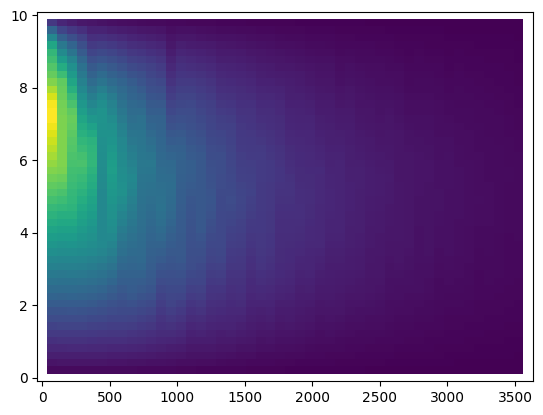

In [17]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_trail1.png')

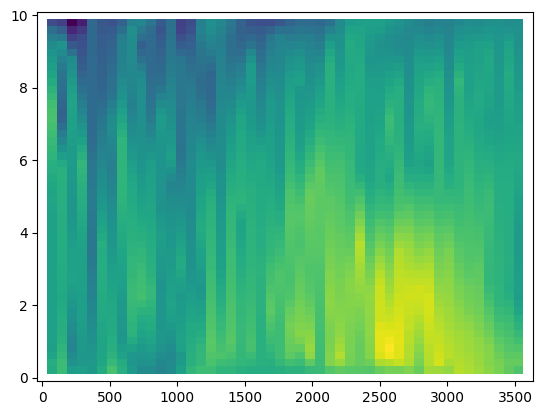

In [18]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_trail1.png')

In [19]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_linearic_1h_quasi.npz")
    x_test, y_test = get_data("heat_test_linearic_1h_gridsample.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512, 1024], [2, 512, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None)
    return model, data

In [20]:
model_linear, data_linear = train_DeepONet()

Compiling model...
'compile' took 0.002102 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [7.89e+05]    [1.59e+06]    [9.10e+02]    
1000      [2.71e-01]    [5.23e-01]    [5.29e-01]    
2000      [5.67e-01]    [1.07e+00]    [7.65e-01]    
3000      [1.60e-01]    [3.19e-01]    [4.21e-01]    
4000      [1.35e-01]    [2.77e-01]    [3.87e-01]    
5000      [6.84e-03]    [4.37e-02]    [1.63e-01]    
6000      [2.28e-01]    [4.98e-01]    [5.39e-01]    
7000      [5.32e-02]    [1.38e-01]    [2.80e-01]    
8000      [1.00e-01]    [2.08e-01]    [3.32e-01]    
9000      [6.04e-02]    [1.30e-01]    [2.67e-01]    
10000     [2.51e-02]    [5.99e-02]    [1.80e-01]    
11000     [1.28e-03]    [5.28e-03]    [6.49e-02]    
12000     [2.56e-03]    [8.52e-03]    [7.49e-02]    
13000     [4.34e-02]    [8.49e-02]    [2.52e-01]    
14000     [1.28e-01]    [2.51e-01]    [4.17e-01]    
15000     [1.69e-04]    [9.00e-04]    [3.88e-02]    
16000     [5.14e-04]    [1.69e-03]

In [21]:
y_pred = model_linear.predict(data_linear.train_x)
data_train_x = data_linear.train_x
data_train_y = data_linear.train_y

In [22]:
y_predict_arr = y_pred[2].reshape(6000, 1)
xt_arr = data_train_x[1]
y_true_arr = data_train_y[2].reshape(6000, 1)
np.savetxt("test_heat_trail1.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [23]:
y_pred.shape

(1000, 6000)

In [24]:
y_pred[1]

array([ 0.00789416, -0.00096399, -0.01370478, ..., -0.01171064,
       -0.0121932 ,  0.00633591], dtype=float32)

In [25]:
y_pred[1].shape

(6000,)

In [26]:
data_train_y[1]

array([0.0092136 , 0.0001987 , 0.00056903, ..., 0.00060807, 0.00116129,
       0.0067792 ], dtype=float32)

In [27]:
data = np.genfromtxt("test_heat_trail1.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

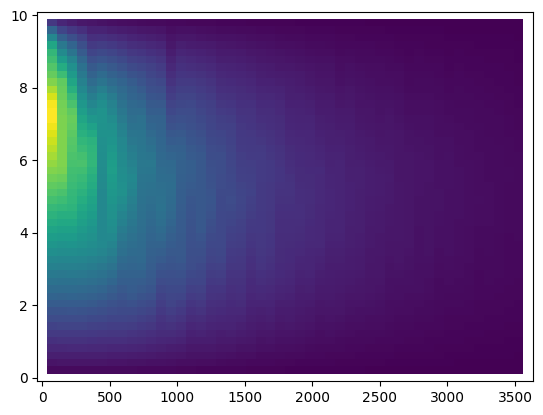

In [28]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_trail1.png')

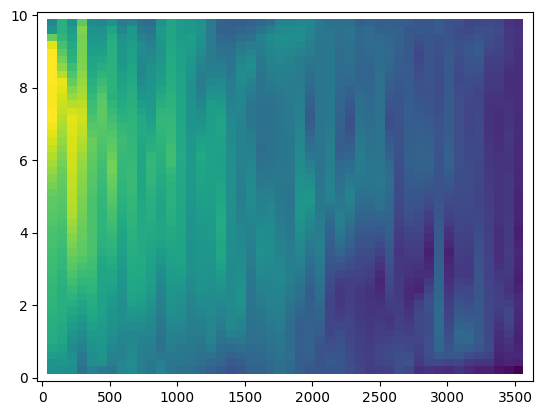

In [29]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_trail1.png')

In [30]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_linearic_1h_fixed.npz")
    x_test, y_test = get_data("heat_test_linearic_1h_fixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512, 1024], [2, 512, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None)
    return model, data

In [31]:
model_linear, data_linear = train_DeepONet()

Compiling model...
'compile' took 0.002737 s

Training model...



ValueError: in user code:

    File "/home/guest/lizhen001/anaconda3/envs/cryopinn/lib/python3.11/site-packages/deepxde/model.py", line 227, in outputs_losses_test  *
        False, inputs, targets, auxiliary_vars, self.data.losses_test
    File "/home/guest/lizhen001/anaconda3/envs/cryopinn/lib/python3.11/site-packages/deepxde/model.py", line 204, in outputs_losses  *
        outputs_ = self.net(inputs, training=training)
    File "/home/guest/lizhen001/anaconda3/envs/cryopinn/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_file_w4_d6cj.py", line 12, in tf__call
        x_func = ag__.converted_call(ag__.ld(self).branch, (ag__.ld(x_func),), None, fscope)
    File "/tmp/__autograph_generated_file997hrglw.py", line 40, in tf__call
        ag__.for_stmt(ag__.ld(self).denses, None, loop_body, get_state_1, set_state_1, ('y',), {'iterate_names': 'f'})
    File "/tmp/__autograph_generated_file997hrglw.py", line 38, in loop_body
        y = ag__.converted_call(ag__.ld(f), (ag__.ld(y),), dict(training=ag__.ld(training)), fscope)

    ValueError: Exception encountered when calling layer 'deep_o_net_cartesian_prod_3' (type DeepONetCartesianProd).
    
    in user code:
    
        File "/home/guest/lizhen001/anaconda3/envs/cryopinn/lib/python3.11/site-packages/deepxde/nn/tensorflow/deeponet.py", line 63, in call  *
            x_func = self.branch(x_func)
        File "/home/guest/lizhen001/anaconda3/envs/cryopinn/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/tmp/__autograph_generated_file997hrglw.py", line 40, in tf__call
            ag__.for_stmt(ag__.ld(self).denses, None, loop_body, get_state_1, set_state_1, ('y',), {'iterate_names': 'f'})
        File "/tmp/__autograph_generated_file997hrglw.py", line 38, in loop_body
            y = ag__.converted_call(ag__.ld(f), (ag__.ld(y),), dict(training=ag__.ld(training)), fscope)
    
        ValueError: Exception encountered when calling layer 'fnn_6' (type FNN).
        
        in user code:
        
            File "/home/guest/lizhen001/anaconda3/envs/cryopinn/lib/python3.11/site-packages/deepxde/nn/tensorflow/fnn.py", line 62, in call  *
                y = f(y, training=training)
            File "/home/guest/lizhen001/anaconda3/envs/cryopinn/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "/home/guest/lizhen001/anaconda3/envs/cryopinn/lib/python3.11/site-packages/keras/engine/input_spec.py", line 280, in assert_input_compatibility
                raise ValueError(
        
            ValueError: Input 0 of layer "dense_25" is incompatible with the layer: expected axis -1 of input shape to have value 41, but received input with shape (150, 5)
        
        
        Call arguments received by layer 'fnn_6' (type FNN):
          • inputs=tf.Tensor(shape=(150, 5), dtype=float32)
          • training=False
    
    
    Call arguments received by layer 'deep_o_net_cartesian_prod_3' (type DeepONetCartesianProd):
      • inputs=('tf.Tensor(shape=(150, 5), dtype=float32)', 'tf.Tensor(shape=(1005, 2), dtype=float32)')
      • training=False


In [32]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_linearic_1h_fixed.npz")
    x_test, y_test = get_data("heat_test_linearic_1h_fixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512, 1024], [2, 512, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None)
    return model, data

In [33]:
model_linear, data_linear = train_DeepONet()

Compiling model...
'compile' took 0.002245 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.02e+02]    [5.59e+02]    [8.20e+00]    
1000      [1.40e-01]    [1.56e-01]    [1.41e-01]    
2000      [2.98e-02]    [3.31e-02]    [6.43e-02]    
3000      [3.09e-02]    [3.45e-02]    [6.38e-02]    
4000      [1.19e-03]    [1.33e-03]    [1.30e-02]    
5000      [1.02e-02]    [1.13e-02]    [3.75e-02]    
6000      [2.80e-04]    [3.13e-04]    [6.75e-03]    
7000      [4.91e-03]    [5.43e-03]    [2.63e-02]    
8000      [1.37e-03]    [1.52e-03]    [1.43e-02]    
9000      [1.14e-04]    [1.27e-04]    [4.39e-03]    
10000     [1.69e-04]    [1.89e-04]    [5.91e-03]    
11000     [2.02e-02]    [2.24e-02]    [5.29e-02]    
12000     [4.81e-05]    [5.33e-05]    [3.29e-03]    
13000     [7.21e-05]    [8.03e-05]    [3.71e-03]    
14000     [8.54e-02]    [9.48e-02]    [1.09e-01]    
15000     [4.22e-05]    [4.74e-05]    [2.98e-03]    
16000     [3.95e-05]    [4.41e-05]

In [34]:
y_pred = model_linear.predict(data_linear.train_x)
data_x = data_linear.test_x
data_y = data_linear.test_y

In [35]:
y_predict_arr = y_pred[2].reshape(8241, 1)
xt_arr = data_x[1]
y_true_arr = data_y[2].reshape(8241, 1)
np.savetxt("test_heat_trail1.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [36]:
data = np.genfromtxt("test_heat_trail1.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

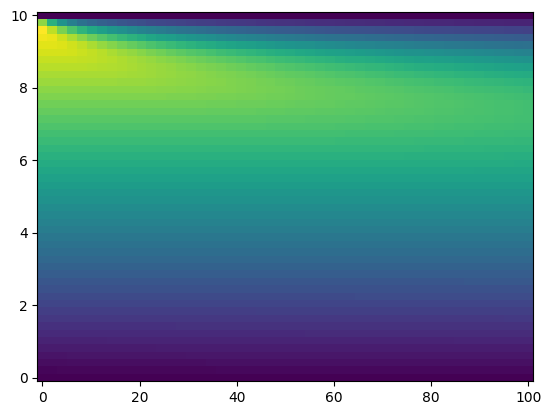

In [37]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_trail1.png')

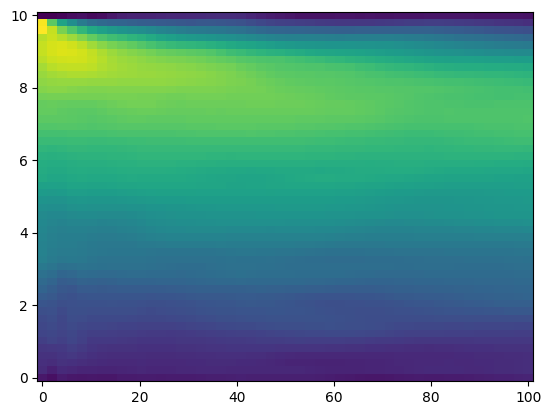

In [38]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_trail1.png')

In [39]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_100s.npz")
    x_test, y_test = get_data("heat_test_nonlinear_100s.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512, 1024], [2, 512, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None)
    return model, data

In [40]:
model_linear, data_linear = train_DeepONet()

Compiling model...
'compile' took 0.002172 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.06e+02]    [2.51e+02]    [8.54e+00]    
1000      [1.91e-01]    [9.39e-02]    [1.59e-01]    
2000      [6.77e-03]    [2.38e-03]    [3.29e-02]    
3000      [6.40e-03]    [4.09e-03]    [4.40e-02]    
4000      [1.78e-02]    [1.02e-02]    [5.52e-02]    
5000      [1.02e-02]    [5.89e-03]    [4.18e-02]    
6000      [7.85e-04]    [3.75e-04]    [1.46e-02]    
7000      [2.96e-04]    [2.49e-04]    [1.25e-02]    
8000      [2.53e-04]    [2.08e-04]    [1.14e-02]    
9000      [1.67e-03]    [7.02e-04]    [1.73e-02]    
10000     [4.28e-03]    [3.09e-03]    [3.71e-02]    
11000     [4.82e-02]    [2.22e-02]    [7.73e-02]    
12000     [1.62e-04]    [1.25e-04]    [8.75e-03]    
13000     [1.82e-04]    [1.27e-04]    [9.38e-03]    
14000     [1.56e-04]    [9.94e-05]    [8.32e-03]    
15000     [2.59e-04]    [1.82e-04]    [1.12e-02]    
16000     [9.96e-05]    [6.63e-05]

In [41]:
y_pred = model_linear.predict(data_linear.train_x)
data_x = data_linear.test_x
data_y = data_linear.test_y

In [42]:
y_predict_arr = y_pred[2].reshape(8241, 1)
xt_arr = data_x[1]
y_true_arr = data_y[2].reshape(8241, 1)
np.savetxt("test_heat_trail2.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [43]:
data = np.genfromtxt("test_heat_trail2.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

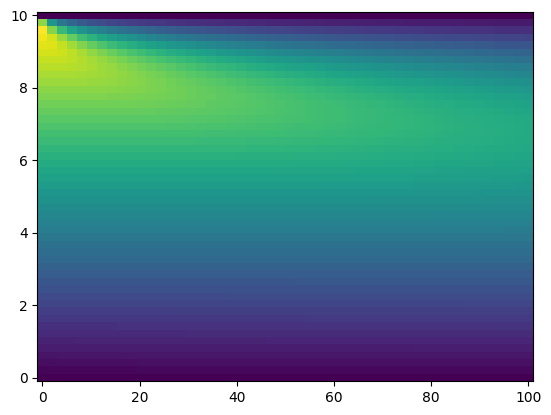

In [44]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_trail2.png')

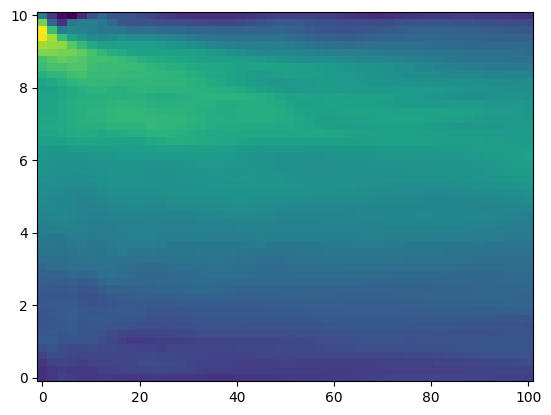

In [45]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_trail2.png')

In [46]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_whole_1h.npz")
    x_test, y_test = get_data("heat_test_whole_1h.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "tanh", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [48]:
ef train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1hfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1hfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)

    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "tanh", "Glorot normal"
    )

    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=30000, batch_size=None)

    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

SyntaxError: invalid syntax (<ipython-input-48-5e4a37a16ea9>, line 1)

In [49]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1hfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1hfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "tanh", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=30000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [51]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_whole_100s.npz")
    x_test, y_test = get_data("heat_test_whole_100s.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "tanh", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=30000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [53]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_whole_100s.npz")
    x_test, y_test = get_data("heat_test_whole_100s.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "tanh", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=30000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [54]:
list_return = train_DeepONet()

Compiling model...
'compile' took 0.002286 s

Training model...

0         [1.79e+01]    [9.42e+00]    [1.75e+00]    
1000      [5.65e-01]    [2.97e-01]    [2.90e-01]    
2000      [3.71e-01]    [1.86e-01]    [2.16e-01]    
3000      [3.00e-01]    [1.52e-01]    [1.94e-01]    
4000      [4.89e-01]    [3.23e-01]    [3.72e-01]    
5000      [2.14e-01]    [1.17e-01]    [1.88e-01]    
6000      [1.43e-01]    [8.41e-02]    [1.84e-01]    
7000      [4.91e-02]    [2.70e-02]    [8.84e-02]    
8000      [2.79e-02]    [1.61e-02]    [7.19e-02]    
9000      [1.01e+01]    [1.08e+01]    [9.05e+00]    
10000     [1.41e+00]    [8.12e-01]    [1.25e+00]    
11000     [1.16e+00]    [6.45e-01]    [9.45e-01]    
12000     [9.12e-01]    [4.94e-01]    [7.98e-01]    
13000     [8.01e-01]    [4.32e-01]    [7.19e-01]    
14000     [6.07e+00]    [5.41e+00]    [2.41e+00]    
15000     [6.72e-01]    [3.69e-01]    [6.05e-01]    
16000     [6.12e-01]    [3.34e-01]    [5.60e-01]    
17000     [4.50e-01]    [2.64e-01]

In [55]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_whole_1s.npz")
    x_test, y_test = get_data("heat_test_whole_1s.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "tanh", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=30000, batch_size=None)
    y_pred = model.predict(data.test_x)
    list_return = [y_pred, data.test_x, data.test_y]
    return list_return

In [56]:
list_return = train_DeepONet()

Compiling model...
'compile' took 0.003159 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.52e-01]    [8.28e-02]    [1.53e+00]    
1000      [1.04e-02]    [5.60e-03]    [4.11e-01]    
2000      [2.45e-01]    [2.03e-01]    [9.22e+00]    
3000      [8.60e-02]    [7.04e-02]    [5.50e+00]    
4000      [3.46e-02]    [2.69e-02]    [3.20e+00]    
5000      [1.84e-02]    [1.34e-02]    [2.06e+00]    
6000      [3.51e-01]    [2.09e-01]    [3.32e+00]    
7000      [9.58e-03]    [6.25e-03]    [1.12e+00]    
8000      [7.15e-03]    [4.33e-03]    [8.81e-01]    
9000      [6.09e-03]    [3.69e-03]    [8.04e-01]    
10000     [1.93e-01]    [1.99e-01]    [1.23e+01]    
11000     [8.31e+00]    [7.62e+00]    [3.12e+01]    
12000     [8.33e-02]    [7.03e-02]    [4.92e+00]    
13000     [2.03e+00]    [1.63e+00]    [1.56e+01]    
14000     [9.47e-02]    [9.96e-02]    [8.20e+00]    
15000     [2.39e-02]    [2.04e-02]    [2.64e+00]    
16000     [2.09e-01]    [1.94e-01]

In [57]:
y_predict_arr = list_return[0][2].reshape(3000, 1)
xt_arr = list_return[1][1]
y_true_arr = list_return[2][2].reshape(3000, 1)
np.savetxt("test_heat_randomgrid1s.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [58]:
data = np.genfromtxt("test_heat_randomgrid1s.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

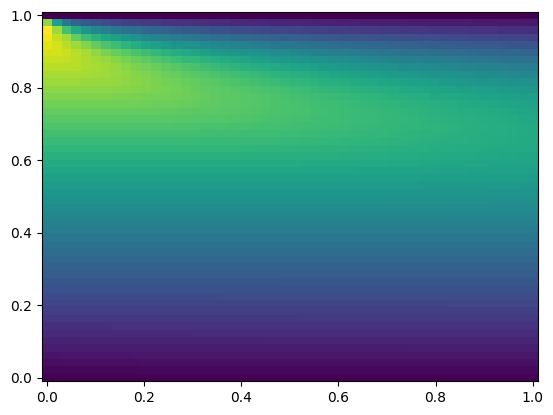

In [59]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_randomgrid1s.png')

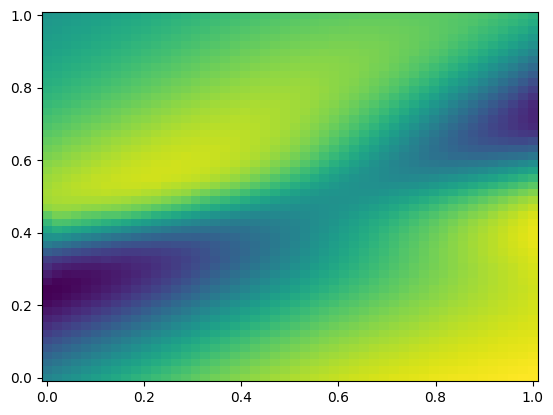

In [60]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_randomgrid1s.png')

In [61]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1hfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1hfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "tanh", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=30000, batch_size=None)
    return model, data

In [62]:
def train_DeepONet(nx=21):
    x_train, y_train = get_data("heat_train_nonlinear_1hfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1hfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "tanh", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=30000, batch_size=None)
    return model, data

In [64]:
def train_DeepONet(nx=21):
    x_train, y_train = get_data("heat_train_nonlinear_1hfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1hfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 1024], [2, 512, 512, 512, 1024], "tanh", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=30000, batch_size=None)
    return model, data

In [66]:
def train_DeepONet(nx=21):
    x_train, y_train = get_data("heat_train_nonlinear_1hfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1hfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 1024], [2, 512, 512, 512, 1024], "tanh", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=30000, batch_size=None)
    return model, data

In [67]:
model_nonlinear, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.002823 s

Training model...

0         [2.39e+01]    [1.47e+01]    [6.67e+00]    
1000      [1.65e-01]    [8.25e-02]    [5.58e-01]    
2000      [9.06e-02]    [4.14e-02]    [3.70e-01]    
3000      [1.84e-01]    [1.09e-01]    [6.27e-01]    
4000      [7.05e-02]    [3.46e-02]    [3.54e-01]    
5000      [2.65e-01]    [1.98e-01]    [1.30e+00]    
6000      [6.43e-02]    [3.33e-02]    [3.53e-01]    
7000      [3.96e-01]    [1.69e-01]    [1.01e+00]    
8000      [1.88e-01]    [9.58e-02]    [7.93e-01]    
9000      [1.57e-01]    [7.97e-02]    [6.53e-01]    
10000     [1.06e-01]    [4.86e-02]    [5.97e-01]    
11000     [1.09e-01]    [5.63e-02]    [6.92e-01]    
12000     [5.43e-02]    [2.67e-02]    [4.65e-01]    
13000     [6.11e-01]    [4.34e-01]    [1.45e+00]    
14000     [1.93e-01]    [1.32e-01]    [8.07e-01]    
15000     [2.24e-02]    [1.30e-02]    [2.85e-01]    
16000     [2.07e-02]    [1.22e-02]    [2.49e-01]    
17000     [2.14e-02]    [1.25e-02]

In [68]:
y_pred = model_nonlinear.predict(data_nonlinear.train_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

y_predict_arr = y_pred[2].reshape(15141, 1)
xt_arr = data_x[1]
y_true_arr = data_y[2].reshape(15141, 1)
np.savetxt("test_heat_nonlinear_1hfixed.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [69]:
data = np.genfromtxt("test_heat_nonlinear_1hfixed.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

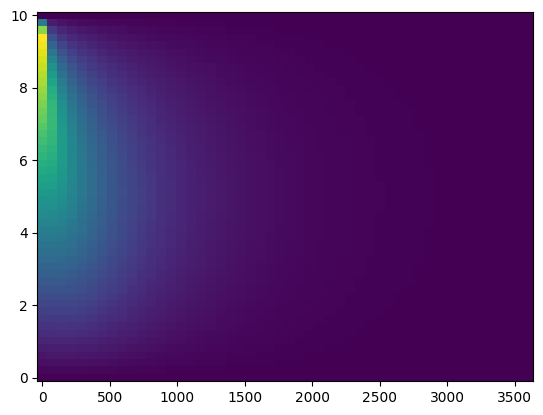

In [70]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_nonlinear_1hfixed.png')

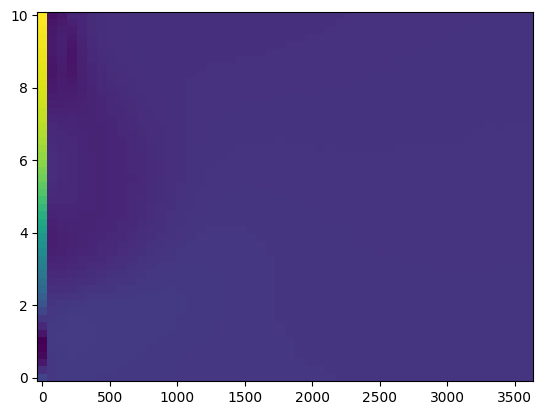

In [71]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_nonlinear_1hfixed.png')

In [72]:
def train_DeepONet(nx=21):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 1024], [2, 512, 512, 512, 1024], "tanh", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=30000, batch_size=None)
    return model, data

In [73]:
model_nonlinear, data_nonlinear = train_DeepONet()

FileNotFoundError: [Errno 2] No such file or directory: 'heat_train_nonlinear_1000sfixed.npz'

In [74]:
def train_DeepONet(nx=21):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 1024], [2, 512, 512, 512, 1024], "tanh", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=30000, batch_size=None)
    return model, data

In [75]:
model_nonlinear, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.002041 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [3.11e+01]    [1.84e+01]    [3.89e+00]    
1000      [4.62e-01]    [2.26e-01]    [4.51e-01]    
2000      [3.37e-01]    [1.64e-01]    [3.81e-01]    
3000      [2.31e-01]    [1.16e-01]    [3.07e-01]    
4000      [3.23e-01]    [1.64e-01]    [3.67e-01]    
5000      [1.27e+00]    [7.43e-01]    [1.44e+00]    
6000      [5.60e-01]    [2.85e-01]    [7.44e-01]    
7000      [4.01e-01]    [2.04e-01]    [5.93e-01]    
8000      [2.04e-01]    [1.08e-01]    [4.62e-01]    
9000      [9.68e-02]    [5.32e-02]    [3.67e-01]    
10000     [7.31e-02]    [4.01e-02]    [3.37e-01]    
11000     [4.31e-02]    [2.36e-02]    [2.59e-01]    
12000     [3.90e-02]    [2.17e-02]    [2.41e-01]    
13000     [1.52e-01]    [8.64e-02]    [3.59e-01]    
14000     [1.99e-02]    [1.14e-02]    [1.62e-01]    
15000     [1.63e-02]    [9.38e-03]    [1.44e-01]    
16000     [1.25e-01]    [8.86e-02]

In [76]:
y_pred = model_nonlinear.predict(data_nonlinear.train_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

y_predict_arr = y_pred[2].reshape(5271, 1)
xt_arr = data_x[1]
y_true_arr = data_y[2].reshape(5271, 1)
np.savetxt("test_heat_nonlinear_1000sfixed.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [77]:
data = np.genfromtxt("test_heat_nonlinear_1000sfixed.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

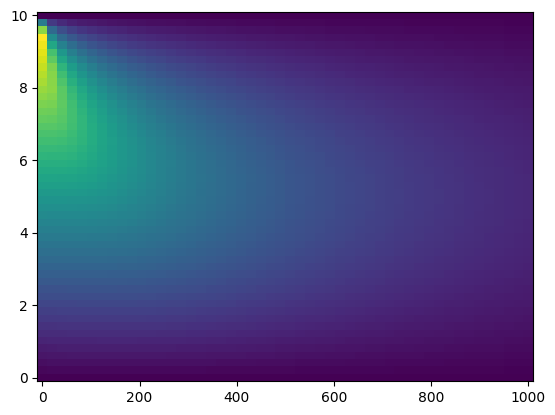

In [78]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_nonlinear_1000sfixed.png')

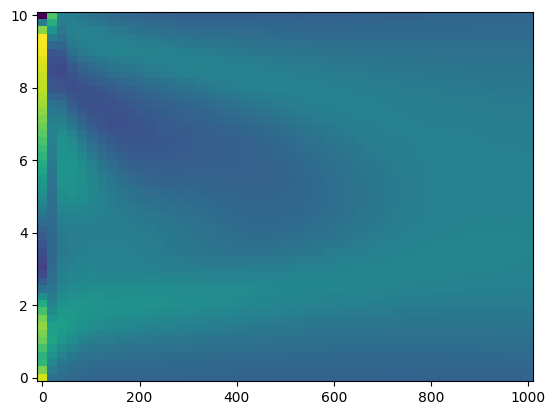

In [79]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_nonlinear_1000sfixed.png')

In [80]:
y_pred[2].shape

(5271,)

In [81]:
y_pred = model_nonlinear.predict(data_nonlinear.train_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

y_predict_arr = y_pred[6].reshape(5271, 1)
xt_arr = data_x[1]
y_true_arr = data_y[6].reshape(5271, 1)
np.savetxt("test_heat_nonlinear_1000sfixed.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [82]:
data = np.genfromtxt("test_heat_nonlinear_1000sfixed.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

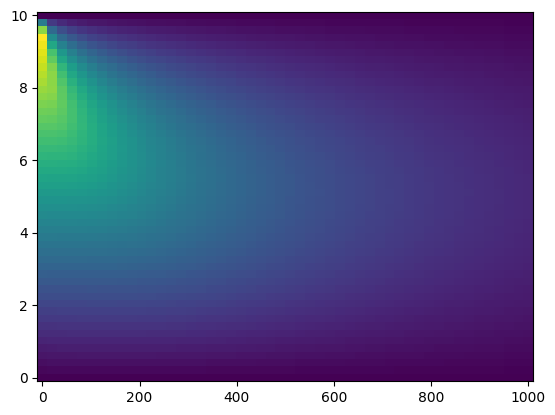

In [83]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_nonlinear_1000sfixed.png')

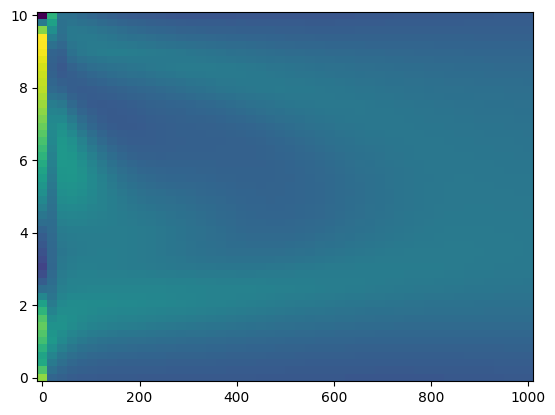

In [84]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_nonlinear_1000sfixed.png')

In [85]:
def train_DeepONet(nx=21):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 1024], [2, 512, 512, 512, 1024], "tanh", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None)
    return model, data

In [86]:
def train_DeepONet(nx=21):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "tanh", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None)
    return model, data

In [88]:
def train_DeepONet(nx=21):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None)
    return model, data

In [89]:
model_nonlinear, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.002339 s

Training model...

0         [1.31e+06]    [7.09e+05]    [7.87e+02]    
1000      [6.36e-01]    [3.24e-01]    [5.22e-01]    
2000      [6.78e-01]    [3.45e-01]    [5.21e-01]    
3000      [1.82e-01]    [8.71e-02]    [2.47e-01]    
4000      [5.65e-02]    [2.68e-02]    [1.50e-01]    
5000      [1.00e-01]    [4.85e-02]    [2.03e-01]    
6000      [7.74e-02]    [3.87e-02]    [1.86e-01]    
7000      [5.54e-02]    [2.86e-02]    [1.59e-01]    
8000      [5.88e-03]    [2.62e-03]    [6.28e-02]    
9000      [1.74e-01]    [1.05e-01]    [3.16e-01]    
10000     [2.51e-02]    [1.11e-02]    [1.16e-01]    
11000     [7.62e-03]    [5.26e-03]    [8.56e-02]    
12000     [5.50e+00]    [2.98e+00]    [1.89e+00]    
13000     [4.68e-03]    [3.60e-03]    [1.09e-01]    
14000     [3.41e-03]    [1.62e-03]    [5.49e-02]    
15000     [5.31e-03]    [2.21e-03]    [5.87e-02]    
16000     [3.67e-02]    [1.62e-02]    [1.21e-01]    
17000     [2.76e-03]    [1.57e-03]

In [90]:
y_pred = model_nonlinear.predict(data_nonlinear.train_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

y_predict_arr = y_pred[6].reshape(5271, 1)
xt_arr = data_x[1]
y_true_arr = data_y[6].reshape(5271, 1)
np.savetxt("test_heat_nonlinear_1000sfixed.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [91]:
data = np.genfromtxt("test_heat_nonlinear_1000sfixed.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

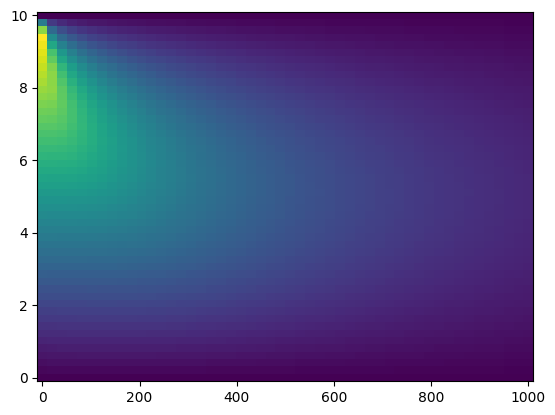

In [92]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_nonlinear_1000sfixed.png')

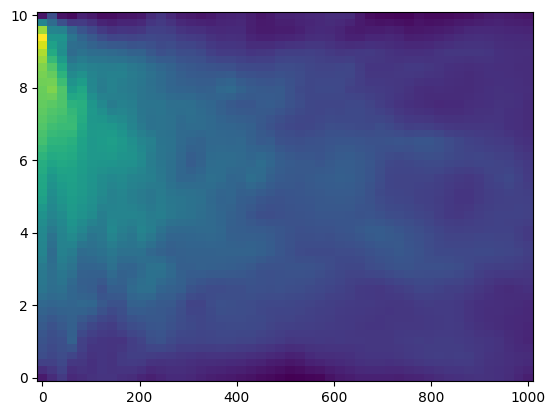

In [93]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_nonlinear_1000sfixed.png')

In [94]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None)
    return model, data

In [95]:
model_nonlinear, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.002267 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.00e+06]    [1.08e+06]    [9.60e+02]    
1000      [6.42e-01]    [3.29e-01]    [5.25e-01]    
2000      [1.00e+00]    [5.31e-01]    [6.34e-01]    
3000      [1.41e-01]    [6.84e-02]    [2.36e-01]    
4000      [4.85e-02]    [2.27e-02]    [1.72e-01]    
5000      [6.35e-03]    [3.82e-03]    [1.00e-01]    
6000      [7.74e-02]    [3.99e-02]    [2.98e-01]    
7000      [3.27e-02]    [1.86e-02]    [1.53e-01]    
8000      [2.53e-02]    [1.17e-02]    [1.21e-01]    
9000      [1.06e-01]    [5.21e-02]    [2.15e-01]    
10000     [9.17e-03]    [3.73e-03]    [6.73e-02]    
11000     [2.78e-02]    [1.52e-02]    [1.16e-01]    
12000     [1.09e-01]    [5.19e-02]    [2.11e-01]    
13000     [4.83e-01]    [2.42e-01]    [4.84e-01]    
14000     [2.98e-01]    [1.38e-01]    [3.76e-01]    
15000     [1.24e-01]    [5.59e-02]    [2.52e-01]    
16000     [1.43e-02]    [7.15e-03]

In [96]:
y_pred = model_nonlinear.predict(data_nonlinear.train_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

y_predict_arr = y_pred[5].reshape(10291, 1)
xt_arr = data_x[1]
y_true_arr = data_y[5].reshape(10291, 1)
np.savetxt("test_heat_nonlinear_1000sfixed.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [97]:
data = np.genfromtxt("test_heat_nonlinear_1000sfixed.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

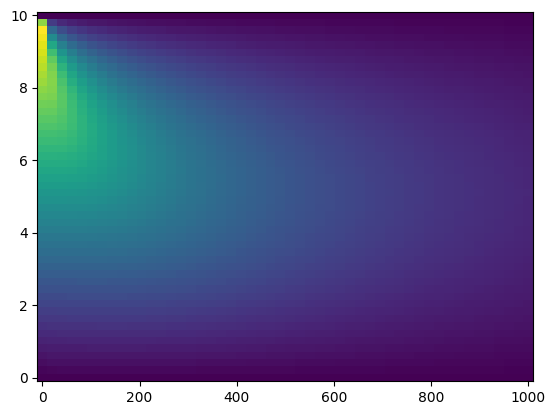

In [98]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_nonlinear_1000sfixed.png')

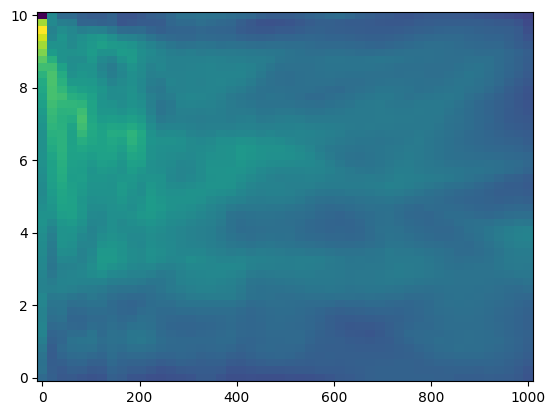

In [99]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_nonlinear_1000sfixed.png')

In [100]:
?dde.train

Object `dde.train` not found.


In [101]:
?dde.Model

Init signature: dde.Model(data, net)
Docstring:     
A ``Model`` trains a ``NN`` on a ``Data``.

Args:
    data: ``deepxde.data.Data`` instance.
    net: ``deepxde.nn.NN`` instance.
File:           ~/anaconda3/envs/cryopinn/lib/python3.11/site-packages/deepxde/model.py
Type:           type
Subclasses:     

In [102]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= tf.keras.callbacks.EarlyStopping(
    monitor='Test loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
))
    return model, data

In [103]:
model_nonlinear, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.002410 s



TypeError: 'EarlyStopping' object is not iterable

In [104]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= [tf.keras.callbacks.EarlyStopping(
    monitor='Test loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)])
    return model, data

In [105]:
model_nonlinear, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.001966 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.31e+06]    [7.09e+05]    [7.88e+02]    


TypeError: Callback.on_epoch_begin() missing 1 required positional argument: 'epoch'

In [106]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= [tf.keras.callbacks.EarlyStopping(
    monitor='Test loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
    )])
    return model, data

In [107]:
model_nonlinear, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.002066 s

Training model...

0         [1.31e+06]    [7.09e+05]    [7.88e+02]    


TypeError: Callback.on_epoch_begin() missing 1 required positional argument: 'epoch'

In [108]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= [tf.keras.callbacks.EarlyStopping(
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
    )])
    return model, data

In [109]:
model_nonlinear, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.001857 s

Training model...

0         [1.31e+06]    [7.09e+05]    [7.88e+02]    


TypeError: Callback.on_epoch_begin() missing 1 required positional argument: 'epoch'

In [110]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= [tf.keras.callbacks.EarlyStopping(
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    epoch=0
    )])
    return model, data

In [111]:
model_nonlinear, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.001958 s



TypeError: EarlyStopping.__init__() got an unexpected keyword argument 'epoch'

In [112]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss_test', patience=5, restore_best_weights=True)
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= [callback])
    return model, data

In [113]:
model_nonlinear, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.001962 s

Training model...

0         [1.31e+06]    [7.09e+05]    [7.88e+02]    


TypeError: Callback.on_epoch_begin() missing 1 required positional argument: 'epoch'

In [114]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callback = dde.callbacks.EarlyStopping(monitor='loss_test', patience=5, restore_best_weights=True)
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= [callback])
    return model, data

In [115]:
model_nonlinear, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.001997 s



TypeError: EarlyStopping.__init__() got an unexpected keyword argument 'restore_best_weights'

In [116]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callback = dde.callbacks.EarlyStopping(monitor='loss_test', patience=5)
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= [callback])
    return model, data

In [117]:
model_nonlinear, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.001942 s

Training model...

0         [1.31e+06]    [7.09e+05]    [7.88e+02]    
Epoch 6: early stopping

Best model at step 0:
  train loss: 1.31e+06
  test loss: 7.09e+05
  test metric: [7.88e+02]

'train' took 2.735384 s



In [118]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callback = dde.callbacks.EarlyStopping(monitor='loss_test', patience=1000)
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= [callback])
    return model, data

In [120]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=1000), 
                 dde.callbacks.ModelCheckpoint(save_better_only=True, period=50, monitor='test loss')]
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= callbacks)
    return model, data

In [121]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=1000), 
                 dde.callbacks.ModelCheckpoint(save_better_only=True, period=50, monitor='test loss')]
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= callbacks)
    return model, data

In [122]:
model_nonlinear, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.002255 s



TypeError: ModelCheckpoint.__init__() missing 1 required positional argument: 'filepath'

In [123]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=1000), 
                 dde.callbacks.ModelCheckpoint(filepath='best_model', save_better_only=True, period=50, monitor='test loss')]
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= callbacks)
    model.restore('best_model')
    return model, data

In [124]:
model_nonlinear, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.001949 s

Training model...

0         [1.31e+06]    [7.09e+05]    [7.88e+02]    
1000      [1.22e+00]    [6.27e-01]    [7.80e-01]    
2000      [3.65e-01]    [1.80e-01]    [3.79e-01]    
3000      [2.50e-02]    [1.13e-02]    [1.51e-01]    
4000      [4.58e-02]    [2.73e-02]    [1.77e-01]    
Epoch 4000: early stopping

Best model at step 3000:
  train loss: 2.50e-02
  test loss: 1.13e-02
  test metric: [1.51e-01]

'train' took 157.906445 s



NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for best_model

In [125]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=8000), 
                 dde.callbacks.ModelCheckpoint(filepath='best_model', save_better_only=True, period=500, monitor='test loss')]
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= callbacks)
    model.restore('best_model')
    return model, data

In [127]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=4000), 
                 dde.callbacks.ModelCheckpoint(filepath='best_model', save_better_only=True, period=500, monitor='test loss')]
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= callbacks)
    return model, data

In [128]:
model, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.002255 s

Training model...

0         [1.31e+06]    [7.09e+05]    [7.88e+02]    
1000      [1.22e+00]    [6.27e-01]    [7.80e-01]    
2000      [3.65e-01]    [1.80e-01]    [3.79e-01]    
3000      [2.50e-02]    [1.13e-02]    [1.51e-01]    
4000      [4.58e-02]    [2.73e-02]    [1.77e-01]    
5000      [1.99e-01]    [1.00e-01]    [3.36e-01]    
6000      [2.40e-01]    [1.22e-01]    [3.65e-01]    
7000      [6.52e-02]    [3.76e-02]    [1.97e-01]    
Epoch 7000: early stopping

Best model at step 3000:
  train loss: 2.50e-02
  test loss: 1.13e-02
  test metric: [1.51e-01]

'train' took 263.661204 s



In [129]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=8000), 
                 dde.callbacks.ModelCheckpoint(filepath='best_model', save_better_only=True, period=500, monitor='test loss')]
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= callbacks)
    return model, data

In [130]:
model, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.002314 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.31e+06]    [7.09e+05]    [7.88e+02]    
1000      [1.22e+00]    [6.27e-01]    [7.80e-01]    
2000      [3.65e-01]    [1.80e-01]    [3.79e-01]    
3000      [2.50e-02]    [1.13e-02]    [1.51e-01]    
4000      [4.58e-02]    [2.73e-02]    [1.77e-01]    
5000      [1.99e-01]    [1.00e-01]    [3.36e-01]    
6000      [2.40e-01]    [1.22e-01]    [3.65e-01]    
7000      [6.52e-02]    [3.76e-02]    [1.97e-01]    
8000      [6.87e-02]    [3.88e-02]    [1.91e-01]    
9000      [6.78e-02]    [3.30e-02]    [1.90e-01]    
10000     [1.18e-02]    [7.04e-03]    [8.81e-02]    
11000     [4.01e-01]    [2.00e-01]    [4.13e-01]    
12000     [1.03e-02]    [6.38e-03]    [1.08e-01]    
13000     [1.07e-02]    [6.42e-03]    [8.96e-02]    
14000     [1.82e-02]    [7.77e-03]    [9.05e-02]    
15000     [1.75e-02]    [7.30e-03]    [8.03e-02]    
16000     [7.19e-02]    [3.07e-02]

In [131]:
model_nonlinear = model.restore('best_model-18000')

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for best_model-18000

In [132]:
model_nonlinear = model.restore('best_model-18000.ckpt.data-00000-of-00001')

2023-09-01 17:13:01.801633: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open best_model-18000.ckpt.data-00000-of-00001: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


OSError: Unable to open file (file signature not found)

In [133]:
model_nonlinear = model.restore('best_model-18000.ckpt')

In [134]:
y_pred = model_nonlinear.predict(data_nonlinear.train_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

y_predict_arr = y_pred[5].reshape(10521, 1)
xt_arr = data_x[1]
y_true_arr = data_y[5].reshape(10521, 1)
np.savetxt("test_heat_nonlinear_1000sfixed.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

AttributeError: 'NoneType' object has no attribute 'predict'

In [135]:
y_pred = model_nonlinear.predict(data_nonlinear.train_x)

AttributeError: 'NoneType' object has no attribute 'predict'

In [136]:
model_nonlinear = model.restore('best_model-18000.ckpt.index')

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


AssertionError: Some objects had attributes which were not restored: 
    <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.11043213], dtype=float32)>: ['Variable']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_62/dense_233/kernel:0' shape=(21, 512) dtype=float32, numpy=
array([[-0.0221129 , -0.07267672, -0.09004016, ..., -0.09292237,
        -0.04389255, -0.02105541],
       [ 0.02982996, -0.01535289,  0.10724518, ..., -0.08055996,
         0.0536091 ,  0.00730347],
       [ 0.0001849 ,  0.07867128, -0.08787552, ..., -0.06622265,
         0.02476167,  0.015515  ],
       ...,
       [ 0.02567238,  0.03781497, -0.00928568, ..., -0.10764959,
        -0.01843258, -0.02896973],
       [-0.1011681 ,  0.04294436, -0.01635197, ..., -0.08474896,
        -0.07429823, -0.07823861],
       [ 0.07317323,  0.00297001, -0.09197936, ..., -0.12764476,
        -0.02560649, -0.03313093]], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_62/dense_233/kernel']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_62/dense_233/bias:0' shape=(512,) dtype=float32, numpy=
array([-0.01500897,  0.00711265, -0.00771068, -0.00734649,  0.0052864 ,
       -0.01095807, -0.00097508,  0.        ,  0.        , -0.00952338,
        0.        , -0.00834515,  0.        ,  0.        ,  0.        ,
        0.        , -0.00022902,  0.00343863,  0.        ,  0.        ,
        0.        ,  0.        , -0.00457343,  0.        , -0.00933656,
        0.        , -0.00681737, -0.01527169,  0.        ,  0.00277645,
        0.        , -0.00600062,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.00521255,  0.00622133,  0.        ,
       -0.01001629,  0.00775711,  0.        ,  0.        ,  0.00530575,
        0.        ,  0.        , -0.00944277,  0.        ,  0.        ,
       -0.0027499 ,  0.        ,  0.        ,  0.00700459, -0.00478821,
       -0.00761212, -0.00891401,  0.        , -0.00922284, -0.00269236,
        0.        ,  0.00547673, -0.00840885, -0.00294765,  0.00157681,
        0.        ,  0.        , -0.01092446, -0.01082158,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.00057551,
        0.        ,  0.        , -0.00739047,  0.00935624, -0.0081071 ,
        0.        , -0.00909702, -0.00847248,  0.        ,  0.00437333,
       -0.00649734, -0.00040431,  0.        , -0.00589225, -0.01024762,
       -0.00509216, -0.01015995,  0.00896951,  0.        ,  0.00332975,
       -0.01193594, -0.01196077, -0.0036111 , -0.00829589, -0.00653455,
        0.00043239, -0.00943503, -0.01087741, -0.010533  ,  0.        ,
       -0.00837444, -0.00501434, -0.00042245,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.00855851, -0.00819947,
       -0.00712821, -0.00866485, -0.00267759,  0.        ,  0.        ,
        0.00221136,  0.        ,  0.        , -0.00347882,  0.        ,
        0.        , -0.00430056, -0.00282405, -0.00604191,  0.        ,
       -0.01047047, -0.00703702,  0.        , -0.0096469 ,  0.        ,
        0.        , -0.01031836,  0.        ,  0.00362813,  0.        ,
        0.        , -0.00647177,  0.00261162,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.00600062,
       -0.00983565,  0.00376384,  0.        ,  0.        ,  0.        ,
        0.        , -0.00845324,  0.00478218, -0.00826154, -0.00848226,
        0.        , -0.00348581,  0.        ,  0.        ,  0.        ,
        0.        , -0.00534796, -0.00816484,  0.        , -0.00310214,
        0.        , -0.00842091, -0.00202268, -0.00595993, -0.00335647,
       -0.00024819, -0.00858905,  0.00111931,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.00631552,  0.        ,
        0.        , -0.00278536,  0.00959814,  0.        , -0.01023115,
        0.        ,  0.        ,  0.        ,  0.        , -0.00538877,
        0.        ,  0.        ,  0.        , -0.00500561, -0.0057944 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.01444806, -0.00603993,  0.00600657,  0.        , -0.00840907,
       -0.0056976 , -0.00335606,  0.00784684,  0.        ,  0.        ,
       -0.00896173,  0.        , -0.00949158,  0.        ,  0.        ,
        0.        ,  0.        , -0.00980074,  0.        ,  0.        ,
        0.        ,  0.00303363,  0.        , -0.00858017, -0.00295324,
        0.        ,  0.        ,  0.00343344,  0.        ,  0.        ,
        0.        ,  0.        ,  0.0053711 , -0.00565832, -0.00975066,
       -0.00956912,  0.        , -0.00174317, -0.00366513,  0.        ,
        0.        ,  0.        , -0.00351572,  0.00186237, -0.00877199,
       -0.00787926, -0.00634461,  0.        , -0.01639276,  0.        ,
       -0.00934917, -0.01334052,  0.        , -0.00857151,  0.        ,
        0.00538777,  0.00652406,  0.        ,  0.        ,  0.        ,
       -0.00997324, -0.0020025 ,  0.        , -0.00381617, -0.00303342,
        0.        ,  0.        , -0.00833349,  0.        ,  0.        ,
        0.        , -0.00156607,  0.        , -0.00789208,  0.        ,
       -0.01191165,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.00054609,  0.        ,  0.        ,  0.02074564, -0.01023438,
        0.00128205, -0.01108758, -0.01267546,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.00345295,  0.00861286, -0.00407169,  0.        ,
       -0.00688974, -0.0086015 ,  0.        ,  0.        , -0.02675756,
        0.        , -0.01050805,  0.00409891, -0.01114422,  0.        ,
        0.        , -0.00941436,  0.00225424,  0.        ,  0.        ,
        0.        ,  0.        , -0.01316237, -0.00827693, -0.00850881,
        0.        ,  0.        ,  0.        , -0.00864783,  0.        ,
       -0.0054035 ,  0.        ,  0.        ,  0.00370857,  0.        ,
        0.        , -0.00555712, -0.00980932, -0.00234121,  0.        ,
        0.        ,  0.        ,  0.        , -0.00600062,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00918445, -0.00098001,
        0.        ,  0.        ,  0.        ,  0.01210873,  0.        ,
        0.        ,  0.        , -0.00523154, -0.00803248,  0.        ,
        0.00350463,  0.        , -0.00830933, -0.00494127,  0.        ,
       -0.00188659, -0.00916348,  0.        ,  0.        , -0.00242314,
       -0.00499158, -0.00600062, -0.00792245,  0.00433909,  0.        ,
       -0.00856997,  0.01667356,  0.        , -0.00483455,  0.        ,
       -0.00759397, -0.00976652, -0.00731563,  0.        ,  0.        ,
       -0.00939081,  0.        , -0.00920131, -0.00600062, -0.01063739,
       -0.00023909, -0.00608792, -0.01093983, -0.00877411,  0.        ,
        0.        ,  0.        , -0.00895241, -0.00940072, -0.00164248,
       -0.00746887,  0.        ,  0.        , -0.00331794,  0.        ,
        0.        ,  0.        , -0.00489332,  0.        ,  0.        ,
       -0.00747456, -0.00310785, -0.01011827,  0.        , -0.00886575,
       -0.00039479,  0.00420139, -0.01015303, -0.00826983, -0.01153156,
       -0.00972006, -0.00947418, -0.00417648,  0.        ,  0.        ,
        0.        , -0.00870567,  0.        , -0.01493474,  0.        ,
        0.        ,  0.        ,  0.00028028,  0.        ,  0.        ,
        0.        ,  0.        , -0.00767029,  0.        ,  0.        ,
        0.        , -0.00053529, -0.00486528,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.00403498, -0.00100137,
       -0.00717055,  0.        ,  0.        , -0.01138028,  0.        ,
       -0.01007134,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.00716967, -0.00258054,  0.        ,  0.        , -0.00896057,
       -0.00271346,  0.        , -0.00734085,  0.        ,  0.        ,
        0.00827637,  0.        , -0.00636033, -0.00620708,  0.        ,
        0.        , -0.00722409,  0.00053995,  0.        ,  0.        ,
        0.        , -0.00774142, -0.00482806,  0.        ,  0.        ,
        0.        ,  0.        , -0.00670569,  0.        , -0.00862117,
        0.        ,  0.        ,  0.        ,  0.        ,  0.00584444,
        0.        ,  0.00839291, -0.00874626, -0.00454814,  0.        ,
        0.        , -0.00812867,  0.00780542, -0.00779177,  0.        ,
       -0.00471187,  0.        ], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_62/dense_233/bias']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_62/dense_234/kernel:0' shape=(512, 1024) dtype=float32, numpy=
array([[-0.01302608, -0.05043709, -0.05304009, ..., -0.05170866,
         0.02988237,  0.00430226],
       [ 0.00715251,  0.03497183, -0.04695778, ...,  0.03798778,
        -0.00590998, -0.06413814],
       [-0.06526931, -0.04570737, -0.01270968, ..., -0.05673356,
        -0.01733948, -0.01610282],
       ...,
       [ 0.04472575, -0.01328905, -0.02559442, ..., -0.01347581,
         0.01987207, -0.05092142],
       [-0.02117564, -0.03013381,  0.02235047, ..., -0.0013742 ,
         0.00590539,  0.07053897],
       [ 0.02386217,  0.03398496,  0.01310503, ...,  0.00022657,
        -0.02936062,  0.00620351]], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_62/dense_234/kernel']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_62/dense_234/bias:0' shape=(1024,) dtype=float32, numpy=
array([ 0.        , -0.00776527,  0.        , ..., -0.00188624,
       -0.00385277,  0.        ], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_62/dense_234/bias']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_62/dense_235/kernel:0' shape=(1024, 1024) dtype=float32, numpy=
array([[-0.01128091, -0.03707609, -0.04593407, ..., -0.04109774,
         0.0291517 ,  0.00372587],
       [ 0.0030397 ,  0.0373668 , -0.03900747, ...,  0.03511623,
        -0.00769472, -0.04861604],
       [-0.05652488, -0.03293036, -0.0110069 , ..., -0.04536268,
        -0.01171368, -0.01394545],
       ...,
       [-0.00874611,  0.02349435, -0.00648015, ...,  0.01727828,
         0.01280906,  0.02276652],
       [-0.00922797, -0.0604458 ,  0.0056863 , ...,  0.01521158,
         0.00953641,  0.01673756],
       [ 0.01512565,  0.05639197, -0.03125322, ...,  0.01895439,
         0.02743131,  0.02393096]], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_62/dense_235/kernel']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_62/dense_235/bias:0' shape=(1024,) dtype=float32, numpy=
array([-0.00612568,  0.00268784,  0.00308399, ..., -0.00424097,
       -0.00030945, -0.01206394], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_62/dense_235/bias']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_63/dense_236/kernel:0' shape=(2, 512) dtype=float32, numpy=
array([[ 0.08079084, -0.07400778, -0.05212107, ..., -0.09462422,
        -0.02183314,  0.01528208],
       [ 0.17972685, -0.02143949,  0.0598116 , ..., -0.0820354 ,
         0.15322545,  0.12201919]], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_63/dense_236/kernel']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_63/dense_236/bias:0' shape=(512,) dtype=float32, numpy=
array([-3.73100817e-01,  0.00000000e+00, -4.71643060e-02, -7.17393085e-02,
        0.00000000e+00, -4.29506004e-02, -3.08223888e-02, -4.10070084e-02,
       -3.53841181e-03, -1.43804802e-02, -3.35597695e-04, -1.00089222e-01,
        0.00000000e+00,  1.95011109e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -9.57185868e-03, -1.53093208e-02, -3.82671431e-02,
        1.08186565e-02, -1.94731485e-02, -3.43885086e-02, -1.98333245e-02,
       -2.05248483e-02, -2.83994853e-01, -1.46055475e-01,  0.00000000e+00,
       -4.67136092e-02, -7.38779306e-01, -1.76530220e-02, -6.46466970e-01,
        2.20875572e-02, -1.31455744e-02,  0.00000000e+00, -1.75105438e-01,
        4.55741361e-02,  0.00000000e+00,  3.05145886e-03, -1.07949851e-02,
        0.00000000e+00, -3.70081961e-02, -2.15757471e-02,  0.00000000e+00,
        2.43552066e-02,  0.00000000e+00, -1.27357990e-01, -5.99785382e-03,
       -6.98380265e-03,  1.48872524e-01, -1.01807520e-01, -1.66078229e-02,
       -2.11377330e-02,  0.00000000e+00,  4.25963290e-02,  2.64558733e-01,
        1.84118822e-02,  2.84771502e-01, -2.11932231e-02,  0.00000000e+00,
       -5.65197468e-02,  2.11650543e-02,  4.94027555e-01,  4.39074934e-02,
        0.00000000e+00,  0.00000000e+00, -6.97886497e-02, -7.88811222e-02,
        1.61956102e-02, -6.48131873e-03, -3.41025814e-02,  0.00000000e+00,
       -2.32132934e-02,  0.00000000e+00,  0.00000000e+00, -5.31293526e-02,
       -6.72672167e-02, -1.28291965e-01, -1.26979411e-01,  0.00000000e+00,
       -7.62594566e-02,  0.00000000e+00, -4.09078673e-02,  5.99233449e-01,
       -5.78123815e-02, -4.89286985e-03,  2.32723951e-02, -2.40366697e-01,
        0.00000000e+00, -6.78627007e-03, -6.47135405e-03, -3.54229622e-02,
        1.50894700e-02,  2.95167360e-02, -2.76895892e-02,  9.54523589e-03,
       -3.52301896e-02,  2.71562655e-02,  0.00000000e+00, -4.57651466e-02,
       -2.00294986e-01,  0.00000000e+00, -9.76072475e-02, -2.08750084e-01,
       -1.29969092e-02, -2.93841157e-02, -8.41132820e-01, -6.23570234e-02,
        0.00000000e+00, -1.87622175e-01,  0.00000000e+00, -1.84057266e-01,
        4.36452813e-02,  3.94951627e-02,  7.15342956e-03,  0.00000000e+00,
       -7.72232702e-03,  4.28338423e-02, -2.03337800e-02, -1.17914658e-02,
       -2.00307637e-01,  2.63545290e-02,  0.00000000e+00,  4.22897577e-01,
        0.00000000e+00,  4.91015837e-02,  0.00000000e+00, -3.89234662e-01,
        6.00690022e-02,  5.68851270e-02, -3.32787633e-02,  2.28481755e-01,
       -6.59781873e-01, -1.65159866e-01,  1.69045944e-02,  0.00000000e+00,
       -9.30985510e-02,  2.91447248e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -6.89464994e-03,  0.00000000e+00,  2.39015487e-03,
        5.10616243e-01, -6.58553988e-02,  0.00000000e+00, -4.21376079e-02,
        0.00000000e+00, -9.17061269e-02, -1.47482678e-01,  5.64495567e-03,
       -2.21954267e-02, -3.11646126e-02, -1.30403806e-02,  3.35799992e-01,
        0.00000000e+00,  0.00000000e+00,  9.93253943e-03, -4.33602631e-02,
       -1.69437066e-01, -4.94668856e-02, -8.25835466e-02,  2.66893320e-02,
       -2.11343877e-02, -1.31174028e-01,  0.00000000e+00, -3.92157316e-01,
        7.31211543e-01, -1.44393191e-01, -1.75289065e-02,  4.14773785e-02,
        2.03996703e-01,  3.59214358e-02, -1.13762461e-01, -9.09309648e-03,
       -4.92844591e-03,  1.04675673e-01, -1.40263796e-01,  7.04007642e-03,
       -3.98908090e-03, -6.54192045e-02,  0.00000000e+00, -1.78941295e-01,
       -1.39022414e-02, -7.80566931e-02, -5.28297909e-02,  0.00000000e+00,
       -1.30936671e-02, -5.43619171e-02, -1.10413525e-02,  0.00000000e+00,
        0.00000000e+00,  3.61714140e-02, -2.73359939e-02,  0.00000000e+00,
        1.10888795e-03, -2.20183376e-02, -6.38159141e-02, -1.67533513e-02,
       -7.04275817e-02, -2.02103928e-02, -2.13824715e-02,  0.00000000e+00,
        0.00000000e+00,  6.30627424e-02, -2.80553624e-02, -2.63553411e-01,
        6.24888577e-04, -7.49539351e-03, -2.90695252e-03, -3.06736561e-03,
        0.00000000e+00,  1.69284437e-02, -6.51409179e-02,  0.00000000e+00,
        5.11117987e-02, -3.06604989e-02, -2.21070096e-01,  1.23173762e-02,
       -1.57023653e-01,  5.67733236e-02,  2.07033362e-02,  0.00000000e+00,
        0.00000000e+00, -2.97476016e-02,  5.97366653e-02,  0.00000000e+00,
        3.64372358e-02, -1.36348652e-02,  0.00000000e+00, -3.19062397e-02,
        0.00000000e+00, -2.14856435e-02, -8.21168348e-03, -6.00062031e-03,
       -1.35793779e-02, -3.83317582e-02,  1.99420631e-01, -8.07918608e-03,
        4.71287481e-02, -1.91920940e-02, -7.99484774e-02,  8.65601599e-02,
        0.00000000e+00, -1.27115086e-01, -2.00674042e-01, -1.77400745e-02,
       -3.44878156e-03,  1.77125894e-02,  1.08637917e+00, -8.57084058e-03,
        4.96399589e-02, -4.38798219e-02, -1.75387517e-03,  6.97783053e-01,
       -1.60271242e-01, -3.37430835e-02, -3.71327363e-02,  0.00000000e+00,
        0.00000000e+00, -7.80413346e-03,  0.00000000e+00,  2.61704400e-02,
       -6.06700741e-02,  0.00000000e+00, -8.30296893e-03, -2.53774766e-02,
        0.00000000e+00,  1.74268130e-02, -2.58386284e-02,  1.91455912e-02,
       -3.72386910e-02,  1.83674153e-02, -4.44840670e-01,  5.29203899e-02,
        0.00000000e+00, -4.24588844e-02,  7.83915445e-03,  0.00000000e+00,
        4.32962067e-02,  0.00000000e+00, -6.16994083e-01,  0.00000000e+00,
        3.84412259e-02, -1.29270973e-02,  2.49605421e-02, -6.02992810e-03,
        5.05109429e-02,  0.00000000e+00, -1.81366205e-01,  0.00000000e+00,
        7.87722543e-02, -1.16889896e-02, -1.45358760e-02,  1.04550242e-01,
        3.96886989e-02,  0.00000000e+00, -1.08809853e-02, -1.78007990e-01,
       -4.63670418e-02,  1.37633795e-03,  5.02278507e-02,  3.92277539e-01,
       -4.97224834e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.39878167e-03, -1.15623390e-02,  0.00000000e+00, -2.84626987e-02,
        0.00000000e+00,  6.08161867e-01,  0.00000000e+00,  0.00000000e+00,
       -9.96461287e-02,  0.00000000e+00,  0.00000000e+00, -3.39971147e-02,
        0.00000000e+00, -6.56104088e-03,  4.30296287e-02,  2.91844010e-01,
        2.10783444e-02,  3.52615602e-02,  0.00000000e+00, -3.67569476e-02,
        9.27805245e-01,  0.00000000e+00, -8.90757795e-03, -2.00882219e-02,
        0.00000000e+00, -3.01963575e-02,  0.00000000e+00, -4.56715822e-02,
       -1.02251902e-01,  6.36907620e-03,  2.87769306e-02,  0.00000000e+00,
        1.53696053e-02,  1.13529721e-02, -7.90353678e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.28515223e-02,  0.00000000e+00,
        2.24589333e-02, -3.16205807e-02, -1.89075954e-02,  0.00000000e+00,
        0.00000000e+00,  2.24406011e-02,  1.21931545e-01,  3.25643510e-01,
        6.62928522e-01,  0.00000000e+00,  1.81586131e-01, -6.46338835e-02,
       -1.15382768e-01,  0.00000000e+00, -5.53786792e-02, -3.37497517e-03,
        2.15268489e-02, -3.07855592e-03,  4.30988893e-02,  8.68970435e-03,
        0.00000000e+00, -5.45904860e-02,  0.00000000e+00, -3.14717665e-02,
       -5.85884988e-01, -1.38970623e-02, -6.09319448e-01, -1.05453907e-02,
        2.97654048e-02,  1.88633621e-01,  8.38040784e-02, -7.84724280e-02,
        3.69160734e-02, -1.25627927e-02, -1.90201879e-01,  2.25729629e-01,
       -6.14251494e-02, -5.98353259e-02, -3.61065194e-02,  1.28962289e-04,
        1.57351866e-02, -7.78238382e-03,  3.80624563e-01, -2.68295735e-01,
        0.00000000e+00, -3.72118056e-02,  2.52558589e-01, -4.01442200e-02,
       -1.90322578e-01, -1.51185403e-02,  6.14024326e-02, -1.62767675e-02,
       -3.06053516e-02, -3.60828154e-02,  9.27289426e-02,  7.59880105e-03,
        1.48583809e-02,  6.26646340e-01, -7.29685463e-03, -1.23259639e-02,
       -4.89397049e-02,  2.93161273e-02,  2.22952291e-02, -6.11741049e-03,
        2.04975709e-01,  3.63415778e-02, -8.25747848e-02, -1.45810507e-02,
        0.00000000e+00, -4.80368175e-02, -2.43840180e-02, -5.14998147e-03,
       -3.58160064e-02, -1.53918758e-01, -4.73152399e-02,  2.32613176e-01,
        0.00000000e+00,  2.21309476e-02, -6.12129420e-02, -5.49475243e-03,
        4.65681702e-02,  0.00000000e+00, -6.99250549e-02, -4.14582714e-03,
       -4.92552593e-02,  0.00000000e+00, -1.02680504e-01, -5.32231808e-01,
        0.00000000e+00,  4.15781140e-02, -4.76154312e-02, -3.91903846e-03,
        4.61503208e-01, -8.35743453e-03,  4.94203269e-02, -5.71776703e-02,
        1.42726868e-01,  7.77123123e-02, -1.45205029e-03, -5.87236397e-02,
        0.00000000e+00, -9.69920084e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -2.70204935e-02,  8.10696721e-01, -1.11250371e-01,
       -1.73890948e-01, -1.06773209e-02,  2.33698562e-02,  1.17967464e-02,
        1.46652088e-02,  3.23219709e-02, -5.49862012e-02, -8.42071697e-03,
       -1.88556969e-01,  1.47287384e-01, -1.03540377e-04, -7.49097914e-02,
        0.00000000e+00, -2.15822607e-02, -3.56230512e-02,  6.13521896e-02,
        2.01259498e-02,  1.71657782e-02,  4.62157205e-02,  1.20240981e-02,
       -2.66397223e-02, -8.44672974e-03,  0.00000000e+00, -4.47743125e-02,
        4.77554016e-02,  0.00000000e+00, -9.38870460e-02, -3.46614420e-03,
       -6.46817088e-02,  3.19884047e-02, -4.04074192e-01, -5.35092354e-02,
       -6.66184351e-02,  2.74370648e-02,  5.68874657e-01,  5.81408925e-02,
        2.25378349e-02, -7.22981896e-03,  0.00000000e+00,  1.27693430e-01,
        7.20872879e-02, -7.49656335e-02, -3.29356454e-02,  8.88156611e-03,
       -3.84176075e-02, -1.64568916e-01,  1.92473948e-04,  0.00000000e+00,
       -3.52578540e-03, -1.94206107e-02, -3.29043269e-02, -4.03165165e-03,
       -2.03871727e-02,  0.00000000e+00,  1.66712150e-01,  9.96787965e-01],
      dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_63/dense_236/bias']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_63/dense_237/kernel:0' shape=(512, 512) dtype=float32, numpy=
array([[-0.02194852, -0.09806984, -0.0743351 , ..., -0.07316471,
        -0.04562384, -0.05795585],
       [ 0.03014785, -0.01518959,  0.08326093, ..., -0.05812098,
         0.04122672,  0.00526918],
       [ 0.00276152,  0.0351323 , -0.06799871, ..., -0.05390292,
         0.00773428, -0.02983607],
       ...,
       [ 0.05341562,  0.03142155, -0.04448774, ..., -0.06520426,
         0.00567315, -0.01346561],
       [-0.02050489,  0.04062143,  0.00671072, ..., -0.01037631,
         0.04515846,  0.05245171],
       [ 0.00448844,  0.03766684, -0.0109454 , ..., -0.03232666,
        -0.08244153,  0.25772592]], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_63/dense_237/kernel']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_63/dense_237/bias:0' shape=(512,) dtype=float32, numpy=
array([-5.99886710e-03, -1.03878239e-02, -3.31577635e-03, -6.00164384e-03,
        0.00000000e+00,  0.00000000e+00,  1.86382560e-03, -7.32097775e-02,
       -3.76043841e-02, -4.93492605e-03, -6.00108784e-03, -4.95580910e-03,
       -5.83887286e-02, -8.29689763e-03, -4.55156714e-03, -7.13464199e-03,
       -7.51303360e-02, -6.10585604e-03, -2.78587509e-02, -9.65950452e-03,
       -2.15338152e-02, -4.11953917e-03, -3.34944464e-02, -4.09383560e-03,
        5.45693040e-02, -7.20893368e-02,  1.01894587e-01,  6.95761591e-02,
       -6.00089272e-03, -8.13710317e-02, -4.58095502e-03, -7.24301636e-02,
       -4.05486627e-03, -3.45954895e-02, -1.04454178e-02,  1.80293098e-02,
       -9.29481816e-03, -8.77741873e-02, -7.89971463e-03, -3.29554416e-02,
       -2.32069176e-02, -8.44556931e-03,  0.00000000e+00, -1.00031705e-03,
        0.00000000e+00, -1.45503376e-02,  1.36443763e-04, -9.50233638e-03,
       -7.09312456e-03, -3.99033763e-02, -1.73035525e-02, -5.46319634e-02,
       -4.71535977e-03,  0.00000000e+00, -8.41066055e-03, -8.78755655e-03,
       -6.14398113e-03,  1.43703073e-02, -6.79333182e-03,  4.36784215e-02,
       -7.55536649e-03, -1.68005005e-02, -8.05791933e-03, -8.74417089e-03,
       -3.99826504e-02, -6.00088062e-03, -6.00062031e-03, -8.64450540e-03,
       -1.64121576e-02, -6.62658596e-03, -3.61547023e-02, -8.71794764e-03,
        0.00000000e+00, -5.85612515e-03, -2.42770184e-02,  7.38819828e-03,
       -2.34369747e-02, -7.11022969e-03,  1.20339599e-02, -7.07298052e-03,
       -8.66296794e-03, -5.62756695e-02, -5.97444223e-03, -4.72096121e-03,
       -4.48841276e-03, -6.10595453e-04, -5.98978344e-03, -2.61120833e-02,
       -7.08319433e-03, -6.00056909e-03, -8.59404914e-03, -5.82489418e-03,
        3.51810222e-03, -2.73444820e-02, -2.46128868e-02, -6.00059750e-03,
       -2.73286249e-03, -6.07634382e-03, -8.57642386e-03, -8.01478419e-03,
       -1.54425176e-02, -6.32244302e-03, -7.27868592e-03,  4.40851226e-03,
       -5.99906873e-03, -6.00055745e-03, -6.76415395e-03,  0.00000000e+00,
       -6.00057468e-03, -4.86987159e-02, -1.48253923e-03,  8.07728246e-02,
        1.41043633e-01,  6.38541132e-02, -4.24199458e-03,  0.00000000e+00,
       -8.33968446e-03, -8.84145033e-03,  2.00934913e-02, -7.46076182e-03,
       -7.14344904e-03, -5.24051348e-03, -4.04443452e-03,  5.79407774e-02,
       -4.42511681e-03, -7.43723148e-03,  1.30690343e-04, -6.00062031e-03,
       -2.06620991e-02, -2.53267097e-03, -2.43078154e-02, -7.77001446e-03,
       -6.02128310e-03, -8.60227086e-03,  6.41236678e-02, -6.08773017e-03,
       -9.85876657e-04, -5.95984701e-03, -6.00207178e-03,  6.31283596e-03,
       -7.33482465e-03, -6.58654496e-02, -7.96737708e-03, -4.59547993e-03,
       -3.69718634e-02,  8.35033599e-03, -9.21761431e-03, -1.53513590e-03,
       -8.72485619e-03,  1.24420715e-03, -7.19054937e-02,  2.71468260e-03,
       -6.00062031e-03, -3.28856846e-03, -8.37175995e-02, -4.63205948e-03,
        0.00000000e+00, -6.21798635e-03,  0.00000000e+00, -7.51990592e-03,
        3.05925142e-02, -4.42548795e-03, -2.51540937e-03, -1.41644161e-02,
       -2.61159781e-02,  0.00000000e+00, -8.97162128e-03, -8.46460834e-03,
       -7.01099727e-03, -6.19205236e-02, -6.00062031e-03, -6.30433019e-03,
       -6.00055791e-03,  0.00000000e+00, -6.63582562e-03, -5.99947805e-03,
       -8.01754650e-03, -8.64476245e-03, -4.54694405e-03,  0.00000000e+00,
       -3.68566765e-03, -3.00221760e-02,  6.14194646e-02, -3.30571644e-02,
       -2.56208293e-02, -4.72502131e-03, -8.47234111e-03, -8.11979268e-03,
        2.35598926e-02, -1.93425193e-02, -8.11735168e-03, -1.03349295e-02,
       -2.87286774e-03, -6.00068830e-03, -8.27159360e-03,  1.24108270e-02,
       -1.78777222e-02,  0.00000000e+00, -6.86017610e-03, -8.67853127e-03,
       -6.00087270e-03,  4.88601737e-02, -6.17815554e-03, -1.93529949e-02,
       -6.65395334e-02, -6.00063242e-03, -6.06338959e-03, -1.47552285e-02,
       -6.00062031e-03, -6.35874085e-03, -4.99599380e-03, -3.19793373e-02,
        6.53375834e-02, -7.06028985e-03,  4.26016301e-02, -6.23692106e-03,
       -8.31289124e-03,  1.59274325e-01, -7.35792704e-03, -7.53937755e-03,
       -7.82378204e-03, -1.29282172e-03, -8.07565078e-03, -9.33253672e-03,
        7.00816661e-02,  4.74863201e-02,  0.00000000e+00, -4.39934386e-03,
       -8.88359733e-03,  3.80084701e-02, -6.79724896e-03, -8.23799428e-03,
       -3.88574554e-03, -7.61864753e-03, -6.37023337e-03, -6.00028178e-03,
       -7.21074082e-03, -6.00063056e-03,  0.00000000e+00, -1.64193697e-02,
       -9.67032555e-03,  9.78852436e-03,  1.12640224e-02, -4.36325232e-03,
       -8.83066095e-03, -1.02960337e-02, -8.90901908e-02, -8.51382595e-03,
        1.15619069e-02, -8.88656266e-03, -7.58790039e-03, -9.21726041e-03,
        9.33517236e-03,  0.00000000e+00, -6.00178679e-03, -6.39993325e-03,
       -8.60208925e-03,  2.51666848e-02, -3.92703572e-03, -5.99732576e-03,
       -4.54910100e-03, -8.42459202e-02, -1.69342966e-03, -2.29562959e-03,
       -1.45310041e-04, -1.81352161e-03, -1.85741168e-02, -1.82736330e-02,
        8.33691508e-02, -2.19573872e-03, -6.08957792e-03, -4.55260091e-03,
       -1.61542594e-02,  0.00000000e+00,  0.00000000e+00, -4.07231925e-03,
       -7.74738193e-03, -5.32020349e-03, -1.07795484e-02, -6.00111438e-03,
       -4.30227101e-01, -7.40145147e-03, -8.63928907e-03, -6.40717382e-03,
       -7.88021181e-03,  8.08922923e-04, -4.52671722e-02,  2.19213411e-01,
        3.24489921e-03,  4.73063141e-02, -5.24664065e-03, -5.69147989e-02,
       -2.07035663e-03, -5.99603076e-03, -5.99956373e-03, -1.36806648e-02,
       -9.17520560e-03, -2.07644533e-02, -5.35464566e-03, -8.42162501e-03,
        2.77021825e-02, -8.30563996e-03, -5.72280586e-03, -6.14700001e-03,
       -2.89636455e-03, -5.99356182e-03, -8.25709477e-03,  3.33262957e-03,
       -8.31536017e-03,  0.00000000e+00, -6.05046330e-03, -6.05934020e-03,
       -6.00061985e-03, -4.50882409e-03, -2.71455068e-02, -5.10117002e-02,
        6.11299998e-04, -2.14716531e-02, -6.00062078e-03,  0.00000000e+00,
       -7.13953935e-03, -6.00062031e-03, -5.99670038e-03, -5.42625692e-03,
       -5.99185377e-03, -1.02541417e-01,  0.00000000e+00, -8.42736196e-03,
       -8.41708481e-03, -5.99800330e-03, -9.14870761e-03, -8.16355087e-03,
       -2.21263953e-02, -2.47645229e-02, -1.03487633e-02, -8.92247632e-03,
       -8.10236949e-03, -9.10845101e-02, -4.20159176e-02, -7.66330631e-03,
       -6.00062031e-03,  0.00000000e+00, -6.00062450e-03,  1.75348052e-03,
        2.71949284e-02, -1.81637972e-03,  2.84968168e-02, -1.09420896e-01,
       -9.57288444e-02, -7.43155833e-03, -6.78817881e-03, -8.97315331e-03,
       -7.43854372e-03,  2.29797680e-02, -7.65421521e-03, -7.12090079e-03,
       -7.08676456e-03, -4.54541482e-03, -4.52699140e-03, -5.99545846e-03,
       -6.00040657e-03, -2.39780173e-02, -1.94880497e-02, -8.55564792e-03,
       -6.00111624e-03, -5.47495717e-03, -6.00445084e-03, -5.99865010e-03,
       -1.35578252e-02, -1.56098949e-02, -2.54514371e-03, -8.91240127e-03,
       -7.09879259e-03, -1.00765489e-02, -8.47131852e-03, -1.57876685e-02,
       -8.10500700e-03, -7.56234955e-03,  0.00000000e+00, -8.22705775e-03,
       -6.08850224e-03, -4.33294335e-03, -8.76204204e-03,  0.00000000e+00,
       -8.41729715e-03, -5.99445822e-03, -6.24382822e-03, -5.80904493e-03,
       -9.94760450e-03, -5.09404503e-02, -6.00054115e-03, -4.52104816e-03,
       -5.96721238e-03,  6.01545908e-02, -7.99007807e-03, -5.99605078e-03,
       -7.84901436e-03, -4.47240938e-03,  2.43046191e-02, -7.56621500e-03,
       -6.08722456e-02, -3.05230496e-03, -4.65614954e-03, -5.47938794e-03,
       -8.36957060e-03, -8.62313434e-03,  0.00000000e+00, -1.28445523e-02,
       -7.56722456e-03, -6.72374712e-03, -4.55230009e-03,  0.00000000e+00,
       -6.00062078e-03, -1.47033446e-02,  0.00000000e+00, -6.91134157e-03,
       -7.54921045e-03,  2.01782692e-04, -8.44360329e-03, -3.38366590e-02,
       -6.31275075e-03, -4.49673505e-04, -5.99828409e-03, -1.17765029e-03,
       -9.56955925e-03,  3.65620037e-03, -6.00379659e-03, -1.62638947e-02,
       -9.11787618e-03, -4.66726236e-02,  9.24189482e-03, -6.68883882e-03,
       -2.41399417e-03,  2.99243187e-03, -8.42257589e-03, -6.31494680e-03,
       -2.34212205e-02, -6.39049197e-03, -2.47217715e-03, -7.07351416e-03,
        7.34679103e-02,  2.20737644e-02, -7.64875952e-03, -2.13930476e-03,
        0.00000000e+00, -6.34003151e-03, -1.88429542e-02,  0.00000000e+00,
       -3.89563702e-02, -6.00062031e-03,  5.71070649e-02, -4.87988302e-03,
       -2.56434679e-02, -1.12873642e-02, -3.10258800e-03, -8.23555980e-03,
       -6.95432129e-04, -6.00062124e-03, -6.00062031e-03, -5.40310703e-03,
       -4.78444397e-02, -1.05207032e-02, -6.00062031e-03, -1.40754506e-02,
        0.00000000e+00, -7.85341114e-03,  2.85435794e-03, -6.00435678e-03,
        0.00000000e+00, -8.91688559e-03, -8.37941281e-03,  3.65710855e-02,
       -5.99901518e-03, -4.68558352e-03, -4.95771272e-03,  0.00000000e+00,
        6.73075765e-02, -6.41659647e-03, -6.00058865e-03, -4.78391448e-04,
       -6.83403807e-03, -5.57658728e-03,  0.00000000e+00,  5.68413548e-02,
       -7.75652146e-03, -3.38313319e-02, -6.66973880e-03,  3.13486010e-02,
       -5.10799792e-03, -7.90218264e-03,  8.57183710e-02, -2.92050019e-02,
       -1.00453733e-03, -8.44455417e-03, -6.54017925e-03,  0.00000000e+00,
       -4.49761050e-03,  0.00000000e+00, -4.54584416e-03, -2.36701537e-02,
        4.98938188e-02, -1.10987592e-02, -3.81377935e-02, -6.78059785e-03,
        0.00000000e+00, -2.36648768e-02, -7.32943416e-03, -7.62618612e-03,
       -4.30990150e-03, -6.21607387e-03, -2.31885277e-02, -1.01857120e-03],
      dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_63/dense_237/bias']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_63/dense_238/kernel:0' shape=(512, 1024) dtype=float32, numpy=
array([[-0.0189982 , -0.04878158, -0.05304009, ..., -0.04745558,
         0.03366148,  0.01021373],
       [ 0.00356493,  0.01550843, -0.04269107, ...,  0.042372  ,
        -0.02404029, -0.0417258 ],
       [-0.06526931, -0.03802471, -0.01270968, ..., -0.05533016,
        -0.0135258 , -0.01700929],
       ...,
       [ 0.03873505, -0.01945003, -0.02559442, ..., -0.01347581,
         0.01987207, -0.04478534],
       [-0.02117564, -0.02221686,  0.02235047, ..., -0.00985173,
         0.00987414,  0.05766842],
       [ 0.01594831,  0.02909519,  0.00710445, ..., -0.01914357,
        -0.03006808,  0.01453973]], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_63/dense_238/kernel']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_63/dense_238/bias:0' shape=(1024,) dtype=float32, numpy=
array([-0.00848256, -0.00769431, -0.00599953, ...,  0.09621623,
       -0.01139765,  0.01402029], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_63/dense_238/bias']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_63/dense_239/kernel:0' shape=(1024, 1024) dtype=float32, numpy=
array([[-0.01878376, -0.03476182, -0.04364285, ..., -0.03739924,
         0.02315103,  0.00927937],
       [-0.00229889,  0.03894011, -0.03895436, ...,  0.03915424,
        -0.0076933 , -0.04921926],
       [-0.05652488, -0.02692977, -0.00500631, ..., -0.03936209,
        -0.0177143 , -0.00840333],
       ...,
       [ 0.01025551,  0.02234432, -0.03673168, ...,  0.10981683,
         0.00915378,  0.02289548],
       [-0.0047653 , -0.06303941,  0.00225852, ...,  0.01312898,
         0.01582096,  0.01601469],
       [ 0.00589337,  0.05454409, -0.03323593, ...,  0.01866838,
         0.02125513,  0.02789874]], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_63/dense_239/kernel']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_63/dense_239/bias:0' shape=(1024,) dtype=float32, numpy=
array([-0.01983468, -0.01105223, -0.00159924, ...,  0.00684804,
       -0.0106334 ,  0.02549309], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_63/dense_239/bias']

In [137]:
model_nonlinear = model.restore('best_model-18000.ckpt.index')

AssertionError: Some objects had attributes which were not restored: 
    <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.11043213], dtype=float32)>: ['Variable']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_62/dense_233/kernel:0' shape=(21, 512) dtype=float32, numpy=
array([[-0.0221129 , -0.07267672, -0.09004016, ..., -0.09292237,
        -0.04389255, -0.02105541],
       [ 0.02982996, -0.01535289,  0.10724518, ..., -0.08055996,
         0.0536091 ,  0.00730347],
       [ 0.0001849 ,  0.07867128, -0.08787552, ..., -0.06622265,
         0.02476167,  0.015515  ],
       ...,
       [ 0.02567238,  0.03781497, -0.00928568, ..., -0.10764959,
        -0.01843258, -0.02896973],
       [-0.1011681 ,  0.04294436, -0.01635197, ..., -0.08474896,
        -0.07429823, -0.07823861],
       [ 0.07317323,  0.00297001, -0.09197936, ..., -0.12764476,
        -0.02560649, -0.03313093]], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_62/dense_233/kernel']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_62/dense_233/bias:0' shape=(512,) dtype=float32, numpy=
array([-0.01500897,  0.00711265, -0.00771068, -0.00734649,  0.0052864 ,
       -0.01095807, -0.00097508,  0.        ,  0.        , -0.00952338,
        0.        , -0.00834515,  0.        ,  0.        ,  0.        ,
        0.        , -0.00022902,  0.00343863,  0.        ,  0.        ,
        0.        ,  0.        , -0.00457343,  0.        , -0.00933656,
        0.        , -0.00681737, -0.01527169,  0.        ,  0.00277645,
        0.        , -0.00600062,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.00521255,  0.00622133,  0.        ,
       -0.01001629,  0.00775711,  0.        ,  0.        ,  0.00530575,
        0.        ,  0.        , -0.00944277,  0.        ,  0.        ,
       -0.0027499 ,  0.        ,  0.        ,  0.00700459, -0.00478821,
       -0.00761212, -0.00891401,  0.        , -0.00922284, -0.00269236,
        0.        ,  0.00547673, -0.00840885, -0.00294765,  0.00157681,
        0.        ,  0.        , -0.01092446, -0.01082158,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.00057551,
        0.        ,  0.        , -0.00739047,  0.00935624, -0.0081071 ,
        0.        , -0.00909702, -0.00847248,  0.        ,  0.00437333,
       -0.00649734, -0.00040431,  0.        , -0.00589225, -0.01024762,
       -0.00509216, -0.01015995,  0.00896951,  0.        ,  0.00332975,
       -0.01193594, -0.01196077, -0.0036111 , -0.00829589, -0.00653455,
        0.00043239, -0.00943503, -0.01087741, -0.010533  ,  0.        ,
       -0.00837444, -0.00501434, -0.00042245,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.00855851, -0.00819947,
       -0.00712821, -0.00866485, -0.00267759,  0.        ,  0.        ,
        0.00221136,  0.        ,  0.        , -0.00347882,  0.        ,
        0.        , -0.00430056, -0.00282405, -0.00604191,  0.        ,
       -0.01047047, -0.00703702,  0.        , -0.0096469 ,  0.        ,
        0.        , -0.01031836,  0.        ,  0.00362813,  0.        ,
        0.        , -0.00647177,  0.00261162,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.00600062,
       -0.00983565,  0.00376384,  0.        ,  0.        ,  0.        ,
        0.        , -0.00845324,  0.00478218, -0.00826154, -0.00848226,
        0.        , -0.00348581,  0.        ,  0.        ,  0.        ,
        0.        , -0.00534796, -0.00816484,  0.        , -0.00310214,
        0.        , -0.00842091, -0.00202268, -0.00595993, -0.00335647,
       -0.00024819, -0.00858905,  0.00111931,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.00631552,  0.        ,
        0.        , -0.00278536,  0.00959814,  0.        , -0.01023115,
        0.        ,  0.        ,  0.        ,  0.        , -0.00538877,
        0.        ,  0.        ,  0.        , -0.00500561, -0.0057944 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.01444806, -0.00603993,  0.00600657,  0.        , -0.00840907,
       -0.0056976 , -0.00335606,  0.00784684,  0.        ,  0.        ,
       -0.00896173,  0.        , -0.00949158,  0.        ,  0.        ,
        0.        ,  0.        , -0.00980074,  0.        ,  0.        ,
        0.        ,  0.00303363,  0.        , -0.00858017, -0.00295324,
        0.        ,  0.        ,  0.00343344,  0.        ,  0.        ,
        0.        ,  0.        ,  0.0053711 , -0.00565832, -0.00975066,
       -0.00956912,  0.        , -0.00174317, -0.00366513,  0.        ,
        0.        ,  0.        , -0.00351572,  0.00186237, -0.00877199,
       -0.00787926, -0.00634461,  0.        , -0.01639276,  0.        ,
       -0.00934917, -0.01334052,  0.        , -0.00857151,  0.        ,
        0.00538777,  0.00652406,  0.        ,  0.        ,  0.        ,
       -0.00997324, -0.0020025 ,  0.        , -0.00381617, -0.00303342,
        0.        ,  0.        , -0.00833349,  0.        ,  0.        ,
        0.        , -0.00156607,  0.        , -0.00789208,  0.        ,
       -0.01191165,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.00054609,  0.        ,  0.        ,  0.02074564, -0.01023438,
        0.00128205, -0.01108758, -0.01267546,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.00345295,  0.00861286, -0.00407169,  0.        ,
       -0.00688974, -0.0086015 ,  0.        ,  0.        , -0.02675756,
        0.        , -0.01050805,  0.00409891, -0.01114422,  0.        ,
        0.        , -0.00941436,  0.00225424,  0.        ,  0.        ,
        0.        ,  0.        , -0.01316237, -0.00827693, -0.00850881,
        0.        ,  0.        ,  0.        , -0.00864783,  0.        ,
       -0.0054035 ,  0.        ,  0.        ,  0.00370857,  0.        ,
        0.        , -0.00555712, -0.00980932, -0.00234121,  0.        ,
        0.        ,  0.        ,  0.        , -0.00600062,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00918445, -0.00098001,
        0.        ,  0.        ,  0.        ,  0.01210873,  0.        ,
        0.        ,  0.        , -0.00523154, -0.00803248,  0.        ,
        0.00350463,  0.        , -0.00830933, -0.00494127,  0.        ,
       -0.00188659, -0.00916348,  0.        ,  0.        , -0.00242314,
       -0.00499158, -0.00600062, -0.00792245,  0.00433909,  0.        ,
       -0.00856997,  0.01667356,  0.        , -0.00483455,  0.        ,
       -0.00759397, -0.00976652, -0.00731563,  0.        ,  0.        ,
       -0.00939081,  0.        , -0.00920131, -0.00600062, -0.01063739,
       -0.00023909, -0.00608792, -0.01093983, -0.00877411,  0.        ,
        0.        ,  0.        , -0.00895241, -0.00940072, -0.00164248,
       -0.00746887,  0.        ,  0.        , -0.00331794,  0.        ,
        0.        ,  0.        , -0.00489332,  0.        ,  0.        ,
       -0.00747456, -0.00310785, -0.01011827,  0.        , -0.00886575,
       -0.00039479,  0.00420139, -0.01015303, -0.00826983, -0.01153156,
       -0.00972006, -0.00947418, -0.00417648,  0.        ,  0.        ,
        0.        , -0.00870567,  0.        , -0.01493474,  0.        ,
        0.        ,  0.        ,  0.00028028,  0.        ,  0.        ,
        0.        ,  0.        , -0.00767029,  0.        ,  0.        ,
        0.        , -0.00053529, -0.00486528,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.00403498, -0.00100137,
       -0.00717055,  0.        ,  0.        , -0.01138028,  0.        ,
       -0.01007134,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.00716967, -0.00258054,  0.        ,  0.        , -0.00896057,
       -0.00271346,  0.        , -0.00734085,  0.        ,  0.        ,
        0.00827637,  0.        , -0.00636033, -0.00620708,  0.        ,
        0.        , -0.00722409,  0.00053995,  0.        ,  0.        ,
        0.        , -0.00774142, -0.00482806,  0.        ,  0.        ,
        0.        ,  0.        , -0.00670569,  0.        , -0.00862117,
        0.        ,  0.        ,  0.        ,  0.        ,  0.00584444,
        0.        ,  0.00839291, -0.00874626, -0.00454814,  0.        ,
        0.        , -0.00812867,  0.00780542, -0.00779177,  0.        ,
       -0.00471187,  0.        ], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_62/dense_233/bias']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_62/dense_234/kernel:0' shape=(512, 1024) dtype=float32, numpy=
array([[-0.01302608, -0.05043709, -0.05304009, ..., -0.05170866,
         0.02988237,  0.00430226],
       [ 0.00715251,  0.03497183, -0.04695778, ...,  0.03798778,
        -0.00590998, -0.06413814],
       [-0.06526931, -0.04570737, -0.01270968, ..., -0.05673356,
        -0.01733948, -0.01610282],
       ...,
       [ 0.04472575, -0.01328905, -0.02559442, ..., -0.01347581,
         0.01987207, -0.05092142],
       [-0.02117564, -0.03013381,  0.02235047, ..., -0.0013742 ,
         0.00590539,  0.07053897],
       [ 0.02386217,  0.03398496,  0.01310503, ...,  0.00022657,
        -0.02936062,  0.00620351]], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_62/dense_234/kernel']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_62/dense_234/bias:0' shape=(1024,) dtype=float32, numpy=
array([ 0.        , -0.00776527,  0.        , ..., -0.00188624,
       -0.00385277,  0.        ], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_62/dense_234/bias']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_62/dense_235/kernel:0' shape=(1024, 1024) dtype=float32, numpy=
array([[-0.01128091, -0.03707609, -0.04593407, ..., -0.04109774,
         0.0291517 ,  0.00372587],
       [ 0.0030397 ,  0.0373668 , -0.03900747, ...,  0.03511623,
        -0.00769472, -0.04861604],
       [-0.05652488, -0.03293036, -0.0110069 , ..., -0.04536268,
        -0.01171368, -0.01394545],
       ...,
       [-0.00874611,  0.02349435, -0.00648015, ...,  0.01727828,
         0.01280906,  0.02276652],
       [-0.00922797, -0.0604458 ,  0.0056863 , ...,  0.01521158,
         0.00953641,  0.01673756],
       [ 0.01512565,  0.05639197, -0.03125322, ...,  0.01895439,
         0.02743131,  0.02393096]], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_62/dense_235/kernel']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_62/dense_235/bias:0' shape=(1024,) dtype=float32, numpy=
array([-0.00612568,  0.00268784,  0.00308399, ..., -0.00424097,
       -0.00030945, -0.01206394], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_62/dense_235/bias']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_63/dense_236/kernel:0' shape=(2, 512) dtype=float32, numpy=
array([[ 0.08079084, -0.07400778, -0.05212107, ..., -0.09462422,
        -0.02183314,  0.01528208],
       [ 0.17972685, -0.02143949,  0.0598116 , ..., -0.0820354 ,
         0.15322545,  0.12201919]], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_63/dense_236/kernel']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_63/dense_236/bias:0' shape=(512,) dtype=float32, numpy=
array([-3.73100817e-01,  0.00000000e+00, -4.71643060e-02, -7.17393085e-02,
        0.00000000e+00, -4.29506004e-02, -3.08223888e-02, -4.10070084e-02,
       -3.53841181e-03, -1.43804802e-02, -3.35597695e-04, -1.00089222e-01,
        0.00000000e+00,  1.95011109e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -9.57185868e-03, -1.53093208e-02, -3.82671431e-02,
        1.08186565e-02, -1.94731485e-02, -3.43885086e-02, -1.98333245e-02,
       -2.05248483e-02, -2.83994853e-01, -1.46055475e-01,  0.00000000e+00,
       -4.67136092e-02, -7.38779306e-01, -1.76530220e-02, -6.46466970e-01,
        2.20875572e-02, -1.31455744e-02,  0.00000000e+00, -1.75105438e-01,
        4.55741361e-02,  0.00000000e+00,  3.05145886e-03, -1.07949851e-02,
        0.00000000e+00, -3.70081961e-02, -2.15757471e-02,  0.00000000e+00,
        2.43552066e-02,  0.00000000e+00, -1.27357990e-01, -5.99785382e-03,
       -6.98380265e-03,  1.48872524e-01, -1.01807520e-01, -1.66078229e-02,
       -2.11377330e-02,  0.00000000e+00,  4.25963290e-02,  2.64558733e-01,
        1.84118822e-02,  2.84771502e-01, -2.11932231e-02,  0.00000000e+00,
       -5.65197468e-02,  2.11650543e-02,  4.94027555e-01,  4.39074934e-02,
        0.00000000e+00,  0.00000000e+00, -6.97886497e-02, -7.88811222e-02,
        1.61956102e-02, -6.48131873e-03, -3.41025814e-02,  0.00000000e+00,
       -2.32132934e-02,  0.00000000e+00,  0.00000000e+00, -5.31293526e-02,
       -6.72672167e-02, -1.28291965e-01, -1.26979411e-01,  0.00000000e+00,
       -7.62594566e-02,  0.00000000e+00, -4.09078673e-02,  5.99233449e-01,
       -5.78123815e-02, -4.89286985e-03,  2.32723951e-02, -2.40366697e-01,
        0.00000000e+00, -6.78627007e-03, -6.47135405e-03, -3.54229622e-02,
        1.50894700e-02,  2.95167360e-02, -2.76895892e-02,  9.54523589e-03,
       -3.52301896e-02,  2.71562655e-02,  0.00000000e+00, -4.57651466e-02,
       -2.00294986e-01,  0.00000000e+00, -9.76072475e-02, -2.08750084e-01,
       -1.29969092e-02, -2.93841157e-02, -8.41132820e-01, -6.23570234e-02,
        0.00000000e+00, -1.87622175e-01,  0.00000000e+00, -1.84057266e-01,
        4.36452813e-02,  3.94951627e-02,  7.15342956e-03,  0.00000000e+00,
       -7.72232702e-03,  4.28338423e-02, -2.03337800e-02, -1.17914658e-02,
       -2.00307637e-01,  2.63545290e-02,  0.00000000e+00,  4.22897577e-01,
        0.00000000e+00,  4.91015837e-02,  0.00000000e+00, -3.89234662e-01,
        6.00690022e-02,  5.68851270e-02, -3.32787633e-02,  2.28481755e-01,
       -6.59781873e-01, -1.65159866e-01,  1.69045944e-02,  0.00000000e+00,
       -9.30985510e-02,  2.91447248e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -6.89464994e-03,  0.00000000e+00,  2.39015487e-03,
        5.10616243e-01, -6.58553988e-02,  0.00000000e+00, -4.21376079e-02,
        0.00000000e+00, -9.17061269e-02, -1.47482678e-01,  5.64495567e-03,
       -2.21954267e-02, -3.11646126e-02, -1.30403806e-02,  3.35799992e-01,
        0.00000000e+00,  0.00000000e+00,  9.93253943e-03, -4.33602631e-02,
       -1.69437066e-01, -4.94668856e-02, -8.25835466e-02,  2.66893320e-02,
       -2.11343877e-02, -1.31174028e-01,  0.00000000e+00, -3.92157316e-01,
        7.31211543e-01, -1.44393191e-01, -1.75289065e-02,  4.14773785e-02,
        2.03996703e-01,  3.59214358e-02, -1.13762461e-01, -9.09309648e-03,
       -4.92844591e-03,  1.04675673e-01, -1.40263796e-01,  7.04007642e-03,
       -3.98908090e-03, -6.54192045e-02,  0.00000000e+00, -1.78941295e-01,
       -1.39022414e-02, -7.80566931e-02, -5.28297909e-02,  0.00000000e+00,
       -1.30936671e-02, -5.43619171e-02, -1.10413525e-02,  0.00000000e+00,
        0.00000000e+00,  3.61714140e-02, -2.73359939e-02,  0.00000000e+00,
        1.10888795e-03, -2.20183376e-02, -6.38159141e-02, -1.67533513e-02,
       -7.04275817e-02, -2.02103928e-02, -2.13824715e-02,  0.00000000e+00,
        0.00000000e+00,  6.30627424e-02, -2.80553624e-02, -2.63553411e-01,
        6.24888577e-04, -7.49539351e-03, -2.90695252e-03, -3.06736561e-03,
        0.00000000e+00,  1.69284437e-02, -6.51409179e-02,  0.00000000e+00,
        5.11117987e-02, -3.06604989e-02, -2.21070096e-01,  1.23173762e-02,
       -1.57023653e-01,  5.67733236e-02,  2.07033362e-02,  0.00000000e+00,
        0.00000000e+00, -2.97476016e-02,  5.97366653e-02,  0.00000000e+00,
        3.64372358e-02, -1.36348652e-02,  0.00000000e+00, -3.19062397e-02,
        0.00000000e+00, -2.14856435e-02, -8.21168348e-03, -6.00062031e-03,
       -1.35793779e-02, -3.83317582e-02,  1.99420631e-01, -8.07918608e-03,
        4.71287481e-02, -1.91920940e-02, -7.99484774e-02,  8.65601599e-02,
        0.00000000e+00, -1.27115086e-01, -2.00674042e-01, -1.77400745e-02,
       -3.44878156e-03,  1.77125894e-02,  1.08637917e+00, -8.57084058e-03,
        4.96399589e-02, -4.38798219e-02, -1.75387517e-03,  6.97783053e-01,
       -1.60271242e-01, -3.37430835e-02, -3.71327363e-02,  0.00000000e+00,
        0.00000000e+00, -7.80413346e-03,  0.00000000e+00,  2.61704400e-02,
       -6.06700741e-02,  0.00000000e+00, -8.30296893e-03, -2.53774766e-02,
        0.00000000e+00,  1.74268130e-02, -2.58386284e-02,  1.91455912e-02,
       -3.72386910e-02,  1.83674153e-02, -4.44840670e-01,  5.29203899e-02,
        0.00000000e+00, -4.24588844e-02,  7.83915445e-03,  0.00000000e+00,
        4.32962067e-02,  0.00000000e+00, -6.16994083e-01,  0.00000000e+00,
        3.84412259e-02, -1.29270973e-02,  2.49605421e-02, -6.02992810e-03,
        5.05109429e-02,  0.00000000e+00, -1.81366205e-01,  0.00000000e+00,
        7.87722543e-02, -1.16889896e-02, -1.45358760e-02,  1.04550242e-01,
        3.96886989e-02,  0.00000000e+00, -1.08809853e-02, -1.78007990e-01,
       -4.63670418e-02,  1.37633795e-03,  5.02278507e-02,  3.92277539e-01,
       -4.97224834e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.39878167e-03, -1.15623390e-02,  0.00000000e+00, -2.84626987e-02,
        0.00000000e+00,  6.08161867e-01,  0.00000000e+00,  0.00000000e+00,
       -9.96461287e-02,  0.00000000e+00,  0.00000000e+00, -3.39971147e-02,
        0.00000000e+00, -6.56104088e-03,  4.30296287e-02,  2.91844010e-01,
        2.10783444e-02,  3.52615602e-02,  0.00000000e+00, -3.67569476e-02,
        9.27805245e-01,  0.00000000e+00, -8.90757795e-03, -2.00882219e-02,
        0.00000000e+00, -3.01963575e-02,  0.00000000e+00, -4.56715822e-02,
       -1.02251902e-01,  6.36907620e-03,  2.87769306e-02,  0.00000000e+00,
        1.53696053e-02,  1.13529721e-02, -7.90353678e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.28515223e-02,  0.00000000e+00,
        2.24589333e-02, -3.16205807e-02, -1.89075954e-02,  0.00000000e+00,
        0.00000000e+00,  2.24406011e-02,  1.21931545e-01,  3.25643510e-01,
        6.62928522e-01,  0.00000000e+00,  1.81586131e-01, -6.46338835e-02,
       -1.15382768e-01,  0.00000000e+00, -5.53786792e-02, -3.37497517e-03,
        2.15268489e-02, -3.07855592e-03,  4.30988893e-02,  8.68970435e-03,
        0.00000000e+00, -5.45904860e-02,  0.00000000e+00, -3.14717665e-02,
       -5.85884988e-01, -1.38970623e-02, -6.09319448e-01, -1.05453907e-02,
        2.97654048e-02,  1.88633621e-01,  8.38040784e-02, -7.84724280e-02,
        3.69160734e-02, -1.25627927e-02, -1.90201879e-01,  2.25729629e-01,
       -6.14251494e-02, -5.98353259e-02, -3.61065194e-02,  1.28962289e-04,
        1.57351866e-02, -7.78238382e-03,  3.80624563e-01, -2.68295735e-01,
        0.00000000e+00, -3.72118056e-02,  2.52558589e-01, -4.01442200e-02,
       -1.90322578e-01, -1.51185403e-02,  6.14024326e-02, -1.62767675e-02,
       -3.06053516e-02, -3.60828154e-02,  9.27289426e-02,  7.59880105e-03,
        1.48583809e-02,  6.26646340e-01, -7.29685463e-03, -1.23259639e-02,
       -4.89397049e-02,  2.93161273e-02,  2.22952291e-02, -6.11741049e-03,
        2.04975709e-01,  3.63415778e-02, -8.25747848e-02, -1.45810507e-02,
        0.00000000e+00, -4.80368175e-02, -2.43840180e-02, -5.14998147e-03,
       -3.58160064e-02, -1.53918758e-01, -4.73152399e-02,  2.32613176e-01,
        0.00000000e+00,  2.21309476e-02, -6.12129420e-02, -5.49475243e-03,
        4.65681702e-02,  0.00000000e+00, -6.99250549e-02, -4.14582714e-03,
       -4.92552593e-02,  0.00000000e+00, -1.02680504e-01, -5.32231808e-01,
        0.00000000e+00,  4.15781140e-02, -4.76154312e-02, -3.91903846e-03,
        4.61503208e-01, -8.35743453e-03,  4.94203269e-02, -5.71776703e-02,
        1.42726868e-01,  7.77123123e-02, -1.45205029e-03, -5.87236397e-02,
        0.00000000e+00, -9.69920084e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -2.70204935e-02,  8.10696721e-01, -1.11250371e-01,
       -1.73890948e-01, -1.06773209e-02,  2.33698562e-02,  1.17967464e-02,
        1.46652088e-02,  3.23219709e-02, -5.49862012e-02, -8.42071697e-03,
       -1.88556969e-01,  1.47287384e-01, -1.03540377e-04, -7.49097914e-02,
        0.00000000e+00, -2.15822607e-02, -3.56230512e-02,  6.13521896e-02,
        2.01259498e-02,  1.71657782e-02,  4.62157205e-02,  1.20240981e-02,
       -2.66397223e-02, -8.44672974e-03,  0.00000000e+00, -4.47743125e-02,
        4.77554016e-02,  0.00000000e+00, -9.38870460e-02, -3.46614420e-03,
       -6.46817088e-02,  3.19884047e-02, -4.04074192e-01, -5.35092354e-02,
       -6.66184351e-02,  2.74370648e-02,  5.68874657e-01,  5.81408925e-02,
        2.25378349e-02, -7.22981896e-03,  0.00000000e+00,  1.27693430e-01,
        7.20872879e-02, -7.49656335e-02, -3.29356454e-02,  8.88156611e-03,
       -3.84176075e-02, -1.64568916e-01,  1.92473948e-04,  0.00000000e+00,
       -3.52578540e-03, -1.94206107e-02, -3.29043269e-02, -4.03165165e-03,
       -2.03871727e-02,  0.00000000e+00,  1.66712150e-01,  9.96787965e-01],
      dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_63/dense_236/bias']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_63/dense_237/kernel:0' shape=(512, 512) dtype=float32, numpy=
array([[-0.02194852, -0.09806984, -0.0743351 , ..., -0.07316471,
        -0.04562384, -0.05795585],
       [ 0.03014785, -0.01518959,  0.08326093, ..., -0.05812098,
         0.04122672,  0.00526918],
       [ 0.00276152,  0.0351323 , -0.06799871, ..., -0.05390292,
         0.00773428, -0.02983607],
       ...,
       [ 0.05341562,  0.03142155, -0.04448774, ..., -0.06520426,
         0.00567315, -0.01346561],
       [-0.02050489,  0.04062143,  0.00671072, ..., -0.01037631,
         0.04515846,  0.05245171],
       [ 0.00448844,  0.03766684, -0.0109454 , ..., -0.03232666,
        -0.08244153,  0.25772592]], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_63/dense_237/kernel']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_63/dense_237/bias:0' shape=(512,) dtype=float32, numpy=
array([-5.99886710e-03, -1.03878239e-02, -3.31577635e-03, -6.00164384e-03,
        0.00000000e+00,  0.00000000e+00,  1.86382560e-03, -7.32097775e-02,
       -3.76043841e-02, -4.93492605e-03, -6.00108784e-03, -4.95580910e-03,
       -5.83887286e-02, -8.29689763e-03, -4.55156714e-03, -7.13464199e-03,
       -7.51303360e-02, -6.10585604e-03, -2.78587509e-02, -9.65950452e-03,
       -2.15338152e-02, -4.11953917e-03, -3.34944464e-02, -4.09383560e-03,
        5.45693040e-02, -7.20893368e-02,  1.01894587e-01,  6.95761591e-02,
       -6.00089272e-03, -8.13710317e-02, -4.58095502e-03, -7.24301636e-02,
       -4.05486627e-03, -3.45954895e-02, -1.04454178e-02,  1.80293098e-02,
       -9.29481816e-03, -8.77741873e-02, -7.89971463e-03, -3.29554416e-02,
       -2.32069176e-02, -8.44556931e-03,  0.00000000e+00, -1.00031705e-03,
        0.00000000e+00, -1.45503376e-02,  1.36443763e-04, -9.50233638e-03,
       -7.09312456e-03, -3.99033763e-02, -1.73035525e-02, -5.46319634e-02,
       -4.71535977e-03,  0.00000000e+00, -8.41066055e-03, -8.78755655e-03,
       -6.14398113e-03,  1.43703073e-02, -6.79333182e-03,  4.36784215e-02,
       -7.55536649e-03, -1.68005005e-02, -8.05791933e-03, -8.74417089e-03,
       -3.99826504e-02, -6.00088062e-03, -6.00062031e-03, -8.64450540e-03,
       -1.64121576e-02, -6.62658596e-03, -3.61547023e-02, -8.71794764e-03,
        0.00000000e+00, -5.85612515e-03, -2.42770184e-02,  7.38819828e-03,
       -2.34369747e-02, -7.11022969e-03,  1.20339599e-02, -7.07298052e-03,
       -8.66296794e-03, -5.62756695e-02, -5.97444223e-03, -4.72096121e-03,
       -4.48841276e-03, -6.10595453e-04, -5.98978344e-03, -2.61120833e-02,
       -7.08319433e-03, -6.00056909e-03, -8.59404914e-03, -5.82489418e-03,
        3.51810222e-03, -2.73444820e-02, -2.46128868e-02, -6.00059750e-03,
       -2.73286249e-03, -6.07634382e-03, -8.57642386e-03, -8.01478419e-03,
       -1.54425176e-02, -6.32244302e-03, -7.27868592e-03,  4.40851226e-03,
       -5.99906873e-03, -6.00055745e-03, -6.76415395e-03,  0.00000000e+00,
       -6.00057468e-03, -4.86987159e-02, -1.48253923e-03,  8.07728246e-02,
        1.41043633e-01,  6.38541132e-02, -4.24199458e-03,  0.00000000e+00,
       -8.33968446e-03, -8.84145033e-03,  2.00934913e-02, -7.46076182e-03,
       -7.14344904e-03, -5.24051348e-03, -4.04443452e-03,  5.79407774e-02,
       -4.42511681e-03, -7.43723148e-03,  1.30690343e-04, -6.00062031e-03,
       -2.06620991e-02, -2.53267097e-03, -2.43078154e-02, -7.77001446e-03,
       -6.02128310e-03, -8.60227086e-03,  6.41236678e-02, -6.08773017e-03,
       -9.85876657e-04, -5.95984701e-03, -6.00207178e-03,  6.31283596e-03,
       -7.33482465e-03, -6.58654496e-02, -7.96737708e-03, -4.59547993e-03,
       -3.69718634e-02,  8.35033599e-03, -9.21761431e-03, -1.53513590e-03,
       -8.72485619e-03,  1.24420715e-03, -7.19054937e-02,  2.71468260e-03,
       -6.00062031e-03, -3.28856846e-03, -8.37175995e-02, -4.63205948e-03,
        0.00000000e+00, -6.21798635e-03,  0.00000000e+00, -7.51990592e-03,
        3.05925142e-02, -4.42548795e-03, -2.51540937e-03, -1.41644161e-02,
       -2.61159781e-02,  0.00000000e+00, -8.97162128e-03, -8.46460834e-03,
       -7.01099727e-03, -6.19205236e-02, -6.00062031e-03, -6.30433019e-03,
       -6.00055791e-03,  0.00000000e+00, -6.63582562e-03, -5.99947805e-03,
       -8.01754650e-03, -8.64476245e-03, -4.54694405e-03,  0.00000000e+00,
       -3.68566765e-03, -3.00221760e-02,  6.14194646e-02, -3.30571644e-02,
       -2.56208293e-02, -4.72502131e-03, -8.47234111e-03, -8.11979268e-03,
        2.35598926e-02, -1.93425193e-02, -8.11735168e-03, -1.03349295e-02,
       -2.87286774e-03, -6.00068830e-03, -8.27159360e-03,  1.24108270e-02,
       -1.78777222e-02,  0.00000000e+00, -6.86017610e-03, -8.67853127e-03,
       -6.00087270e-03,  4.88601737e-02, -6.17815554e-03, -1.93529949e-02,
       -6.65395334e-02, -6.00063242e-03, -6.06338959e-03, -1.47552285e-02,
       -6.00062031e-03, -6.35874085e-03, -4.99599380e-03, -3.19793373e-02,
        6.53375834e-02, -7.06028985e-03,  4.26016301e-02, -6.23692106e-03,
       -8.31289124e-03,  1.59274325e-01, -7.35792704e-03, -7.53937755e-03,
       -7.82378204e-03, -1.29282172e-03, -8.07565078e-03, -9.33253672e-03,
        7.00816661e-02,  4.74863201e-02,  0.00000000e+00, -4.39934386e-03,
       -8.88359733e-03,  3.80084701e-02, -6.79724896e-03, -8.23799428e-03,
       -3.88574554e-03, -7.61864753e-03, -6.37023337e-03, -6.00028178e-03,
       -7.21074082e-03, -6.00063056e-03,  0.00000000e+00, -1.64193697e-02,
       -9.67032555e-03,  9.78852436e-03,  1.12640224e-02, -4.36325232e-03,
       -8.83066095e-03, -1.02960337e-02, -8.90901908e-02, -8.51382595e-03,
        1.15619069e-02, -8.88656266e-03, -7.58790039e-03, -9.21726041e-03,
        9.33517236e-03,  0.00000000e+00, -6.00178679e-03, -6.39993325e-03,
       -8.60208925e-03,  2.51666848e-02, -3.92703572e-03, -5.99732576e-03,
       -4.54910100e-03, -8.42459202e-02, -1.69342966e-03, -2.29562959e-03,
       -1.45310041e-04, -1.81352161e-03, -1.85741168e-02, -1.82736330e-02,
        8.33691508e-02, -2.19573872e-03, -6.08957792e-03, -4.55260091e-03,
       -1.61542594e-02,  0.00000000e+00,  0.00000000e+00, -4.07231925e-03,
       -7.74738193e-03, -5.32020349e-03, -1.07795484e-02, -6.00111438e-03,
       -4.30227101e-01, -7.40145147e-03, -8.63928907e-03, -6.40717382e-03,
       -7.88021181e-03,  8.08922923e-04, -4.52671722e-02,  2.19213411e-01,
        3.24489921e-03,  4.73063141e-02, -5.24664065e-03, -5.69147989e-02,
       -2.07035663e-03, -5.99603076e-03, -5.99956373e-03, -1.36806648e-02,
       -9.17520560e-03, -2.07644533e-02, -5.35464566e-03, -8.42162501e-03,
        2.77021825e-02, -8.30563996e-03, -5.72280586e-03, -6.14700001e-03,
       -2.89636455e-03, -5.99356182e-03, -8.25709477e-03,  3.33262957e-03,
       -8.31536017e-03,  0.00000000e+00, -6.05046330e-03, -6.05934020e-03,
       -6.00061985e-03, -4.50882409e-03, -2.71455068e-02, -5.10117002e-02,
        6.11299998e-04, -2.14716531e-02, -6.00062078e-03,  0.00000000e+00,
       -7.13953935e-03, -6.00062031e-03, -5.99670038e-03, -5.42625692e-03,
       -5.99185377e-03, -1.02541417e-01,  0.00000000e+00, -8.42736196e-03,
       -8.41708481e-03, -5.99800330e-03, -9.14870761e-03, -8.16355087e-03,
       -2.21263953e-02, -2.47645229e-02, -1.03487633e-02, -8.92247632e-03,
       -8.10236949e-03, -9.10845101e-02, -4.20159176e-02, -7.66330631e-03,
       -6.00062031e-03,  0.00000000e+00, -6.00062450e-03,  1.75348052e-03,
        2.71949284e-02, -1.81637972e-03,  2.84968168e-02, -1.09420896e-01,
       -9.57288444e-02, -7.43155833e-03, -6.78817881e-03, -8.97315331e-03,
       -7.43854372e-03,  2.29797680e-02, -7.65421521e-03, -7.12090079e-03,
       -7.08676456e-03, -4.54541482e-03, -4.52699140e-03, -5.99545846e-03,
       -6.00040657e-03, -2.39780173e-02, -1.94880497e-02, -8.55564792e-03,
       -6.00111624e-03, -5.47495717e-03, -6.00445084e-03, -5.99865010e-03,
       -1.35578252e-02, -1.56098949e-02, -2.54514371e-03, -8.91240127e-03,
       -7.09879259e-03, -1.00765489e-02, -8.47131852e-03, -1.57876685e-02,
       -8.10500700e-03, -7.56234955e-03,  0.00000000e+00, -8.22705775e-03,
       -6.08850224e-03, -4.33294335e-03, -8.76204204e-03,  0.00000000e+00,
       -8.41729715e-03, -5.99445822e-03, -6.24382822e-03, -5.80904493e-03,
       -9.94760450e-03, -5.09404503e-02, -6.00054115e-03, -4.52104816e-03,
       -5.96721238e-03,  6.01545908e-02, -7.99007807e-03, -5.99605078e-03,
       -7.84901436e-03, -4.47240938e-03,  2.43046191e-02, -7.56621500e-03,
       -6.08722456e-02, -3.05230496e-03, -4.65614954e-03, -5.47938794e-03,
       -8.36957060e-03, -8.62313434e-03,  0.00000000e+00, -1.28445523e-02,
       -7.56722456e-03, -6.72374712e-03, -4.55230009e-03,  0.00000000e+00,
       -6.00062078e-03, -1.47033446e-02,  0.00000000e+00, -6.91134157e-03,
       -7.54921045e-03,  2.01782692e-04, -8.44360329e-03, -3.38366590e-02,
       -6.31275075e-03, -4.49673505e-04, -5.99828409e-03, -1.17765029e-03,
       -9.56955925e-03,  3.65620037e-03, -6.00379659e-03, -1.62638947e-02,
       -9.11787618e-03, -4.66726236e-02,  9.24189482e-03, -6.68883882e-03,
       -2.41399417e-03,  2.99243187e-03, -8.42257589e-03, -6.31494680e-03,
       -2.34212205e-02, -6.39049197e-03, -2.47217715e-03, -7.07351416e-03,
        7.34679103e-02,  2.20737644e-02, -7.64875952e-03, -2.13930476e-03,
        0.00000000e+00, -6.34003151e-03, -1.88429542e-02,  0.00000000e+00,
       -3.89563702e-02, -6.00062031e-03,  5.71070649e-02, -4.87988302e-03,
       -2.56434679e-02, -1.12873642e-02, -3.10258800e-03, -8.23555980e-03,
       -6.95432129e-04, -6.00062124e-03, -6.00062031e-03, -5.40310703e-03,
       -4.78444397e-02, -1.05207032e-02, -6.00062031e-03, -1.40754506e-02,
        0.00000000e+00, -7.85341114e-03,  2.85435794e-03, -6.00435678e-03,
        0.00000000e+00, -8.91688559e-03, -8.37941281e-03,  3.65710855e-02,
       -5.99901518e-03, -4.68558352e-03, -4.95771272e-03,  0.00000000e+00,
        6.73075765e-02, -6.41659647e-03, -6.00058865e-03, -4.78391448e-04,
       -6.83403807e-03, -5.57658728e-03,  0.00000000e+00,  5.68413548e-02,
       -7.75652146e-03, -3.38313319e-02, -6.66973880e-03,  3.13486010e-02,
       -5.10799792e-03, -7.90218264e-03,  8.57183710e-02, -2.92050019e-02,
       -1.00453733e-03, -8.44455417e-03, -6.54017925e-03,  0.00000000e+00,
       -4.49761050e-03,  0.00000000e+00, -4.54584416e-03, -2.36701537e-02,
        4.98938188e-02, -1.10987592e-02, -3.81377935e-02, -6.78059785e-03,
        0.00000000e+00, -2.36648768e-02, -7.32943416e-03, -7.62618612e-03,
       -4.30990150e-03, -6.21607387e-03, -2.31885277e-02, -1.01857120e-03],
      dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_63/dense_237/bias']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_63/dense_238/kernel:0' shape=(512, 1024) dtype=float32, numpy=
array([[-0.0189982 , -0.04878158, -0.05304009, ..., -0.04745558,
         0.03366148,  0.01021373],
       [ 0.00356493,  0.01550843, -0.04269107, ...,  0.042372  ,
        -0.02404029, -0.0417258 ],
       [-0.06526931, -0.03802471, -0.01270968, ..., -0.05533016,
        -0.0135258 , -0.01700929],
       ...,
       [ 0.03873505, -0.01945003, -0.02559442, ..., -0.01347581,
         0.01987207, -0.04478534],
       [-0.02117564, -0.02221686,  0.02235047, ..., -0.00985173,
         0.00987414,  0.05766842],
       [ 0.01594831,  0.02909519,  0.00710445, ..., -0.01914357,
        -0.03006808,  0.01453973]], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_63/dense_238/kernel']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_63/dense_238/bias:0' shape=(1024,) dtype=float32, numpy=
array([-0.00848256, -0.00769431, -0.00599953, ...,  0.09621623,
       -0.01139765,  0.01402029], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_63/dense_238/bias']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_63/dense_239/kernel:0' shape=(1024, 1024) dtype=float32, numpy=
array([[-0.01878376, -0.03476182, -0.04364285, ..., -0.03739924,
         0.02315103,  0.00927937],
       [-0.00229889,  0.03894011, -0.03895436, ...,  0.03915424,
        -0.0076933 , -0.04921926],
       [-0.05652488, -0.02692977, -0.00500631, ..., -0.03936209,
        -0.0177143 , -0.00840333],
       ...,
       [ 0.01025551,  0.02234432, -0.03673168, ...,  0.10981683,
         0.00915378,  0.02289548],
       [-0.0047653 , -0.06303941,  0.00225852, ...,  0.01312898,
         0.01582096,  0.01601469],
       [ 0.00589337,  0.05454409, -0.03323593, ...,  0.01866838,
         0.02125513,  0.02789874]], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_63/dense_239/kernel']
    <tf.Variable 'deep_o_net_cartesian_prod_31/fnn_63/dense_239/bias:0' shape=(1024,) dtype=float32, numpy=
array([-0.01983468, -0.01105223, -0.00159924, ...,  0.00684804,
       -0.0106334 ,  0.02549309], dtype=float32)>: ['deep_o_net_cartesian_prod_31/fnn_63/dense_239/bias']

In [138]:
model_nonlinear = model.restore('best_model-18000.ckpt')

In [139]:
model_nonlinear

In [140]:
type(model_nonlinear)

NoneType

Connected to cryopinn (Python 3.11.4)

In [1]:
x_train, y_train = get_data("heat_train_nonlinear_100s.npz")

NameError: name 'get_data' is not defined

In [2]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_100s.npz")
    x_test, y_test = get_data("heat_test_nonlinear_100s.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=8000), 
                 dde.callbacks.ModelCheckpoint(filepath='best_model', save_better_only=True, period=500, monitor='test loss')]
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= callbacks)
    return model, data

In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import deepxde as dde
from deepxde.backend import tf

2023-09-05 12:22:41.400826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 12:23:21.127568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Enable just-in-time compilation with XLA.



In [4]:
def get_data(filename):
    data = np.load(filename)
    u0 = data["u0"].astype(np.float32)
    xt = data["xt"].astype(np.float32)
    u = data["u"].astype(np.float32) 
    return (u0, xt), u

In [5]:
x_train, y_train = get_data("heat_train_nonlinear_100s.npz")

FileNotFoundError: [Errno 2] No such file or directory: 'heat_train_nonlinear_100s.npz'

In [6]:
pwd

'/sparc/personal_accounts/02_Praktika/Zhengyang_Li/workspace'

In [7]:
cd cryopinn/scripts/python

/sparc/personal_accounts/02_Praktika/Zhengyang_Li/workspace/cryopinn/scripts/python


In [8]:
x_train, y_train = get_data("heat_train_nonlinear_100s.npz")

In [9]:
a = x_train[1]

In [10]:
a

array([[  0.  ,   0.  ],
       [  0.  ,   0.25],
       [  0.  ,   0.5 ],
       ...,
       [100.  ,   9.5 ],
       [100.  ,   9.75],
       [100.  ,  10.  ]], dtype=float32)

In [11]:
a.shape

(8241, 2)

In [12]:
xt = x_train[2]

IndexError: tuple index out of range

In [13]:
xt.shape

NameError: name 'xt' is not defined

In [14]:
u = x_train[0]

In [15]:
u.shape

(1000, 41)

In [16]:
u

array([[0.00000e+00, 2.50000e-04, 5.00000e-04, ..., 9.50000e-03,
        9.75000e-03, 1.00000e-02],
       [0.00000e+00, 5.00000e-04, 1.00000e-03, ..., 1.90000e-02,
        1.95000e-02, 2.00000e-02],
       [0.00000e+00, 7.50000e-04, 1.50000e-03, ..., 2.85000e-02,
        2.92500e-02, 3.00000e-02],
       ...,
       [0.00000e+00, 2.49500e-01, 4.99000e-01, ..., 9.48100e+00,
        9.73050e+00, 9.98000e+00],
       [0.00000e+00, 2.49750e-01, 4.99500e-01, ..., 9.49050e+00,
        9.74025e+00, 9.99000e+00],
       [0.00000e+00, 2.50000e-01, 5.00000e-01, ..., 9.50000e+00,
        9.75000e+00, 1.00000e+01]], dtype=float32)

In [17]:
a

array([[  0.  ,   0.  ],
       [  0.  ,   0.25],
       [  0.  ,   0.5 ],
       ...,
       [100.  ,   9.5 ],
       [100.  ,   9.75],
       [100.  ,  10.  ]], dtype=float32)

In [18]:
a[1:6]

array([[0.  , 0.25],
       [0.  , 0.5 ],
       [0.  , 0.75],
       [0.  , 1.  ],
       [0.  , 1.25]], dtype=float32)

In [19]:
a.shape

(8241, 2)

In [20]:
8241/41

201.0

In [21]:
a[1,0]

0.0

In [22]:
a[233,0]

2.5

In [23]:
x_test, y_test = get_data("heat_test_nonlinear_100s.npz")

In [24]:
x_test[1].size

16482

In [25]:
b = x_test[1]

In [26]:
b

array([[  0.  ,   0.  ],
       [  0.  ,   0.25],
       [  0.  ,   0.5 ],
       ...,
       [100.  ,   9.5 ],
       [100.  ,   9.75],
       [100.  ,  10.  ]], dtype=float32)

In [27]:
b.shape

(8241, 2)

In [28]:
def get_data(filename):
    data = np.load(filename)
    u0 = data["u0"].astype(np.float32)
    xt = data["xt"].astype(np.float32)
    num_xt = xt.shape[0]
    for n in range(num_xt):
        xt[n,0] = xt[n,0]/100
    u = data["u"].astype(np.float32) 
    return (u0, xt), u

In [29]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_100s.npz")
    x_test, y_test = get_data("heat_test_nonlinear_100s.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=8000), 
                 dde.callbacks.ModelCheckpoint(filepath='best_model', save_better_only=True, period=1000, monitor='test loss')]
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= callbacks)
    return model, data

In [30]:
model, data_nonlinear = train_DeepONet()

2023-09-05 12:37:14.356716: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-09-05 12:37:14.356786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38370 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-09-05 12:37:14.369096: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-09-05 12:37:14.369123: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38370 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-09-05 12:37:14.374493: W tensorflow/core/

Compiling model...
'compile' took 0.695889 s

Training model...



/home/guest/lizhen001/anaconda3/envs/cryopinn/lib/python3.11/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
2023-09-05 12:37:16.685038: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55afb86ac6a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-05 12:37:16.685099: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-09-05 12:37:16.685109: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-09-05 12:37:16.685118: I tensorflow/compiler/xla/service/service.cc:177

Step      Train loss    Test loss     Test metric   
0         [1.05e+02]    [5.23e+01]    [3.91e+00]    
1000      [9.48e-03]    [4.99e-03]    [4.76e-02]    
2000      [3.22e-02]    [1.42e-02]    [6.82e-02]    
3000      [3.14e-03]    [1.81e-03]    [2.80e-02]    
4000      [7.60e-03]    [4.37e-03]    [3.80e-02]    
5000      [8.17e-03]    [4.74e-03]    [3.98e-02]    
6000      [1.32e-02]    [5.79e-03]    [4.27e-02]    
7000      [1.40e-03]    [7.20e-04]    [1.99e-02]    
8000      [9.84e-04]    [5.93e-04]    [1.83e-02]    
9000      [5.15e-04]    [2.94e-04]    [1.46e-02]    
10000     [4.58e-04]    [3.17e-04]    [1.51e-02]    
11000     [2.08e-03]    [9.31e-04]    [2.11e-02]    
12000     [1.07e-02]    [5.82e-03]    [4.53e-02]    
13000     [1.37e-03]    [8.77e-04]    [2.02e-02]    
14000     [5.35e-04]    [3.95e-04]    [1.54e-02]    
15000     [5.61e-03]    [2.60e-03]    [3.17e-02]    
16000     [8.27e-04]    [3.90e-04]    [1.56e-02]    
17000     [2.08e-04]    [1.53e-04]    [1.22e-0

In [31]:
model_nonlinear = model.restore('best_model-18000.ckpt')
y_pred = model_nonlinear.predict(data_nonlinear.train_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

y_predict_arr = y_pred[5].reshape(8241, 1)
xt_arr = data_x[1]
y_true_arr = data_y[5].reshape(8241, 1)
np.savetxt("test_heat_nonlinear_100s.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for best_model-18000.ckpt

In [32]:
model_nonlinear = model.restore('best_model-49000')

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for best_model-49000

In [33]:
model_nonlinear = model.restore('best_model')

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for best_model

In [34]:
y_pred = model_nonlinear.predict(data_nonlinear.train_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

y_predict_arr = y_pred[5].reshape(8241, 1)
xt_arr = data_x[1]
y_true_arr = data_y[5].reshape(8241, 1)
np.savetxt("test_heat_nonlinear_100s.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

NameError: name 'model_nonlinear' is not defined

In [35]:
y_pred = model.predict(data_nonlinear.train_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

y_predict_arr = y_pred[5].reshape(8241, 1)
xt_arr = data_x[1]
y_true_arr = data_y[5].reshape(8241, 1)
np.savetxt("test_heat_nonlinear_100s.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator

In [37]:
data = np.genfromtxt("test_heat_nonlinear_100s.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

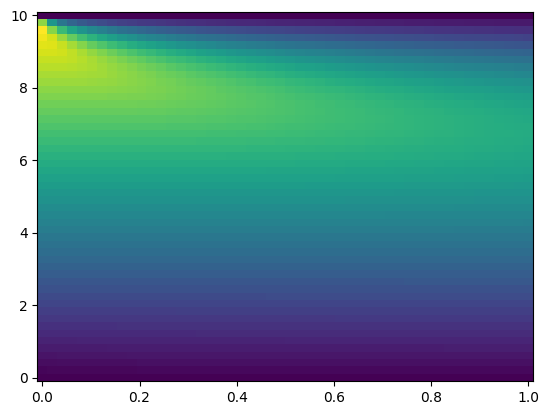

In [38]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_nonlinear_100s_scaled.png')

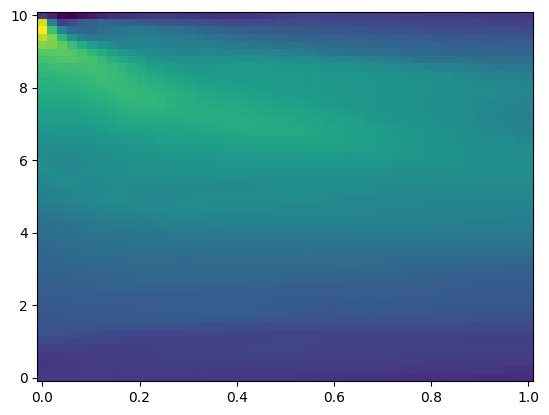

In [39]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_nonlinear_100s_scaled.png')

In [40]:
y_pred = model.predict(data_nonlinear.train_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y

In [41]:
x_test, y_test = get_data("heat_test_nonlinear_100s.npz")
xt_arr = x_test[1]

In [42]:
y_predict_arr = y_pred[5].reshape(8241, 1)
#xt_arr = data_x[1]

y_true_arr = data_y[5].reshape(8241, 1)
np.savetxt("test_heat_nonlinear_100s.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [43]:
data = np.genfromtxt("test_heat_nonlinear_100s.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

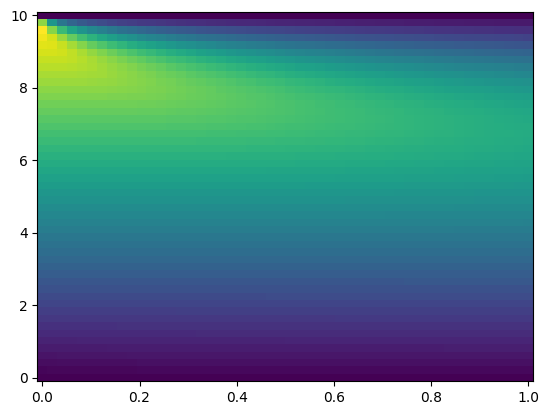

In [44]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_nonlinear_100s_scaled.png')

In [45]:
xt_arr

array([[ 0.  ,  0.  ],
       [ 0.  ,  0.25],
       [ 0.  ,  0.5 ],
       ...,
       [ 1.  ,  9.5 ],
       [ 1.  ,  9.75],
       [ 1.  , 10.  ]], dtype=float32)

In [46]:
data_unscaled = np.load("heat_test_nonlinear_100s.npz")
xt = data_unscaled["xt"].astype(np.float32)
xt_arr = xt[1]

In [47]:
y_predict_arr = y_pred[5].reshape(8241, 1)
#xt_arr = data_x[1]

y_true_arr = data_y[5].reshape(8241, 1)
np.savetxt("test_heat_nonlinear_100s.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [48]:
y_pred = model.predict(data_nonlinear.train_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y

In [49]:
y_predict_arr = y_pred[5].reshape(8241, 1)

In [50]:
y_true_arr = data_y[5].reshape(8241, 1)

In [51]:
data_unscaled = np.load("heat_test_nonlinear_100s.npz")
xt = data_unscaled["xt"].astype(np.float32)
xt_arr = xt[1]

In [52]:
np.savetxt("test_heat_nonlinear_100s.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [53]:
xt_arr = data_unscaled["xt"].astype(np.float32)

In [54]:
np.savetxt("test_heat_nonlinear_100s.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [55]:
data = np.genfromtxt("test_heat_nonlinear_100s.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

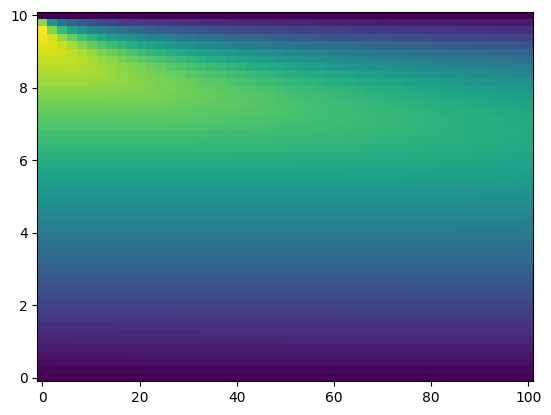

In [56]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_nonlinear_100s_scaled.png')

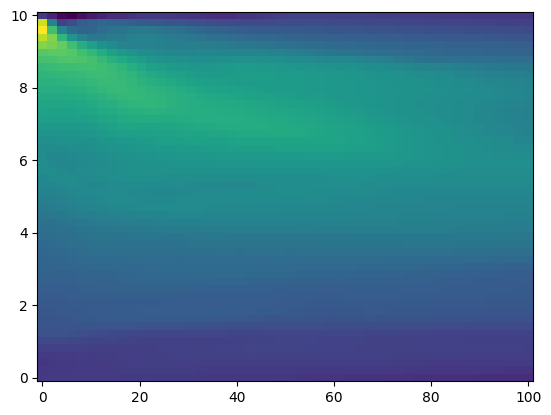

In [57]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_nonlinear_100s_scaled.png')

In [58]:
def train_DeepONet(nx=41):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=8000), 
                 dde.callbacks.ModelCheckpoint(filepath='best_model', save_better_only=True, period=1000, monitor='test loss')]
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= callbacks)
    return model, data

In [59]:
x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")

In [60]:
a = x_train[0]

In [61]:
a

array([[0.0000e+00, 5.0000e-04, 1.0000e-03, ..., 9.0000e-03, 9.5000e-03,
        1.0000e-02],
       [0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 1.8000e-02, 1.9000e-02,
        2.0000e-02],
       [0.0000e+00, 1.5000e-03, 3.0000e-03, ..., 2.7000e-02, 2.8500e-02,
        3.0000e-02],
       ...,
       [0.0000e+00, 4.9900e-01, 9.9800e-01, ..., 8.9820e+00, 9.4810e+00,
        9.9800e+00],
       [0.0000e+00, 4.9950e-01, 9.9900e-01, ..., 8.9910e+00, 9.4905e+00,
        9.9900e+00],
       [0.0000e+00, 5.0000e-01, 1.0000e+00, ..., 9.0000e+00, 9.5000e+00,
        1.0000e+01]], dtype=float32)

In [62]:
a.shape

(1000, 21)

In [63]:
b = x_train[1]

In [64]:
b.shape

(10521, 2)

In [65]:
def get_data(filename):
    data = np.load(filename)
    u0 = data["u0"].astype(np.float32)
    xt = data["xt"].astype(np.float32)
    num_xt = xt.shape[0]
    for n in range(num_xt):
        xt[n,0] = xt[n,0]/1000
    u = data["u"].astype(np.float32) 
    return (u0, xt), u

In [66]:
def train_DeepONet(nx=21):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=8000), 
                 dde.callbacks.ModelCheckpoint(filepath='best_model', save_better_only=True, period=1000, monitor='test loss')]
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= callbacks)
    return model, data

In [67]:
def train_DeepONet(nx=21):
    x_train, y_train = get_data("heat_train_nonlinear_1000sfixed.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1000sfixed.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=8000)]
    losshistory, train_state = model.train(epochs=70000, batch_size=None, callbacks= callbacks)
    return model, data

In [68]:
model, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.109364 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [9.28e+01]    [5.05e+01]    [6.68e+00]    
1000      [1.93e-02]    [1.00e-02]    [9.93e-02]    
2000      [2.06e-03]    [1.20e-03]    [3.87e-02]    
3000      [2.95e-03]    [1.72e-03]    [4.56e-02]    
4000      [3.50e-03]    [1.71e-03]    [4.25e-02]    
5000      [2.71e-03]    [1.32e-03]    [3.70e-02]    
6000      [8.03e-04]    [5.47e-04]    [2.52e-02]    
7000      [4.21e-04]    [2.93e-04]    [2.08e-02]    
8000      [8.67e-04]    [5.70e-04]    [2.64e-02]    
9000      [6.34e-04]    [4.14e-04]    [2.29e-02]    
10000     [1.16e-04]    [8.26e-05]    [1.37e-02]    
11000     [1.29e-03]    [8.02e-04]    [3.28e-02]    
12000     [4.98e-03]    [2.62e-03]    [4.71e-02]    
13000     [1.22e-04]    [7.22e-05]    [1.24e-02]    
14000     [6.59e-05]    [4.17e-05]    [1.00e-02]    
15000     [2.81e-04]    [1.51e-04]    [1.43e-02]    
16000     [4.48e-05]    [3.24e-05]

In [69]:
y_pred = model.predict(data_nonlinear.train_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1000sfixed.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[5].reshape(10521, 1)
#xt_arr = data_x[1]

y_true_arr = data_y[5].reshape(10521, 1)
np.savetxt("test_heat_nonlinear_1000sfixed.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [70]:
data = np.genfromtxt("test_heat_nonlinear_1000sfixed.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

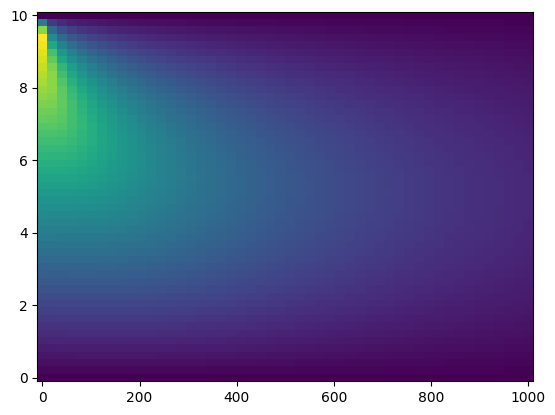

In [71]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_nonlinear_1000s_scaled.png')

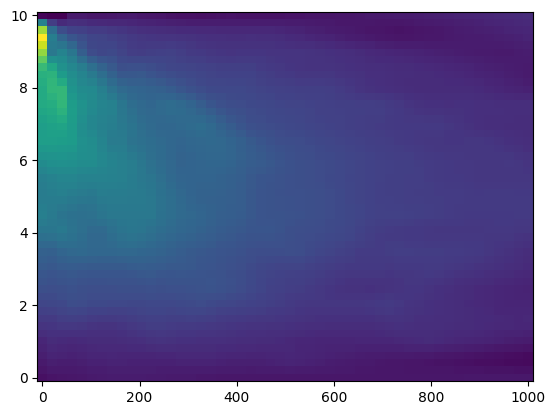

In [72]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_nonlinear_1000s_scaled.png')

In [73]:
y_predict_arr = y_pred[52].reshape(10521, 1)
#xt_arr = data_x[1]

y_true_arr = data_y[52].reshape(10521, 1)
np.savetxt("test_heat_nonlinear_1000sfixed.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [74]:
data = np.genfromtxt("test_heat_nonlinear_1000sfixed.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

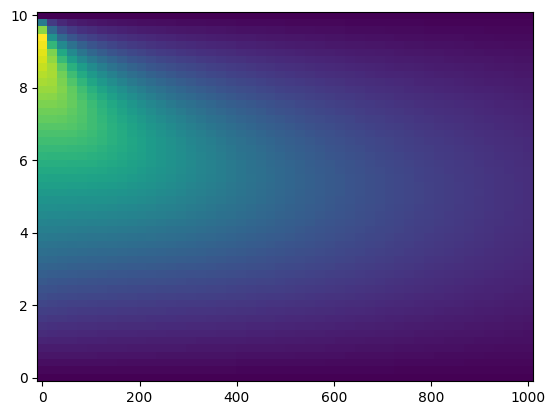

In [75]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_nonlinear_1000s_scaled52.png')

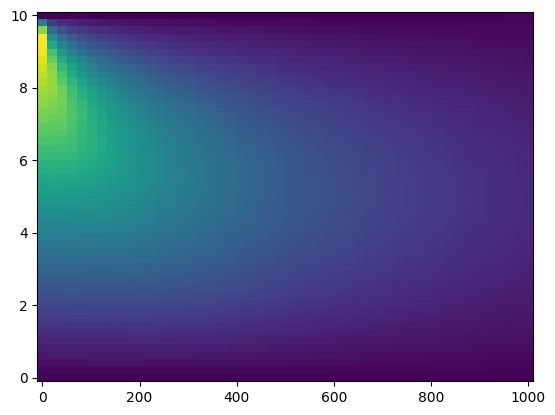

In [76]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_nonlinear_1000s_scaled52.png')

In [77]:
y_pred = model.predict(data_nonlinear.train_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1000sfixed.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[78].reshape(10521, 1)
#xt_arr = data_x[1]

y_true_arr = data_y[78].reshape(10521, 1)
np.savetxt("test_heat_nonlinear_1000sfixed.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [78]:
data = np.genfromtxt("test_heat_nonlinear_1000sfixed.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

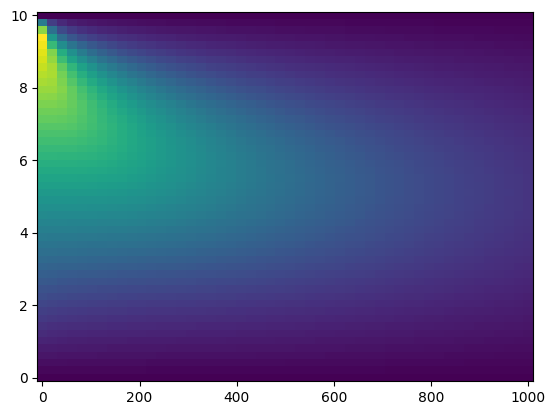

In [79]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_nonlinear_1000s_scaled78.png')

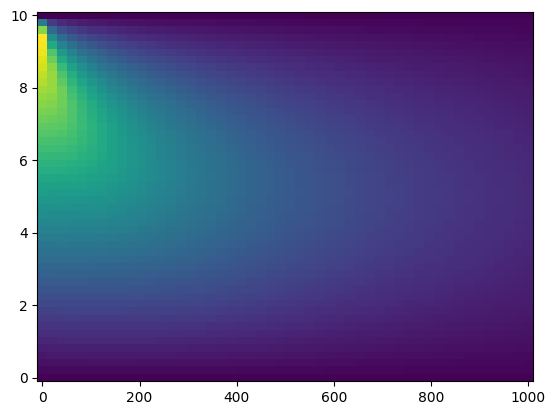

In [80]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_nonlinear_1000s_scaled78.png')

In [81]:
y_pred = model.predict(data_nonlinear.train_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1000sfixed.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[90].reshape(10521, 1)
#xt_arr = data_x[1]

y_true_arr = data_y[90].reshape(10521, 1)
np.savetxt("test_heat_nonlinear_1000sfixed90.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [82]:
data = np.genfromtxt("test_heat_nonlinear_1000sfixed90.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

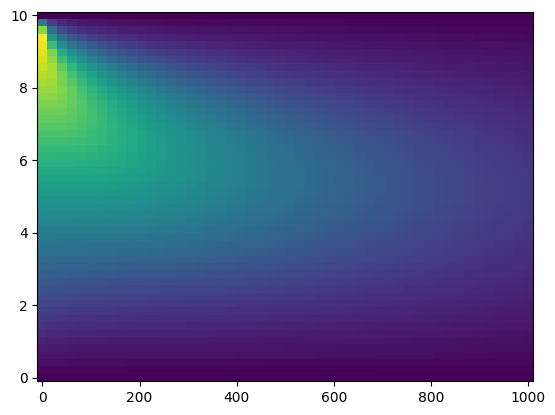

In [83]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_nonlinear_1000s_scaled90.png')

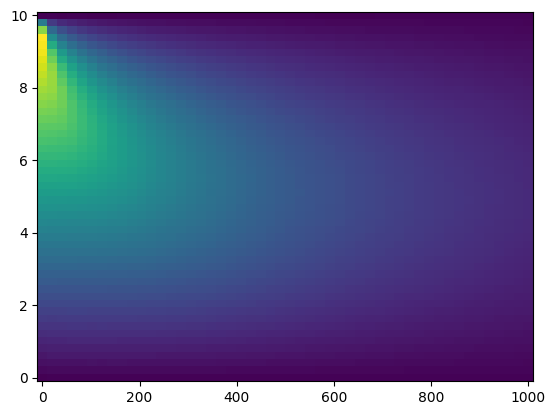

In [84]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_nonlinear_1000s_scaled90.png')

In [85]:
data = np.genfromtxt("test_heat_nonlinear_1000sfixed90.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

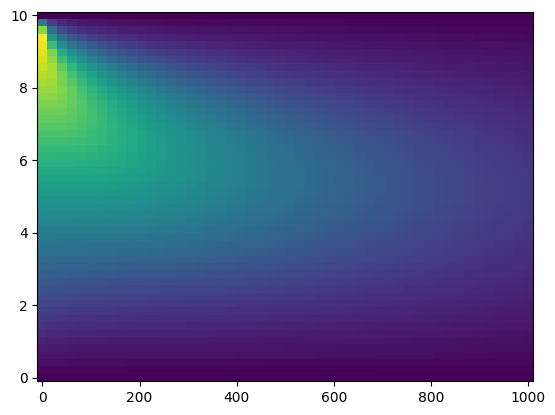

In [86]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_nonlinear_1000s_scaled90.png')

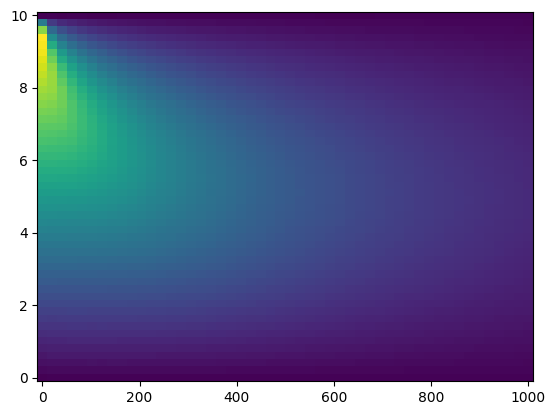

In [87]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_nonlinear_1000s_scaled90.png')

In [88]:
y_pred = model.predict(data_nonlinear.train_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1000sfixed.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[2].reshape(10521, 1)
#xt_arr = data_x[1]

y_true_arr = data_y[2].reshape(10521, 1)
np.savetxt("test_heat_nonlinear_1000sfixed2.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [89]:
data = np.genfromtxt("test_heat_nonlinear_1000sfixed2.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

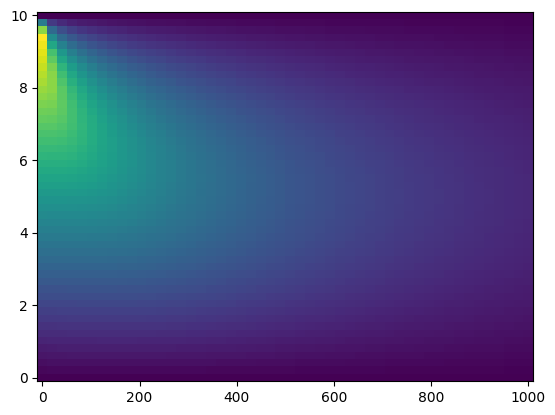

In [90]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_nonlinear_1000s_scaled2.png')

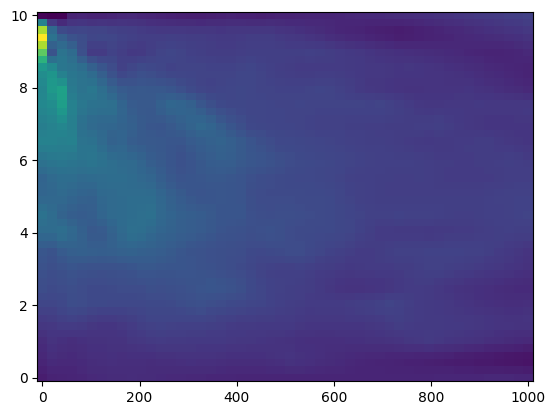

In [91]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_nonlinear_1000s_scaled2.png')

In [92]:
b

array([[ 0. ,  0. ],
       [ 0. ,  0.5],
       [ 0. ,  1. ],
       ...,
       [10. ,  9. ],
       [10. ,  9.5],
       [10. , 10. ]], dtype=float32)

In [93]:
def get_data(filename):
    data = np.load(filename)
    u0 = data["u0"].astype(np.float32)
    xt = data["xt"].astype(np.float32)
    num_xt = xt.shape[0]
    for n in range(num_xt):
        xt[n,0] = xt[n,0]/3600
    u = data["u"].astype(np.float32) 
    return (u0, xt), u

In [94]:
def train_DeepONet(nx=21):
    x_train, y_train = get_data("heat_train_nonlinear_1h.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1h.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 1024, 1024], [2, 512, 512, 1024, 1024], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=8000)]
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= callbacks)
    return model, data

In [96]:
def train_DeepONet(nx=21):
    x_train, y_train = get_data("heat_train_nonlinear_1h.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1h.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512], [2, 512, 512, 512, 512], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=8000)]
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= callbacks)
    return model, data

In [97]:
model, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.002404 s

Training model...

0         [5.79e+01]    [3.14e+01]    [9.80e+00]    
1000      [6.88e-03]    [4.60e-03]    [1.42e-01]    
2000      [1.71e-03]    [9.87e-04]    [6.42e-02]    
3000      [2.42e-03]    [1.24e-03]    [6.79e-02]    
4000      [2.75e-03]    [1.60e-03]    [7.45e-02]    
5000      [1.63e-03]    [8.16e-04]    [5.56e-02]    
6000      [1.34e-03]    [7.85e-04]    [5.42e-02]    
7000      [2.64e-04]    [1.43e-04]    [2.71e-02]    
8000      [4.42e-04]    [2.82e-04]    [3.63e-02]    
9000      [8.68e-04]    [4.83e-04]    [4.03e-02]    
10000     [2.82e-04]    [1.78e-04]    [2.87e-02]    
11000     [4.46e-03]    [2.31e-03]    [8.31e-02]    
12000     [1.28e-04]    [8.16e-05]    [2.00e-02]    
13000     [7.83e-04]    [4.22e-04]    [3.77e-02]    
14000     [3.00e-04]    [1.77e-04]    [2.72e-02]    
15000     [2.76e-04]    [1.51e-04]    [2.51e-02]    
16000     [2.48e-04]    [1.32e-04]    [2.32e-02]    
17000     [1.90e-05]    [1.35e-05]

In [98]:
y_pred = model.predict(data_nonlinear.train_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[2].reshape(18921, 1)
#xt_arr = data_x[1]

y_true_arr = data_y[2].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [99]:
data = np.genfromtxt("test_heat_nonlinear_1h.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

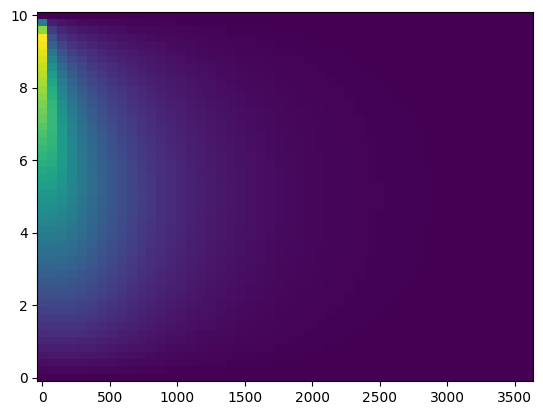

In [100]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_nonlinear_1h_2.png')

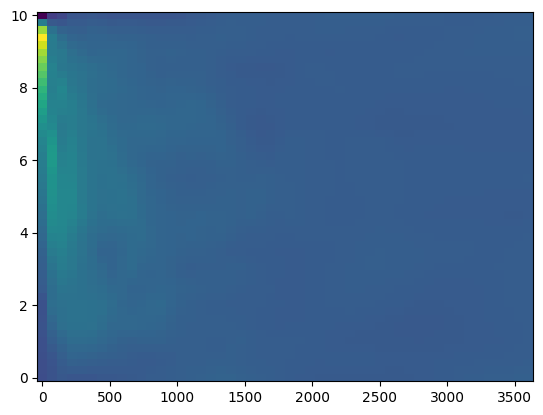

In [101]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_nonlinear_1h_2.png')

In [102]:
y_pred = model.predict(data_nonlinear.train_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[10].reshape(18921, 1)
#xt_arr = data_x[1]

y_true_arr = data_y[10].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [103]:
data = np.genfromtxt("test_heat_nonlinear_1h.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

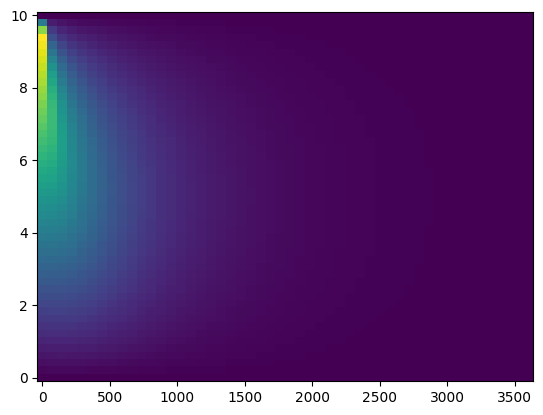

In [104]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_nonlinear_1h_10.png')

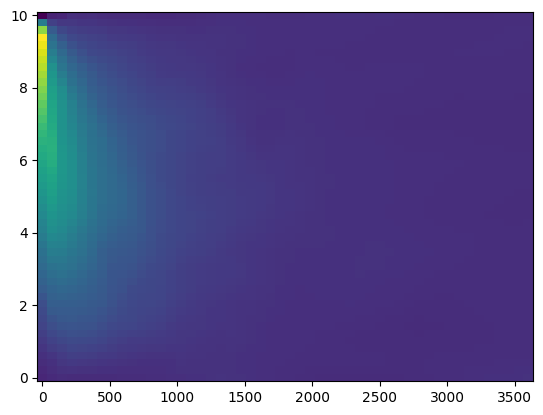

In [105]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_nonlinear_1h_10.png')

In [106]:
y_pred = model.predict(data_nonlinear.train_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[30].reshape(18921, 1)
#xt_arr = data_x[1]

y_true_arr = data_y[30].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [107]:
data = np.genfromtxt("test_heat_nonlinear_1h.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

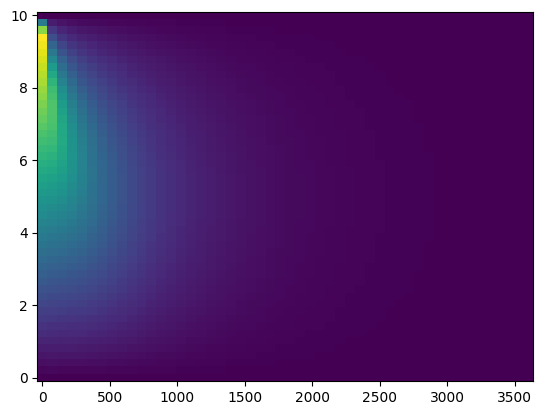

In [108]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_nonlinear_1h_30.png')

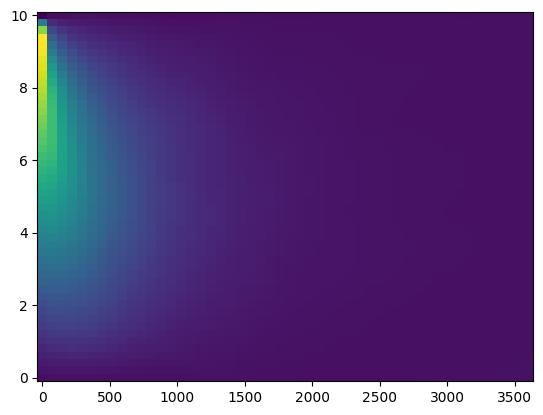

In [109]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_nonlinear_1h_30.png')

In [110]:
y_pred = model.predict(data_nonlinear.train_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[50].reshape(18921, 1)
#xt_arr = data_x[1]

y_true_arr = data_y[50].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [111]:
data = np.genfromtxt("test_heat_nonlinear_1h.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

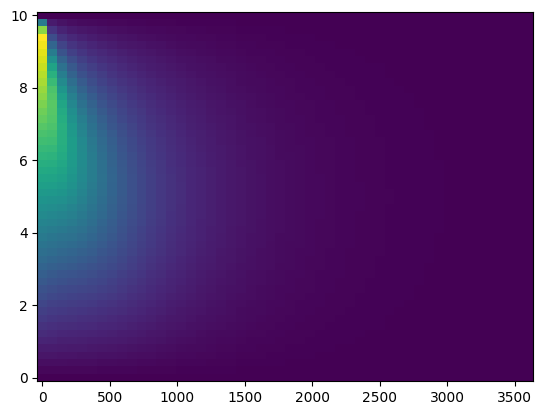

In [112]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_nonlinear_1h_50.png')

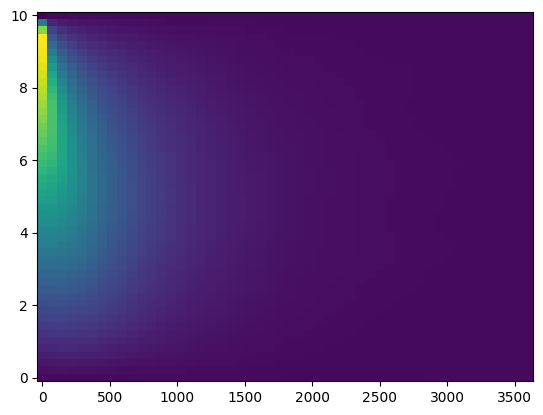

In [113]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_nonlinear_1h_50.png')

In [114]:
y_pred = model.predict(data_nonlinear.train_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[80].reshape(18921, 1)
#xt_arr = data_x[1]

y_true_arr = data_y[80].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [115]:
data = np.genfromtxt("test_heat_nonlinear_1h.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

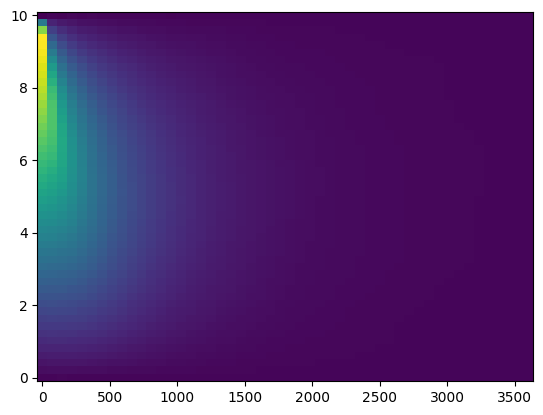

In [116]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_nonlinear_1h_80.png')
#plotting  the predicted data

Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_nonlinear_1h_80.png')

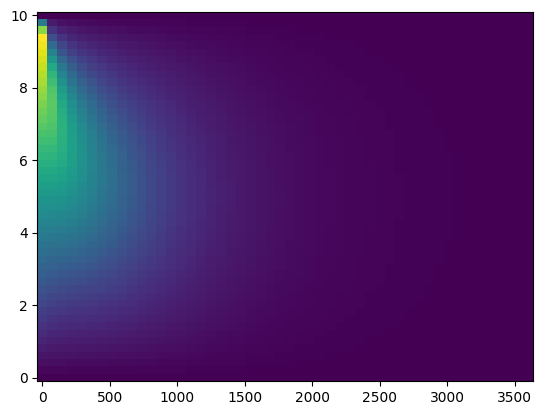

In [117]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_nonlinear_1h_80.png')

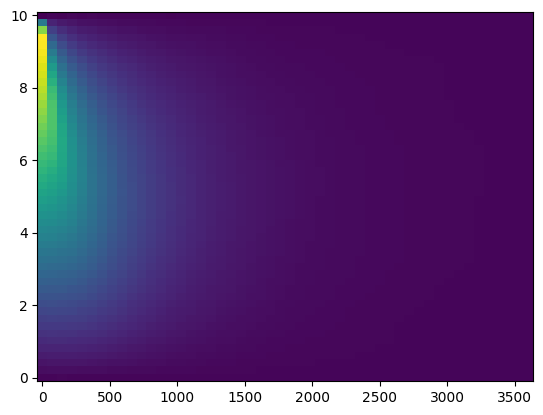

In [118]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_nonlinear_1h_80.png')

In [119]:
y_predict_arr = y_pred[3].reshape(18921, 1)
#xt_arr = data_x[1]

y_true_arr = data_y[3].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [120]:
data = np.genfromtxt("test_heat_nonlinear_1h.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

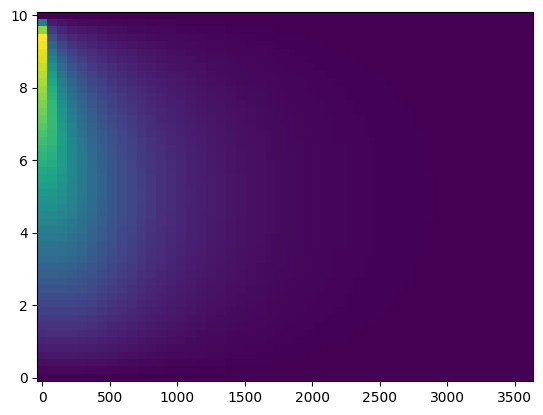

In [121]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_nonlinear_1h_3.png')

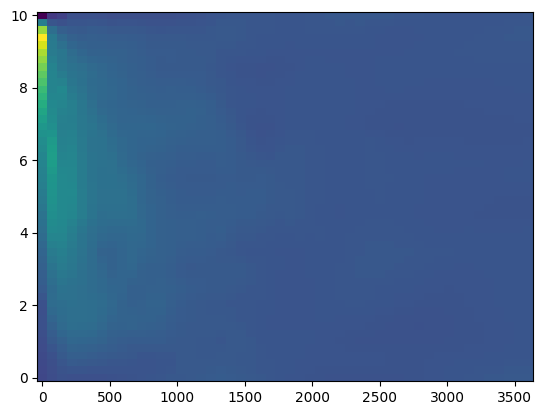

In [122]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_nonlinear_1h_3.png')

In [123]:
y_predict_arr = y_pred[5].reshape(18921, 1)
#xt_arr = data_x[1]

y_true_arr = data_y[5].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [124]:
data = np.genfromtxt("test_heat_nonlinear_1h.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

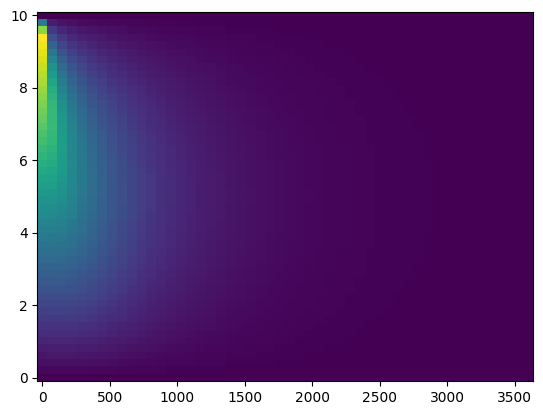

In [125]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_reference_nonlinear_1h_5.png')

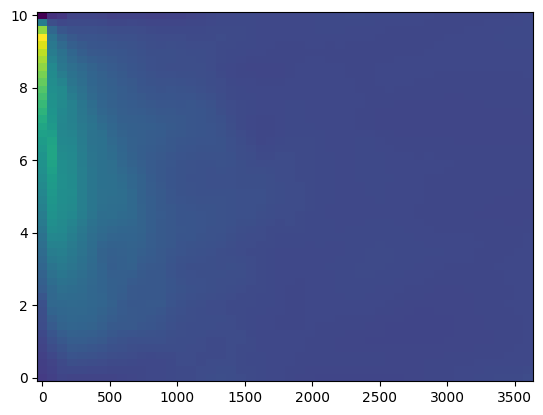

In [126]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.savefig('heat_predict_nonlinear_1h_5.png')

In [127]:
?plt.pcolormesh

Signature:
plt.pcolormesh(
    *args,
    alpha=None,
    norm=None,
    cmap=None,
    vmin=None,
    vmax=None,
    shading=None,
    antialiased=False,
    data=None,
    **kwargs,
)
Docstring:
Create a pseudocolor plot with a non-regular rectangular grid.

Call signature::

    pcolormesh([X, Y,] C, **kwargs)

*X* and *Y* can be used to specify the corners of the quadrilaterals.

.. hint::

   `~.Axes.pcolormesh` is similar to `~.Axes.pcolor`. It is much faster
   and preferred in most cases. For a detailed discussion on the
   differences see :ref:`Differences between pcolor() and pcolormesh()
   <differences-pcolor-pcolormesh>`.

Parameters
----------
C : array-like
    The mesh data. Supported array shapes are:

    - (M, N) or M*N: a mesh with scalar data. The values are mapped to
      colors using normalization and a colormap. See parameters *norm*,
      *cmap*, *vmin*, *vmax*.
    - (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
    - (M, N, 4): an image with

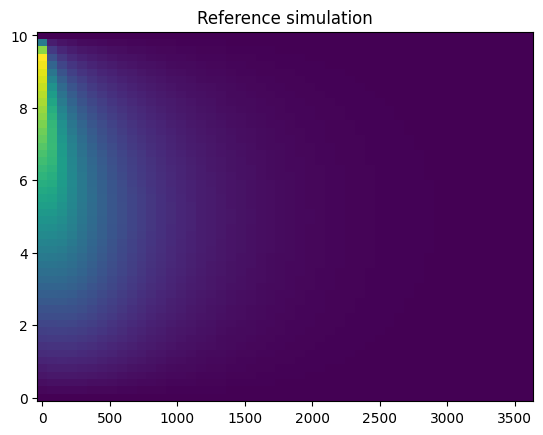

In [128]:
Z = interp1(X, T)
plt.pcolormesh(X, T, Z)
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_5.png')

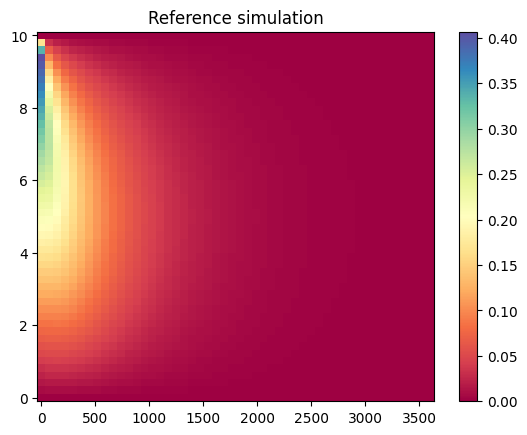

In [129]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z, cmap='Spectral')
plt.colorbar(graph1)
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_5.png')

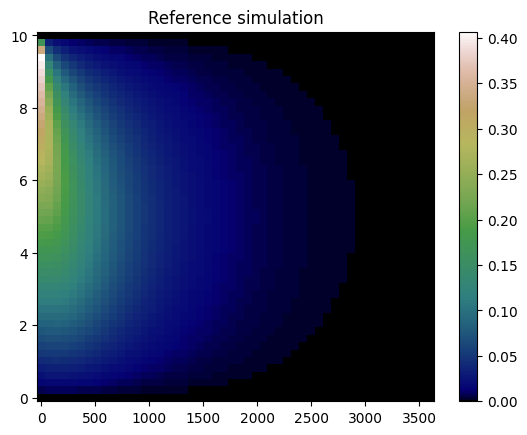

In [130]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z, cmap='gist_earth')
plt.colorbar(graph1)
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_5.png')

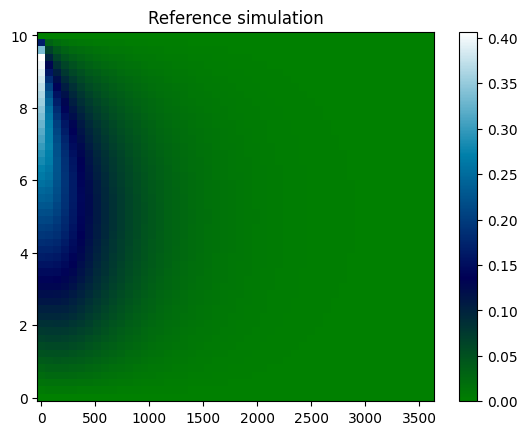

In [131]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z, cmap='ocean')
plt.colorbar(graph1)
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_5.png')

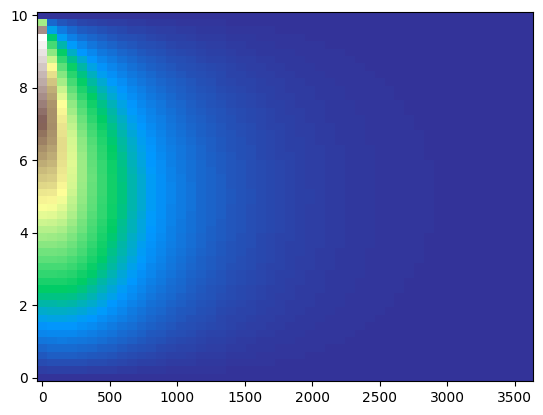

In [132]:
graph1 = plt.pcolormesh(X, T, Z, cmap='terrain')

In [133]:
top = cm.get_cmap('Oranges_r', 128) # r means reversed version
bottom = cm.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue

orange_blue = ListedColormap(newcolors, name='OrangeBlue')

NameError: name 'cm' is not defined

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

In [135]:
top = cm.get_cmap('Oranges_r', 128) # r means reversed version
bottom = cm.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue

orange_blue = ListedColormap(newcolors, name='OrangeBlue')

<ipython-input-135-66e45272ee05>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = cm.get_cmap('Oranges_r', 128) # r means reversed version
<ipython-input-135-66e45272ee05>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom = cm.get_cmap('Blues', 128)# combine it all


ValueError: 'OrangeBlue' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

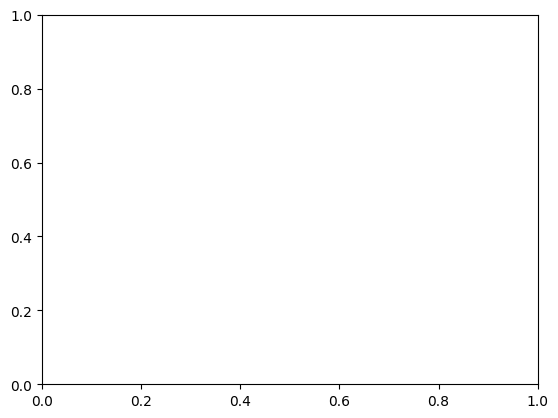

In [136]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z, cmap='OrangeBlue')
plt.colorbar(graph1)
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_5.png')

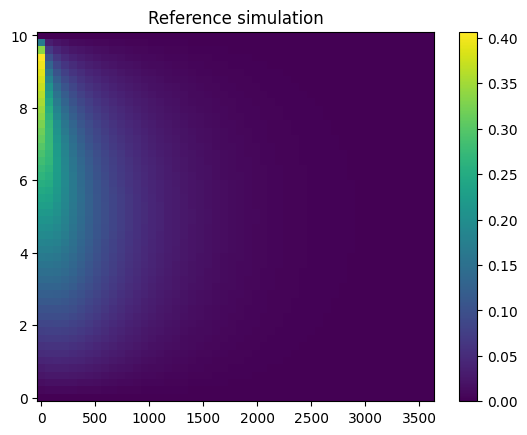

In [137]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.colorbar(graph1)
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_5.png')

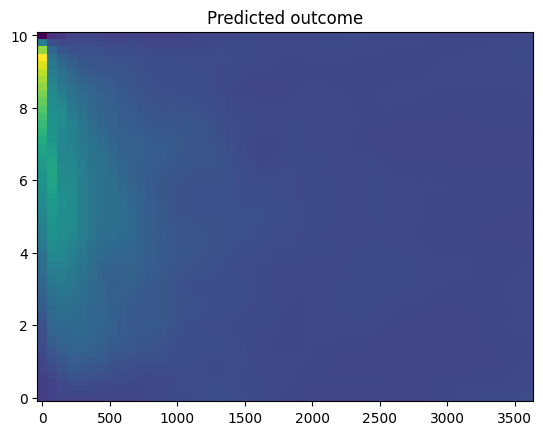

In [138]:
Z = interp2(X, T)
plt.pcolormesh(X, T, Z)
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_5.png')

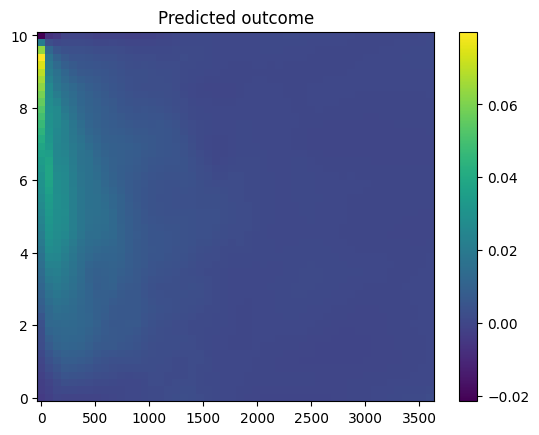

In [139]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.colorbar(graph2)
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_5.png')

In [140]:
y_predict_arr = y_pred[10].reshape(18921, 1)
#xt_arr = data_x[1]

y_true_arr = data_y[10].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [141]:
data = np.genfromtxt("test_heat_nonlinear_1h.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

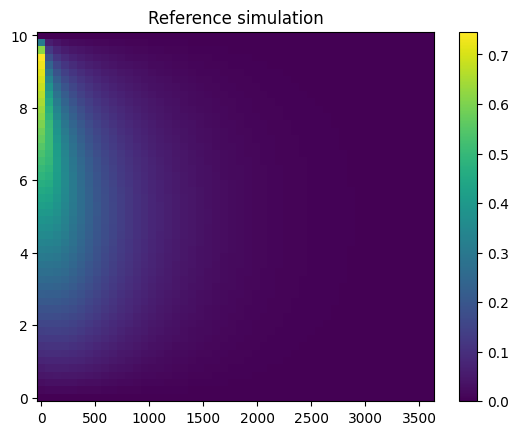

In [142]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.colorbar(graph1)
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_10.png')

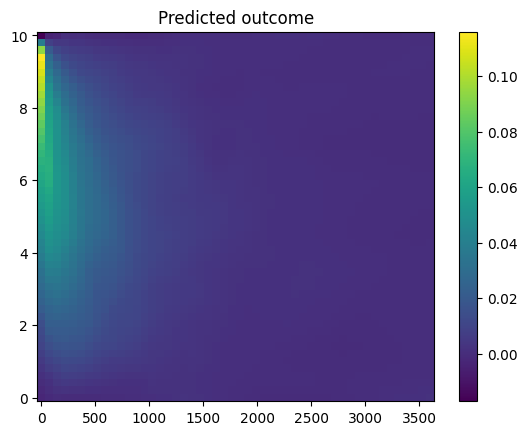

In [143]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.colorbar(graph2)
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_10.png')

In [144]:
y_predict_arr = y_pred[20].reshape(18921, 1)
#xt_arr = data_x[1]

y_true_arr = data_y[20].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

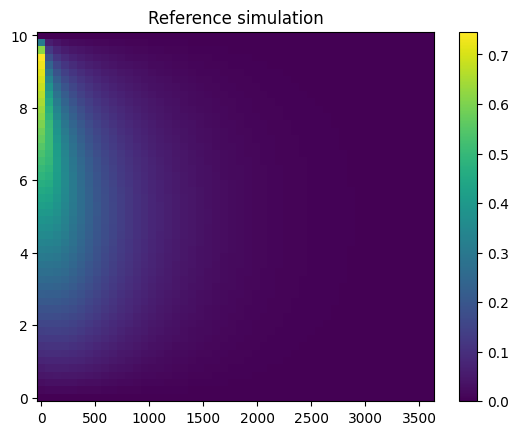

In [145]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.colorbar(graph1)
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_20.png')

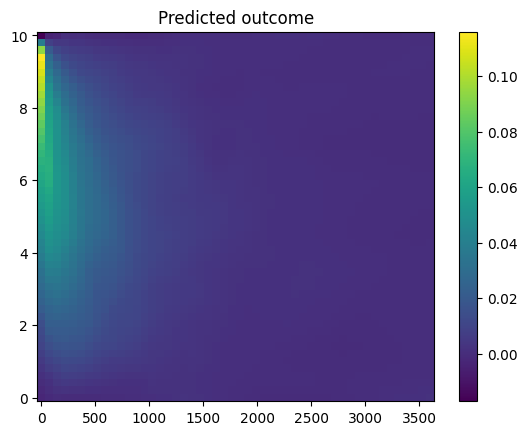

In [146]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.colorbar(graph2)
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_20.png')

In [147]:
y_predict_arr = y_pred[20].reshape(18921, 1)
#xt_arr = data_x[1]

y_true_arr = data_y[20].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [148]:
data = np.genfromtxt("test_heat_nonlinear_1h.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

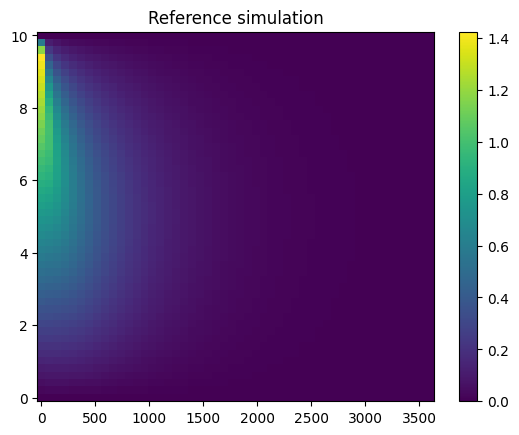

In [149]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.colorbar(graph1)
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_50.png')

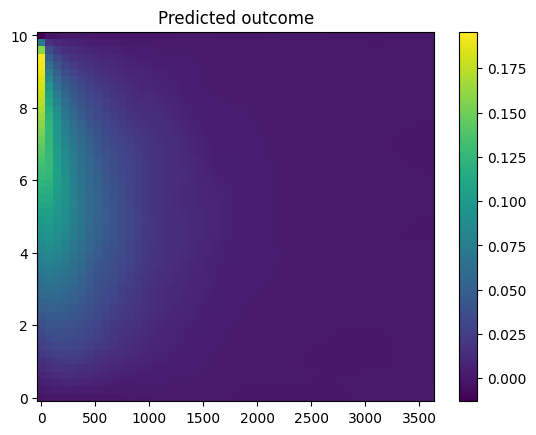

In [150]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.colorbar(graph2)
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_50.png')

In [151]:
y_predict_arr = y_pred[80].reshape(18921, 1)
#xt_arr = data_x[1]

y_true_arr = data_y[80].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [152]:
data = np.genfromtxt("test_heat_nonlinear_1h.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

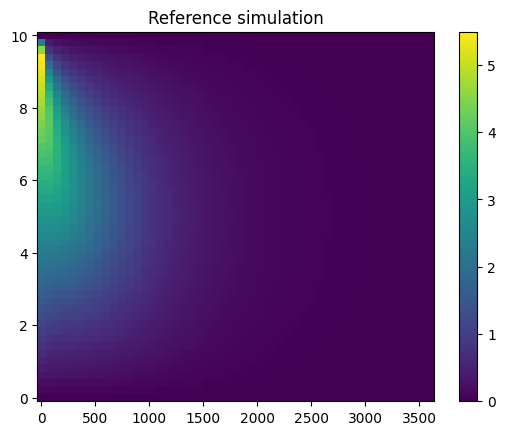

In [153]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.colorbar(graph1)
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_80.png')

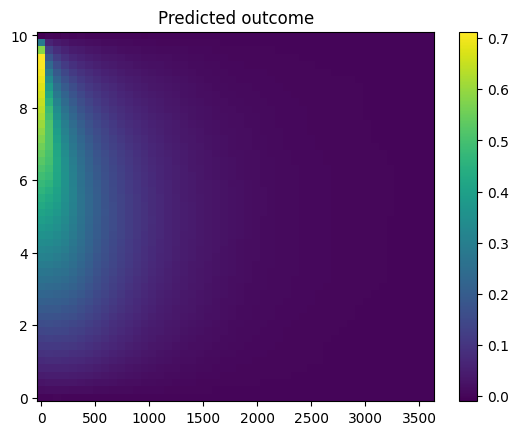

In [154]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.colorbar(graph2)
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_80.png')

In [155]:
y_predict_arr = y_pred[80].reshape(18921, 1) * 10
#xt_arr = data_x[1]

y_true_arr = data_y[80].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [156]:
data = np.genfromtxt("test_heat_nonlinear_1h.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

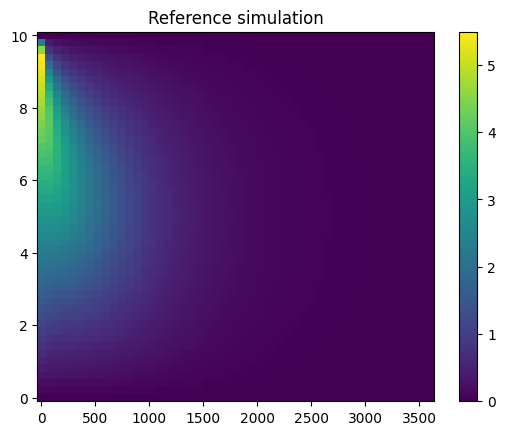

In [157]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.colorbar(graph1)
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_80.png')

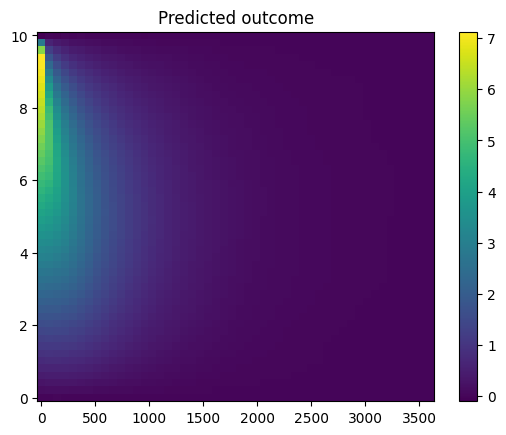

In [158]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.colorbar(graph2)
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_80.png')

In [159]:
def get_data(filename):
    data = np.load(filename)
    u0 = data["u0"].astype(np.float32)
    xt = data["xt"].astype(np.float32)
    num_xt = xt.shape[0]
    for n in range(num_xt):
        xt[n,0] = xt[n,0]/3600
    u = data["u"].astype(np.float32) 
    return (u0, xt), u

In [160]:
def train_DeepONet(nx=21):
    x_train, y_train = get_data("heat_train_nonlinear_1h_quasi.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1h_random.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512], [2, 512, 512, 512, 512], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=8000)]
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= callbacks)
    return model, data

In [161]:
model, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.002630 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.71e-01]    [3.12e+01]    [1.01e+01]    
1000      [2.65e-05]    [1.37e-02]    [1.58e-01]    
2000      [1.02e-05]    [1.10e-02]    [1.34e-01]    
3000      [8.47e-06]    [7.67e-03]    [1.08e-01]    
4000      [7.61e-06]    [6.96e-03]    [1.02e-01]    
5000      [2.92e-06]    [9.40e-03]    [1.17e-01]    
6000      [1.78e-06]    [9.04e-03]    [1.13e-01]    
7000      [3.26e-06]    [7.36e-03]    [1.01e-01]    
8000      [3.62e-06]    [7.26e-03]    [1.01e-01]    
9000      [2.09e-06]    [7.15e-03]    [9.80e-02]    
10000     [1.11e-05]    [8.15e-03]    [1.13e-01]    
11000     [1.69e-06]    [6.95e-03]    [9.58e-02]    
12000     [1.15e-06]    [7.08e-03]    [9.66e-02]    
13000     [6.70e-07]    [8.15e-03]    [1.05e-01]    
14000     [1.83e-06]    [8.57e-03]    [1.09e-01]    
15000     [1.26e-06]    [8.23e-03]    [1.06e-01]    
16000     [3.21e-06]    [6.60e-03]

In [162]:
y_pred = model.predict(data_nonlinear.train_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h_random.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[80].reshape(18921, 1) * 10
#xt_arr = data_x[1]

y_true_arr = data_y[80].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h_new.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

ValueError: cannot reshape array of size 10000 into shape (18921,1)

In [163]:
y_pred = model.predict(data_nonlinear.train_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h_random.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[80].reshape(8000, 1)
#xt_arr = data_x[1]

y_true_arr = data_y[80].reshape(8000, 1)
np.savetxt("test_heat_nonlinear_1h_new.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

ValueError: cannot reshape array of size 10000 into shape (8000,1)

In [164]:
y_pred

array([[-7.36571848e-04, -6.60796650e-06, -2.06115656e-05, ...,
        -3.78296245e-05, -8.89473595e-05,  9.18392558e-04],
       [-6.17963262e-04,  2.30269507e-07, -1.74189918e-05, ...,
        -3.53094656e-05, -8.08632467e-05,  1.01823756e-03],
       [-3.78987752e-04,  1.39127951e-05, -9.84454527e-06, ...,
        -2.90498137e-05, -6.28086273e-05,  1.21689052e-03],
       ...,
       [ 2.55096555e-01,  1.69217810e-02,  2.51001446e-04, ...,
         3.30150872e-03,  1.31335650e-02,  3.11040312e-01],
       [ 2.55259424e-01,  1.69503354e-02,  2.53413105e-04, ...,
         3.31126363e-03,  1.31547265e-02,  3.11382473e-01],
       [ 2.55558908e-01,  1.69590488e-02,  2.52288068e-04, ...,
         3.30972741e-03,  1.31644672e-02,  3.11691791e-01]], dtype=float32)

In [165]:
y_pred.shape

(1000, 10000)

In [166]:
y_true_arr = data_y[80].reshape(8000, 1)

In [167]:
y_pred = model.predict(data_nonlinear.test_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h_random.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[80].reshape(8000, 1)
#xt_arr = data_x[1]

y_true_arr = data_y[80].reshape(8000, 1)
np.savetxt("test_heat_nonlinear_1h_new.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [168]:
data = np.genfromtxt("test_heat_nonlinear_1h_new.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

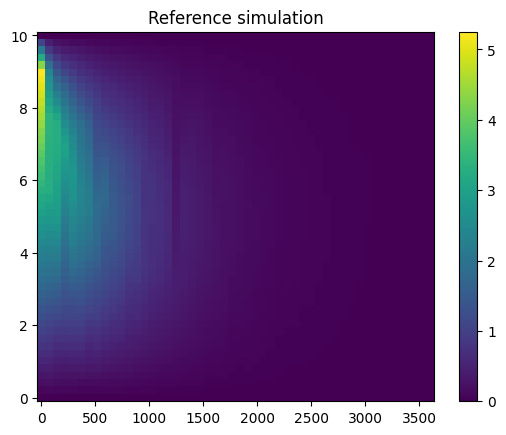

In [169]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.colorbar(graph1)
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_new.png')

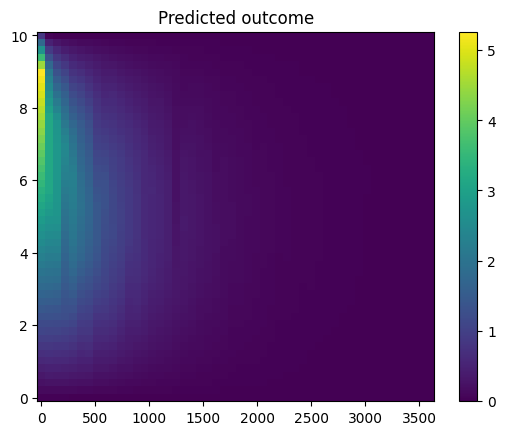

In [170]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.colorbar(graph2)
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_new.png')

In [171]:
y_pred = model.predict(data_nonlinear.test_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h_random.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[50].reshape(8000, 1)
y_true_arr = data_y[50].reshape(8000, 1)
np.savetxt("test_heat_nonlinear_1h_new.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [172]:
data = np.genfromtxt("test_heat_nonlinear_1h_new.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

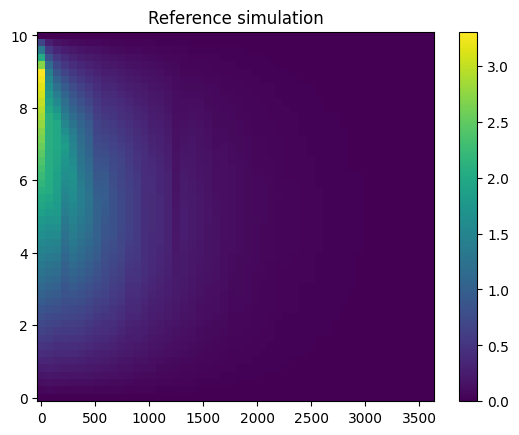

In [173]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.colorbar(graph1)
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_new50.png')

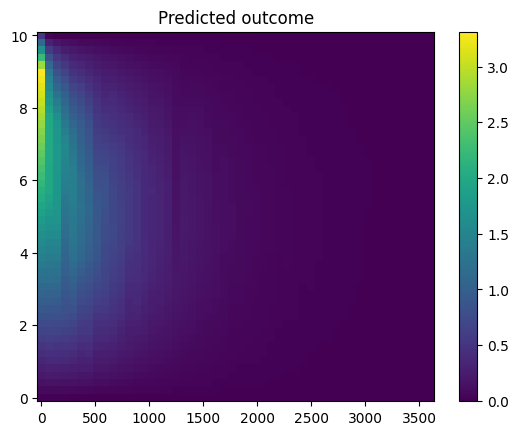

In [174]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.colorbar(graph2)
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_new50.png')

In [175]:
y_pred = model.predict(data_nonlinear.test_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h_random.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[20].reshape(8000, 1)
y_true_arr = data_y[20].reshape(8000, 1)
np.savetxt("test_heat_nonlinear_1h_new.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [176]:
data = np.genfromtxt("test_heat_nonlinear_1h_new.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

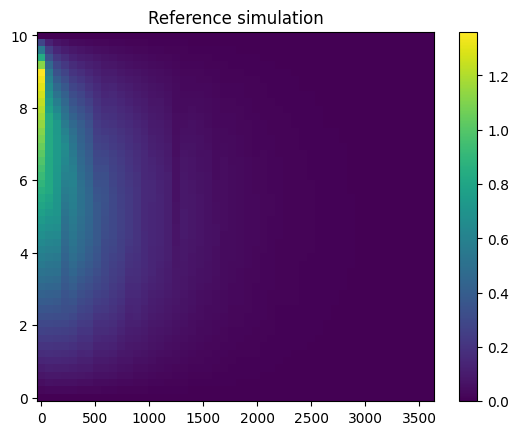

In [177]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.colorbar(graph1)
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_new20.png')

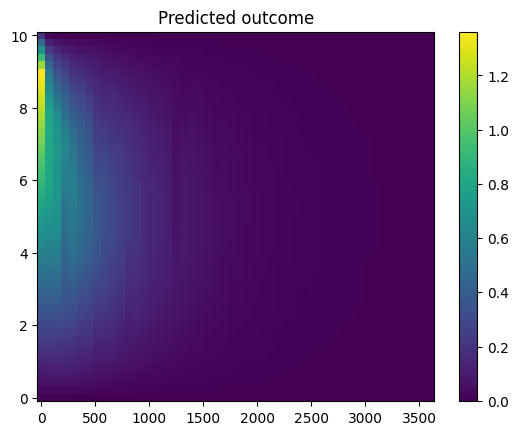

In [178]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.colorbar(graph2)
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_new20.png')

In [179]:
y_pred = model.predict(data_nonlinear.test_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h_random.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[5].reshape(8000, 1)
y_true_arr = data_y[5].reshape(8000, 1)
np.savetxt("test_heat_nonlinear_1h_new.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [180]:
data = np.genfromtxt("test_heat_nonlinear_1h_new.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

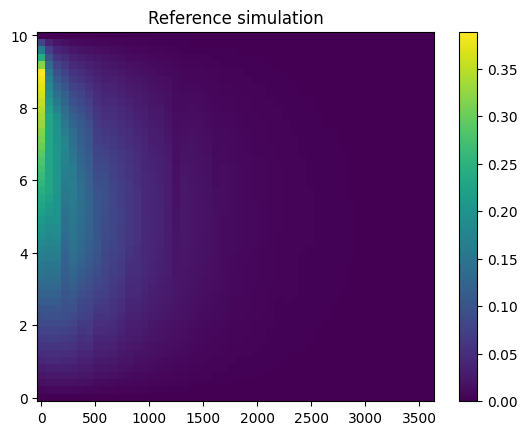

In [181]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.colorbar(graph1)
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_new5.png')

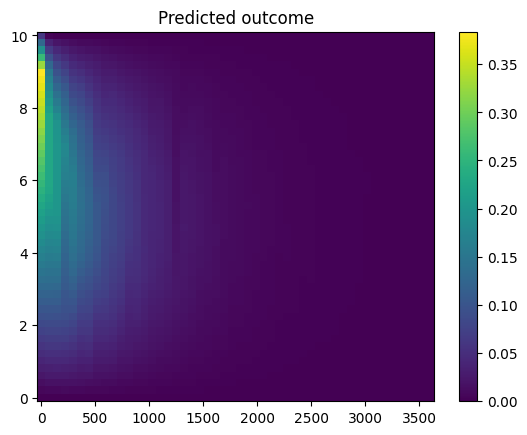

In [182]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.colorbar(graph2)
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_new5.png')

In [183]:
def train_DeepONet(nx=21):
    x_train, y_train = get_data("heat_train_nonlinear_1h.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1h.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512], [2, 512, 512, 512, 512], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=8000)]
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= callbacks)
    return model, data

In [184]:
model, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.002415 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.79e+01]    [3.14e+01]    [9.80e+00]    
1000      [6.88e-03]    [4.60e-03]    [1.42e-01]    
2000      [1.71e-03]    [9.87e-04]    [6.42e-02]    
3000      [2.42e-03]    [1.24e-03]    [6.79e-02]    
4000      [2.75e-03]    [1.60e-03]    [7.45e-02]    
5000      [1.63e-03]    [8.16e-04]    [5.56e-02]    
6000      [1.34e-03]    [7.85e-04]    [5.42e-02]    
7000      [2.64e-04]    [1.43e-04]    [2.71e-02]    
8000      [4.42e-04]    [2.82e-04]    [3.63e-02]    
9000      [8.68e-04]    [4.83e-04]    [4.03e-02]    
10000     [2.82e-04]    [1.78e-04]    [2.87e-02]    
11000     [4.46e-03]    [2.31e-03]    [8.31e-02]    
12000     [1.28e-04]    [8.16e-05]    [2.00e-02]    
13000     [7.83e-04]    [4.22e-04]    [3.77e-02]    
14000     [3.00e-04]    [1.77e-04]    [2.72e-02]    
15000     [2.76e-04]    [1.51e-04]    [2.51e-02]    
16000     [2.48e-04]    [1.32e-04]

Connected to cryopinn (Python 3.11.4)

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import deepxde as dde
from deepxde.backend import tf

2023-09-07 13:52:15.761823: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 13:52:54.773807: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Enable just-in-time compilation with XLA.



In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import deepxde as dde
from deepxde.backend import tf

In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import deepxde as dde
from deepxde.backend import tf

In [4]:
def get_data(filename):
    data = np.load(filename)
    u0 = data["u0"].astype(np.float32)
    xt = data["xt"].astype(np.float32)
    num_xt = xt.shape[0]
    for n in range(num_xt):
        xt[n,0] = xt[n,0]/3600
    u = data["u"].astype(np.float32) 
    return (u0, xt), u
#function for training the DeepONet and testing the model

def train_DeepONet(nx=21):
    x_train, y_train = get_data("heat_train_nonlinear_1h.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1h.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512], [2, 512, 512, 512, 512], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=8000)]
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= callbacks)
    return model, data

In [5]:
model, data_nonlinear = train_DeepONet()

2023-09-07 13:58:44.193890: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-09-07 13:58:44.193959: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38370 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-09-07 13:58:44.205212: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-09-07 13:58:44.205237: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38370 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-09-07 13:58:44.207926: W tensorflow/core/

Compiling model...
'compile' took 0.689528 s

Training model...



/home/guest/lizhen001/anaconda3/envs/cryopinn/lib/python3.11/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
2023-09-07 13:58:46.456255: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55e41fe2b040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-07 13:58:46.456295: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-09-07 13:58:46.456301: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-09-07 13:58:46.456304: I tensorflow/compiler/xla/service/service.cc:177

Step      Train loss    Test loss     Test metric   
0         [6.87e+01]    [3.73e+01]    [1.07e+01]    
1000      [1.32e-02]    [6.25e-03]    [1.52e-01]    
2000      [4.14e-03]    [2.16e-03]    [9.50e-02]    
3000      [1.22e-03]    [7.29e-04]    [5.59e-02]    
4000      [1.05e-03]    [5.91e-04]    [5.09e-02]    
5000      [9.11e-04]    [4.73e-04]    [4.56e-02]    
6000      [1.78e-03]    [8.90e-04]    [5.71e-02]    
7000      [5.32e-04]    [3.14e-04]    [3.63e-02]    
8000      [1.20e-03]    [6.75e-04]    [5.28e-02]    
9000      [1.42e-03]    [8.00e-04]    [5.26e-02]    
10000     [2.31e-04]    [1.16e-04]    [2.46e-02]    
11000     [4.91e-04]    [2.98e-04]    [3.44e-02]    
12000     [1.56e-04]    [8.62e-05]    [2.31e-02]    
13000     [6.05e-04]    [3.57e-04]    [3.83e-02]    
14000     [5.50e-04]    [2.90e-04]    [3.51e-02]    
15000     [2.26e-04]    [1.20e-04]    [2.34e-02]    
16000     [2.35e-04]    [1.27e-04]    [2.36e-02]    
17000     [6.09e-03]    [3.32e-03]    [1.10e-0

In [6]:
y_pred = model.predict(data_nonlinear.test_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)

In [7]:
xt_arr

array([[0.0e+00, 0.0e+00],
       [0.0e+00, 5.0e-01],
       [0.0e+00, 1.0e+00],
       ...,
       [3.6e+03, 9.0e+00],
       [3.6e+03, 9.5e+00],
       [3.6e+03, 1.0e+01]], dtype=float32)

In [8]:
xt_arr.shape

(18921, 2)

In [9]:
y_predict_arr = y_pred[5].reshape(18921, 1)
y_true_arr = data_y[5].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

In [11]:
data = np.genfromtxt("test_heat_nonlinear_1h_new.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

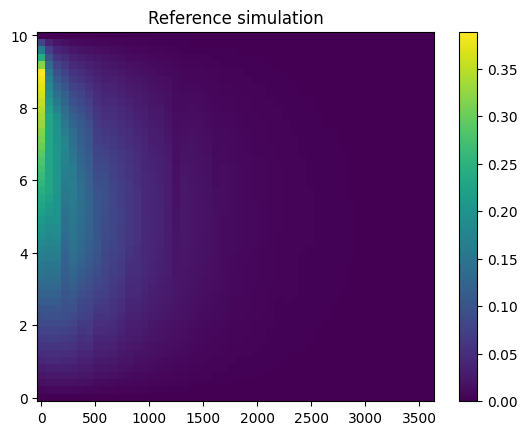

In [12]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.colorbar(graph1)
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_5.png')

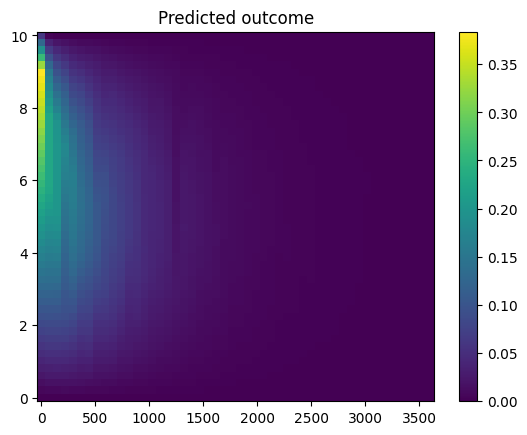

In [13]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.colorbar(graph2)
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_5.png')

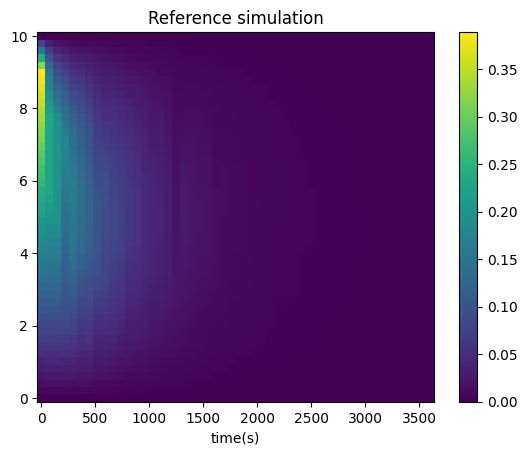

In [14]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.xlabel('time(s)')
plt.colorbar(graph1)
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_5.png')

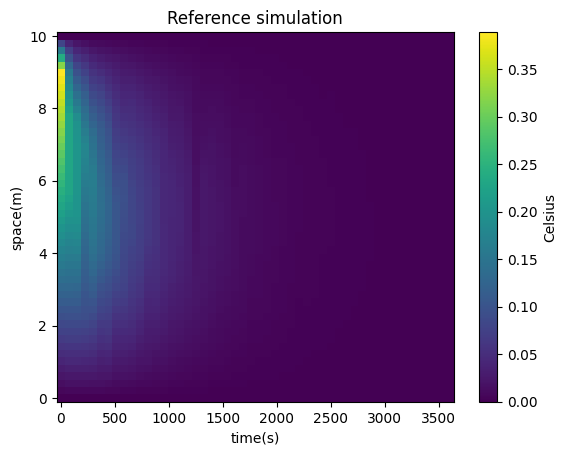

In [15]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph1)
colorbar.set_label('Celsius')
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_5.png')

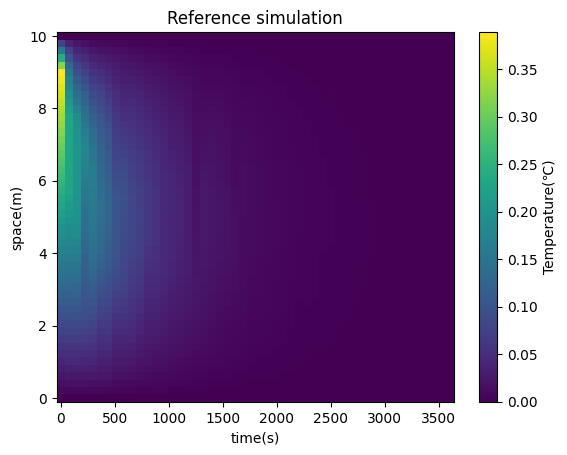

In [16]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph1)
colorbar.set_label('Temperature(℃)')
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_5.png')

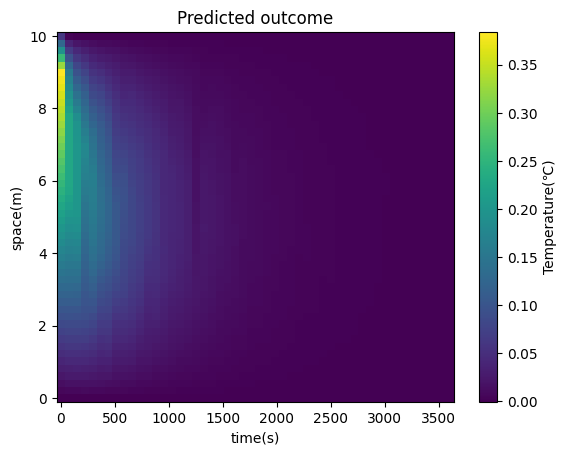

In [17]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph2)
colorbar.set_label('Temperature(℃)')
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_5.png')

In [18]:
y_predict_arr = y_pred[30].reshape(18921, 1)
y_true_arr = data_y[30].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [19]:
y_pred = model.predict(data_nonlinear.test_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[5].reshape(18921, 1)
y_true_arr = data_y[5].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [20]:
data = np.genfromtxt("test_heat_nonlinear_1h.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

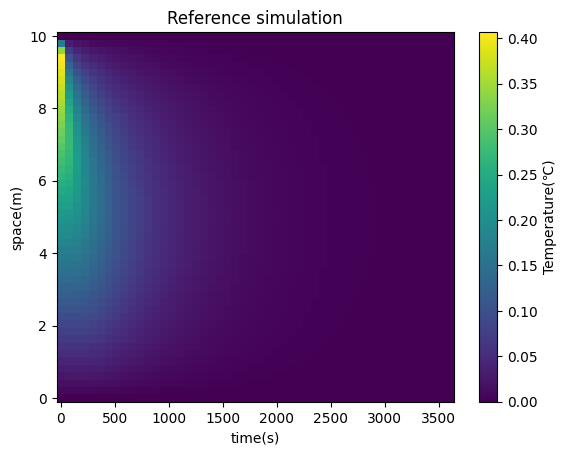

In [21]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph1)
colorbar.set_label('Temperature(℃)')
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_5.png')

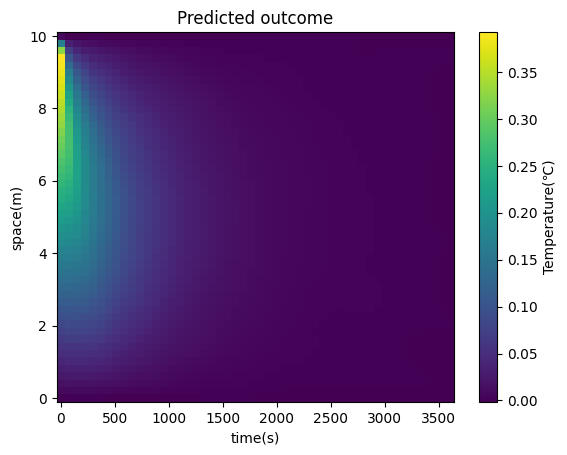

In [22]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph2)
colorbar.set_label('Temperature(℃)')
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_5.png')

In [23]:
y_pred = model.predict(data_nonlinear.test_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[30].reshape(18921, 1)
y_true_arr = data_y[30].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [24]:
data = np.genfromtxt("test_heat_nonlinear_1h.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

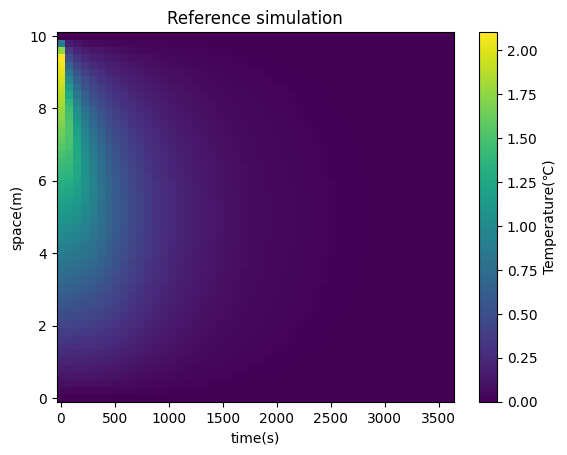

In [25]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph1)
colorbar.set_label('Temperature(℃)')
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_30.png')

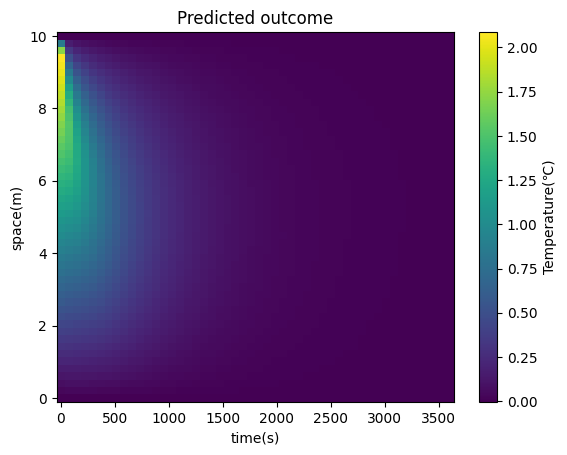

In [26]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph2)
colorbar.set_label('Temperature(℃)')
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_30.png')

In [27]:
y_pred = model.predict(data_nonlinear.test_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[60].reshape(18921, 1)
y_true_arr = data_y[60].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [28]:
data = np.genfromtxt("test_heat_nonlinear_1h.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

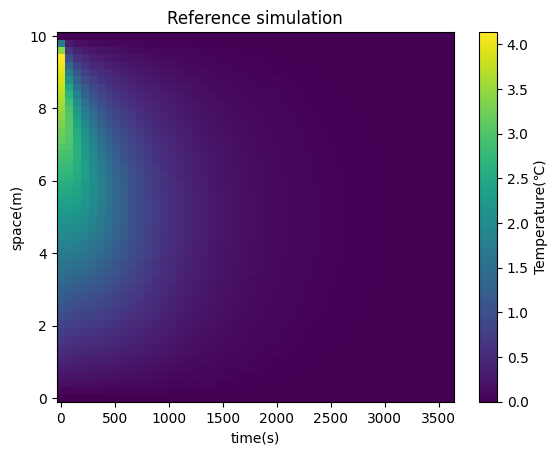

In [29]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph1)
colorbar.set_label('Temperature(℃)')
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_60.png')

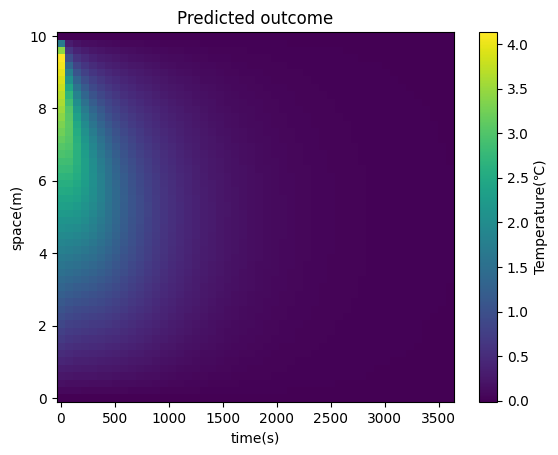

In [30]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph2)
colorbar.set_label('Temperature(℃)')
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_60.png')

In [31]:
y_pred = model.predict(data_nonlinear.test_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[90].reshape(18921, 1)
y_true_arr = data_y[90].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [32]:
data = np.genfromtxt("test_heat_nonlinear_1h.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

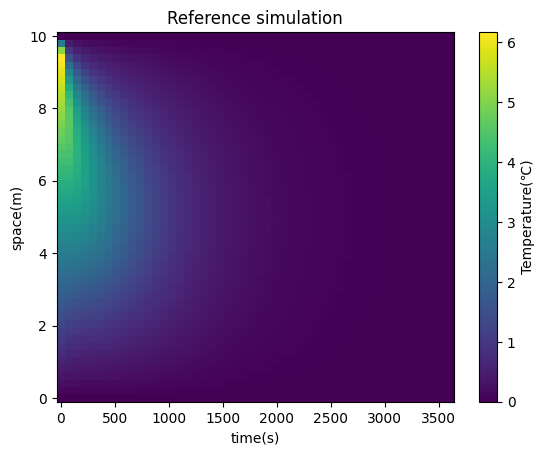

In [33]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph1)
colorbar.set_label('Temperature(℃)')
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_90.png')

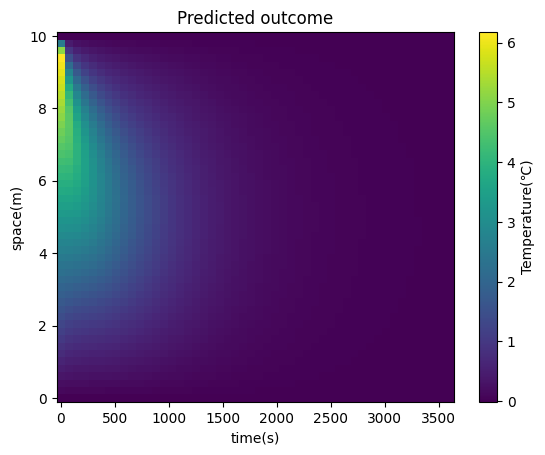

In [34]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph2)
colorbar.set_label('Temperature(℃)')
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_90.png')

In [35]:
def train_DeepONet(nx=4):
    x_train, y_train = get_data("heat_train_nonlinear_params.npz")
    x_test, y_test = get_data("heat_test_nonlinear_params.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512], [2, 512, 512, 512, 512], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=8000)]
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= callbacks)
    return model, data

In [36]:
model, data_nonlinear = train_DeepONet()

FileNotFoundError: [Errno 2] No such file or directory: 'heat_train_nonlinear_params.npz'

In [37]:
def train_DeepONet(nx=4):
    x_train, y_train = get_data("heat_train_nonlinear_1h_params.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1h_params.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512], [2, 512, 512, 512, 512], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=8000)]
    losshistory, train_state = model.train(epochs=50000, batch_size=None, callbacks= callbacks)
    return model, data

In [39]:
def train_DeepONet(nx=4):
    x_train, y_train = get_data("heat_train_nonlinear_1h_params.npz")
    x_test, y_test = get_data("heat_test_nonlinear_1h_params.npz")
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512], [2, 512, 512, 512, 512], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=8000)]
    losshistory, train_state = model.train(epochs=20000, batch_size=None, callbacks= callbacks)
    return model, data

In [40]:
model, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.002662 s

Training model...

0         [6.86e+02]    [6.84e+02]    [9.69e-01]    
1000      [1.51e-01]    [1.56e-01]    [1.14e-02]    
2000      [1.39e+01]    [1.42e+01]    [1.39e-01]    
3000      [6.27e-02]    [6.60e-02]    [7.76e-03]    
4000      [7.24e-02]    [7.71e-02]    [8.10e-03]    
5000      [1.24e-01]    [1.27e-01]    [1.06e-02]    
6000      [5.43e-02]    [5.89e-02]    [7.33e-03]    
7000      [1.04e+01]    [1.06e+01]    [1.20e-01]    
8000      [4.67e-02]    [5.20e-02]    [6.98e-03]    
9000      [4.12e-02]    [4.53e-02]    [6.44e-03]    
10000     [1.28e-01]    [1.26e-01]    [1.08e-02]    
11000     [1.13e-01]    [1.13e-01]    [1.18e-02]    
12000     [4.17e-02]    [4.56e-02]    [6.20e-03]    
13000     [3.60e-02]    [3.96e-02]    [5.73e-03]    
14000     [3.57e-02]    [3.99e-02]    [5.83e-03]    
15000     [3.48e-02]    [3.88e-02]    [5.65e-03]    
16000     [3.41e-02]    [3.82e-02]    [5.52e-03]    
17000     [3.40e-02]    [3.82e-02]

In [41]:
y_pred = model.predict(data_nonlinear.test_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h_params.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)

In [42]:
y_predict_arr = y_pred[5].reshape(18921, 1)
y_true_arr = data_y[5].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h_params.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [43]:
data = np.genfromtxt("test_heat_nonlinear_1h_params.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

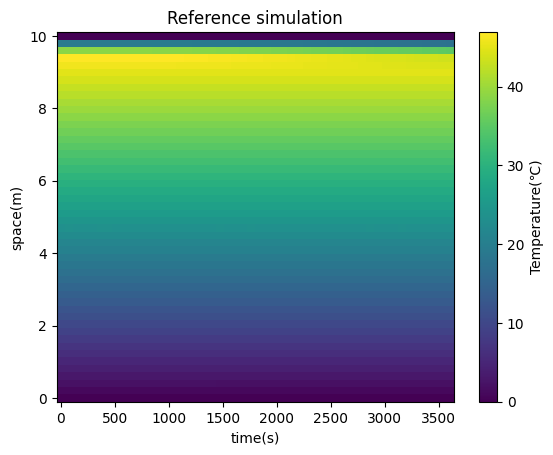

In [44]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph1)
colorbar.set_label('Temperature(℃)')
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_params_5.png')

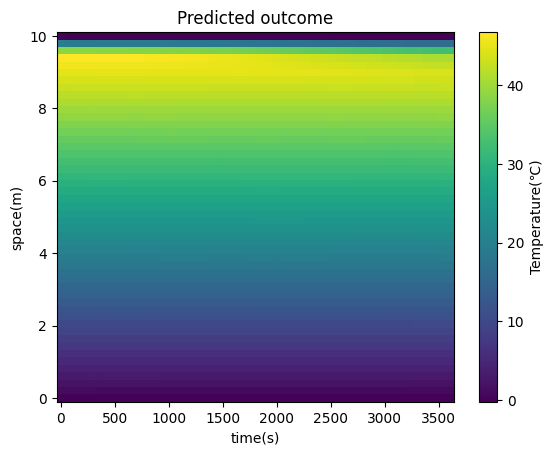

In [45]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph2)
colorbar.set_label('Temperature(℃)')
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_params_5.png')

In [46]:
y_pred = model.predict(data_nonlinear.test_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h_params.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[10].reshape(18921, 1)
y_true_arr = data_y[10].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h_params.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [47]:
data = np.genfromtxt("test_heat_nonlinear_1h_params.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

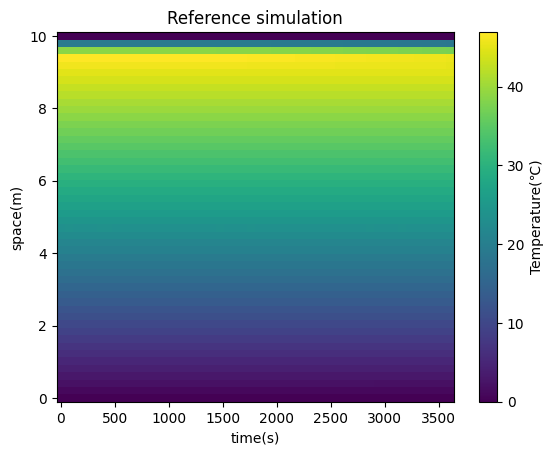

In [48]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph1)
colorbar.set_label('Temperature(℃)')
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_params_10.png')

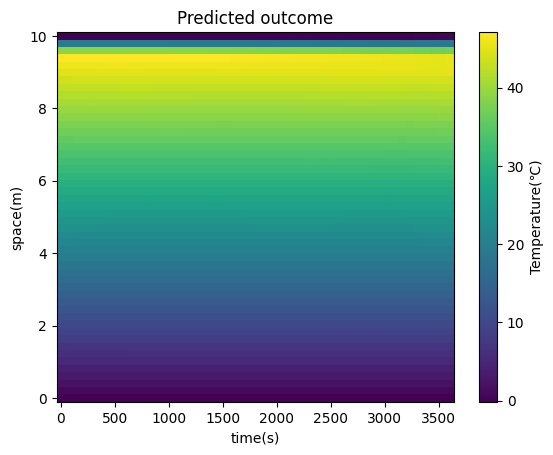

In [49]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph2)
colorbar.set_label('Temperature(℃)')
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_params_10.png')

In [50]:
y_pred = model.predict(data_nonlinear.test_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h_params.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[50].reshape(18921, 1)
y_true_arr = data_y[50].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h_params.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [51]:
y_pred = model.predict(data_nonlinear.test_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h_params.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[50].reshape(18921, 1)
y_true_arr = data_y[50].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h_params.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [52]:
data = np.genfromtxt("test_heat_nonlinear_1h_params.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)
#plotting  the refernce data

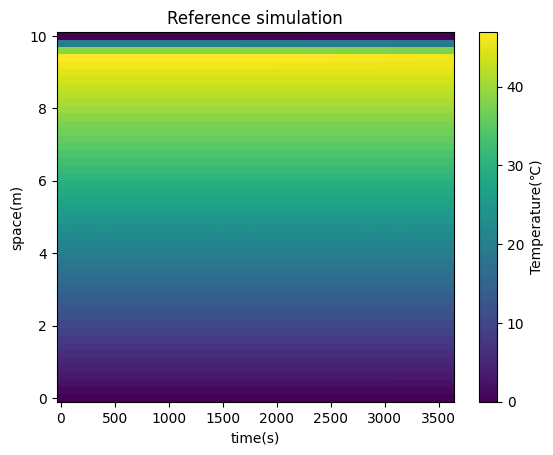

In [53]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph1)
colorbar.set_label('Temperature(℃)')
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_params_50.png')

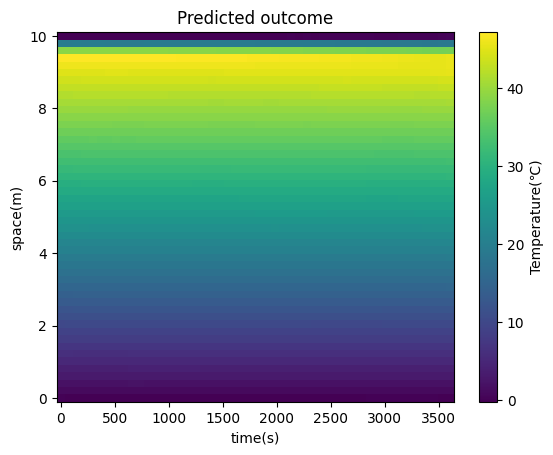

In [54]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph2)
colorbar.set_label('Temperature(℃)')
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_params_50.png')

In [55]:
def train_DeepONet(nx=4, train_data = "heat_train_nonlinear_1h_params.npz", test_data = "heat_test_nonlinear_1h_params.npz", num_epochs=50000):
    x_train, y_train = get_data(train_data)
    x_test, y_test = get_data(test_data)
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512], [2, 512, 512, 512, 512], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=8000)]
    losshistory, train_state = model.train(epochs=num_epochs, batch_size=None, callbacks= callbacks)
    return model, data

In [56]:
def train_DeepONet(nx=4, train_data = "heat_train_nonlinear_1h_params.npz", test_data = "heat_test_nonlinear_1h_params.npz", num_epochs=30000):
    x_train, y_train = get_data(train_data)
    x_test, y_test = get_data(test_data)
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512], [2, 512, 512, 512, 512], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=8000)]
    losshistory, train_state = model.train(epochs=num_epochs, batch_size=None, callbacks= callbacks)
    return model, data

In [58]:
def get_data(filename, time_span = 24*3600):
    data = np.load(filename)
    u0 = data["u0"].astype(np.float32)
    xt = data["xt"].astype(np.float32)
    num_xt = xt.shape[0]
    for n in range(num_xt):
        xt[n,0] = xt[n,0]/time_span
    u = data["u"].astype(np.float32) 
    return (u0, xt), u

In [59]:
def train_DeepONet(nx=4, train_data = "heat_train_nonlinear_1h_params.npz", test_data = "heat_test_nonlinear_1h_params.npz", num_epochs=30000, time_span = 24*3600):
    x_train, y_train = get_data(train_data, time_span)
    x_test, y_test = get_data(test_data, time_span)
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512], [2, 512, 512, 512, 512], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=8000)]
    losshistory, train_state = model.train(epochs=num_epochs, batch_size=None, callbacks= callbacks)
    return model, data

In [60]:
model, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.002346 s

Training model...

0         [5.32e+02]    [5.28e+02]    [9.67e-01]    
1000      [1.14e+00]    [1.16e+00]    [4.27e-02]    
2000      [8.19e-01]    [8.66e-01]    [3.54e-02]    
3000      [6.78e-01]    [6.66e-01]    [3.11e-02]    
4000      [6.55e-01]    [6.25e-01]    [2.96e-02]    
5000      [6.60e-01]    [6.31e-01]    [2.98e-02]    
6000      [1.63e+00]    [1.79e+00]    [5.35e-02]    
7000      [7.03e-01]    [6.76e-01]    [3.13e-02]    
8000      [9.51e-01]    [9.50e-01]    [3.93e-02]    
9000      [6.28e-01]    [5.83e-01]    [2.84e-02]    
10000     [8.32e-01]    [8.00e-01]    [3.59e-02]    
11000     [6.78e-01]    [6.34e-01]    [3.05e-02]    
12000     [6.40e-01]    [5.70e-01]    [2.75e-02]    
13000     [6.12e-01]    [5.59e-01]    [2.76e-02]    
14000     [6.13e-01]    [5.57e-01]    [2.75e-02]    
15000     [6.07e-01]    [5.52e-01]    [2.73e-02]    
16000     [6.05e-01]    [5.50e-01]    [2.71e-02]    
17000     [6.09e-01]    [5.55e-01]

In [61]:
y_pred = model.predict(data_nonlinear.test_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h_params.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)

In [62]:
y_predict_arr = y_pred[5].reshape(18921, 1)
y_true_arr = data_y[5].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h_params.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [63]:
data = np.genfromtxt("test_heat_nonlinear_1h_params.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

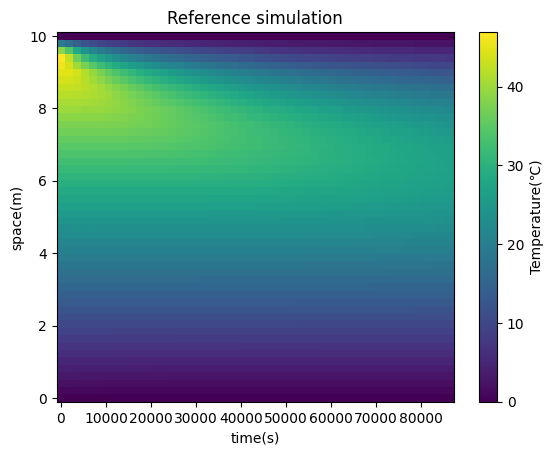

In [64]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph1)
colorbar.set_label('Temperature(℃)')
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_params_5.png')

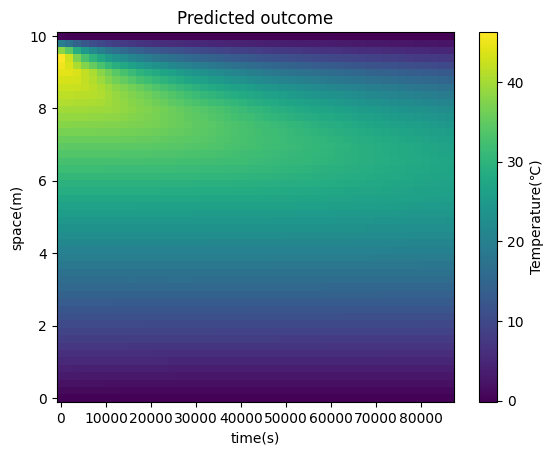

In [65]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph2)
colorbar.set_label('Temperature(℃)')
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_params_5.png')

In [66]:
y_pred = model.predict(data_nonlinear.test_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h_params.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[30].reshape(18921, 1)
y_true_arr = data_y[30].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h_params.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [67]:
data = np.genfromtxt("test_heat_nonlinear_1h_params.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

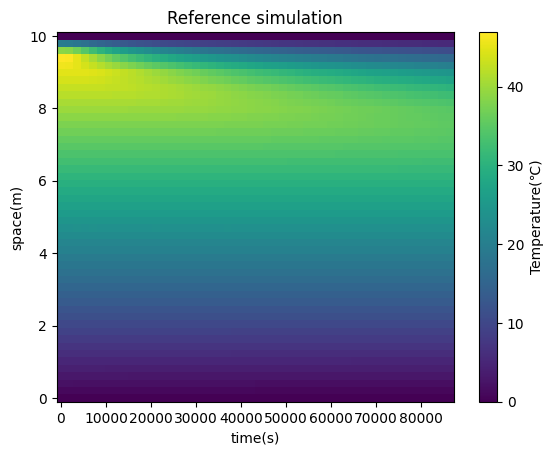

In [68]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph1)
colorbar.set_label('Temperature(℃)')
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_params_5.png')

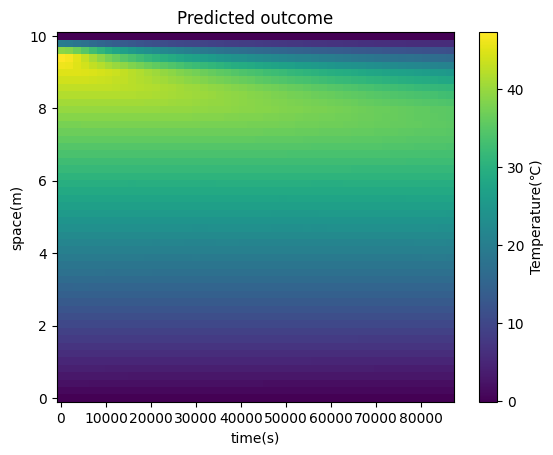

In [69]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph2)
colorbar.set_label('Temperature(℃)')
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_params_5.png')

In [70]:
y_pred = model.predict(data_nonlinear.test_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h_params.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[70].reshape(18921, 1)
y_true_arr = data_y[70].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h_params.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [71]:
data_x[0]

array([[0.71],
       [1.77],
       [1.29],
       [2.34],
       [1.15],
       [0.55],
       [1.04],
       [1.72],
       [1.18],
       [0.57],
       [1.8 ],
       [1.84],
       [0.66],
       [0.59],
       [1.35],
       [2.16],
       [1.88],
       [2.27],
       [1.43],
       [2.44],
       [2.07],
       [0.76],
       [2.44],
       [1.27],
       [1.45],
       [2.34],
       [1.15],
       [0.89],
       [2.09],
       [0.66],
       [1.78],
       [1.4 ],
       [1.57],
       [1.2 ],
       [0.81],
       [1.84],
       [1.38],
       [1.66],
       [0.68],
       [2.23],
       [2.11],
       [0.67],
       [1.09],
       [1.8 ],
       [2.36],
       [1.28],
       [2.11],
       [1.35],
       [1.54],
       [1.19],
       [1.16],
       [0.99],
       [1.73],
       [0.56],
       [2.17],
       [2.21],
       [2.18],
       [1.29],
       [0.87],
       [1.66],
       [1.95],
       [1.59],
       [1.97],
       [2.47],
       [0.76],
       [2.44],
       [1.

In [72]:
data_x.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [73]:
a = data_x[0]

In [74]:
a.shape

(100, 1)

In [75]:
a = data_x[1]

In [76]:
a

array([[ 0. ,  0. ],
       [ 0. ,  0.5],
       [ 0. ,  1. ],
       ...,
       [ 1. ,  9. ],
       [ 1. ,  9.5],
       [ 1. , 10. ]], dtype=float32)

In [77]:
a.shape

(18921, 2)

In [78]:
a = data_x[0]

In [79]:
a

array([[0.71],
       [1.77],
       [1.29],
       [2.34],
       [1.15],
       [0.55],
       [1.04],
       [1.72],
       [1.18],
       [0.57],
       [1.8 ],
       [1.84],
       [0.66],
       [0.59],
       [1.35],
       [2.16],
       [1.88],
       [2.27],
       [1.43],
       [2.44],
       [2.07],
       [0.76],
       [2.44],
       [1.27],
       [1.45],
       [2.34],
       [1.15],
       [0.89],
       [2.09],
       [0.66],
       [1.78],
       [1.4 ],
       [1.57],
       [1.2 ],
       [0.81],
       [1.84],
       [1.38],
       [1.66],
       [0.68],
       [2.23],
       [2.11],
       [0.67],
       [1.09],
       [1.8 ],
       [2.36],
       [1.28],
       [2.11],
       [1.35],
       [1.54],
       [1.19],
       [1.16],
       [0.99],
       [1.73],
       [0.56],
       [2.17],
       [2.21],
       [2.18],
       [1.29],
       [0.87],
       [1.66],
       [1.95],
       [1.59],
       [1.97],
       [2.47],
       [0.76],
       [2.44],
       [1.

In [80]:
a.shape

(100, 1)

In [81]:
u0_arr = data_unscaled["u0"].astype(np.float32)

In [82]:
u0_arr

array([[0.71],
       [1.77],
       [1.29],
       [2.34],
       [1.15],
       [0.55],
       [1.04],
       [1.72],
       [1.18],
       [0.57],
       [1.8 ],
       [1.84],
       [0.66],
       [0.59],
       [1.35],
       [2.16],
       [1.88],
       [2.27],
       [1.43],
       [2.44],
       [2.07],
       [0.76],
       [2.44],
       [1.27],
       [1.45],
       [2.34],
       [1.15],
       [0.89],
       [2.09],
       [0.66],
       [1.78],
       [1.4 ],
       [1.57],
       [1.2 ],
       [0.81],
       [1.84],
       [1.38],
       [1.66],
       [0.68],
       [2.23],
       [2.11],
       [0.67],
       [1.09],
       [1.8 ],
       [2.36],
       [1.28],
       [2.11],
       [1.35],
       [1.54],
       [1.19],
       [1.16],
       [0.99],
       [1.73],
       [0.56],
       [2.17],
       [2.21],
       [2.18],
       [1.29],
       [0.87],
       [1.66],
       [1.95],
       [1.59],
       [1.97],
       [2.47],
       [0.76],
       [2.44],
       [1.

In [83]:
new_p = [rand(0.5:0.01:2.50), rand(1.0:0.01:2.0), rand(1.0:0.01:2.0), rand(1.0:0.01:2.0)]

SyntaxError: invalid syntax (<ipython-input-83-4155b4e97678>, line 1)

In [84]:
def train_DeepONet(nx=4, train_data = "heat_train_nonlinear_1h_params.npz", test_data = "heat_test_nonlinear_1h_params.npz", num_epochs=30000, time_span = 24*3600):
    x_train, y_train = get_data(train_data, time_span)
    x_test, y_test = get_data(test_data, time_span)
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512], [2, 512, 512, 512, 512], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=8000)]
    losshistory, train_state = model.train(epochs=num_epochs, batch_size=None, callbacks= callbacks)
    return model, data

In [85]:
def get_data(filename, time_span = 24*3600):
    data = np.load(filename)
    u0 = data["u0"].astype(np.float32)
    xt = data["xt"].astype(np.float32)
    num_xt = xt.shape[0]
    for n in range(num_xt):
        xt[n,0] = xt[n,0]/time_span
    u = data["u"].astype(np.float32) 
    return (u0, xt), u

In [86]:
def train_DeepONet(nx=4, train_data = "heat_train_nonlinear_1h_params.npz", test_data = "heat_test_nonlinear_1h_params.npz", num_epochs=40000, time_span = 24*3600):
    x_train, y_train = get_data(train_data, time_span)
    x_test, y_test = get_data(test_data, time_span)
    data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
    net = dde.maps.DeepONetCartesianProd(
        [nx, 512, 512, 512], [2, 512, 512, 512, 512], "relu", "Glorot normal"
    )
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        decay=("inverse time", 1, 1e-4),
        metrics=["mean l2 relative error"],
    )
    callbacks = [dde.callbacks.EarlyStopping(monitor='loss_test', patience=8000)]
    losshistory, train_state = model.train(epochs=num_epochs, batch_size=None, callbacks= callbacks)
    return model, data

In [87]:
model, data_nonlinear = train_DeepONet()

Compiling model...
'compile' took 0.002202 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [4.83e+02]    [4.84e+02]    [9.22e-01]    
1000      [4.37e-01]    [4.60e-01]    [2.75e-02]    
2000      [1.53e-01]    [1.58e-01]    [1.58e-02]    
3000      [5.85e-02]    [6.50e-02]    [9.49e-03]    
4000      [2.46e-01]    [2.54e-01]    [2.07e-02]    
5000      [3.71e-02]    [4.25e-02]    [7.56e-03]    
6000      [1.47e+01]    [1.48e+01]    [1.61e-01]    
7000      [1.36e-01]    [1.47e-01]    [1.52e-02]    
8000      [6.09e-02]    [6.71e-02]    [9.55e-03]    
9000      [4.38e-02]    [4.91e-02]    [8.27e-03]    
10000     [2.94e-02]    [3.26e-02]    [6.52e-03]    
11000     [2.80e+00]    [2.82e+00]    [6.96e-02]    
12000     [1.37e-02]    [1.53e-02]    [4.53e-03]    
13000     [1.13e-02]    [1.28e-02]    [4.14e-03]    
14000     [1.59e-02]    [1.73e-02]    [4.89e-03]    
15000     [8.69e-03]    [1.01e-02]    [3.67e-03]    
16000     [9.31e-03]    [1.05e-02]

In [88]:
y_pred = model.predict(data_nonlinear.test_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h_params.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)

In [89]:
y_predict_arr = y_pred[5].reshape(18921, 1)
y_true_arr = data_y[5].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h_params.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [90]:
data = np.genfromtxt("test_heat_nonlinear_1h_params.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

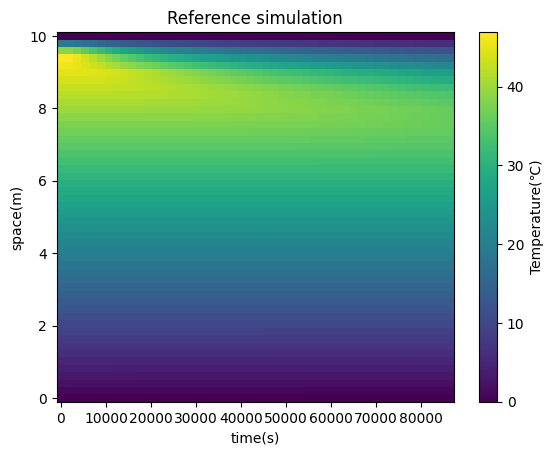

In [91]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph1)
colorbar.set_label('Temperature(℃)')
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_params_5.png')

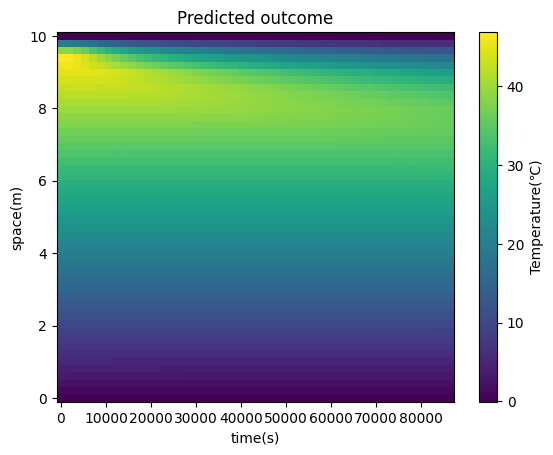

In [92]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph2)
colorbar.set_label('Temperature(℃)')
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_params_5.png')

In [93]:
data_x[0]

array([[1.25, 1.78, 1.38, 1.52],
       [0.63, 1.65, 1.79, 1.57],
       [1.35, 1.1 , 1.98, 1.04],
       [0.53, 1.95, 1.18, 1.74],
       [0.64, 1.24, 1.57, 1.59],
       [2.48, 1.88, 1.28, 1.03],
       [1.65, 1.9 , 1.48, 1.44],
       [1.57, 1.27, 1.43, 1.92],
       [2.12, 1.29, 1.29, 1.14],
       [1.65, 1.83, 1.13, 1.77],
       [1.49, 1.75, 1.61, 1.28],
       [2.18, 1.08, 1.81, 1.93],
       [2.34, 1.02, 1.04, 1.75],
       [2.4 , 1.13, 1.97, 1.07],
       [1.08, 1.31, 1.37, 1.24],
       [1.08, 1.53, 1.82, 1.37],
       [0.61, 1.53, 1.68, 1.68],
       [1.01, 1.02, 1.04, 1.6 ],
       [2.36, 1.26, 1.67, 1.17],
       [0.75, 1.52, 1.1 , 1.27],
       [2.2 , 1.96, 1.1 , 1.09],
       [1.62, 1.89, 1.96, 1.49],
       [2.12, 1.08, 1.16, 1.95],
       [1.18, 1.87, 1.59, 1.27],
       [2.15, 1.46, 1.95, 1.75],
       [1.9 , 1.52, 1.05, 1.48],
       [1.97, 1.51, 1.89, 1.2 ],
       [1.48, 1.57, 1.7 , 1.65],
       [1.48, 1.53, 1.95, 1.02],
       [1.05, 1.52, 1.47, 1.45],
       [2.

In [94]:
data_x[0][5]

array([2.48, 1.88, 1.28, 1.03], dtype=float32)

In [95]:
y_pred = model.predict(data_nonlinear.test_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h_params.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[30].reshape(18921, 1)
y_true_arr = data_y[30].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h_params.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [96]:
data = np.genfromtxt("test_heat_nonlinear_1h_params.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

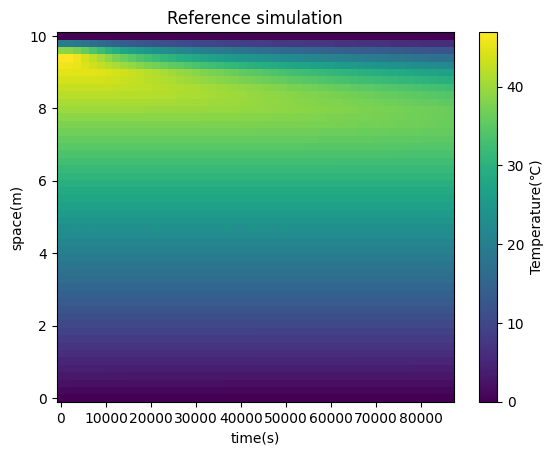

In [97]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph1)
colorbar.set_label('Temperature(℃)')
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_params_30.png')

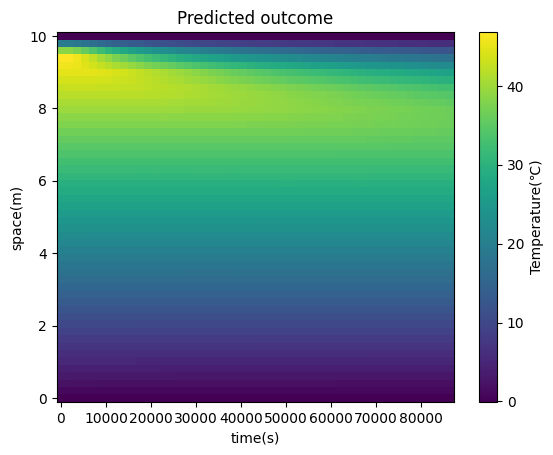

In [98]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph2)
colorbar.set_label('Temperature(℃)')
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_params_30.png')

In [99]:
data_x[0][30]

array([2.08, 1.51, 1.54, 1.87], dtype=float32)

In [100]:
y_pred = model.predict(data_nonlinear.test_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h_params.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[70].reshape(18921, 1)
y_true_arr = data_y[70].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h_params.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [101]:
data = np.genfromtxt("test_heat_nonlinear_1h_params.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

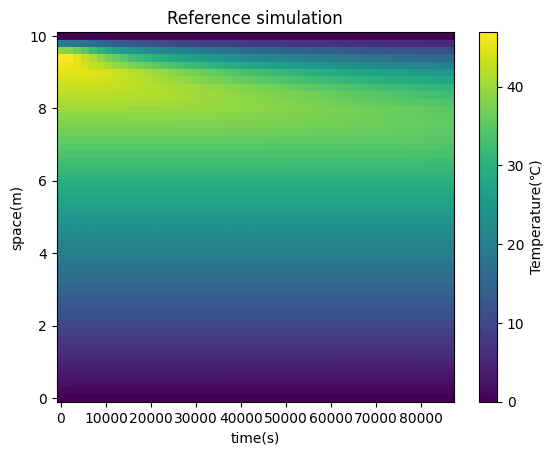

In [102]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph1)
colorbar.set_label('Temperature(℃)')
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_params_70.png')

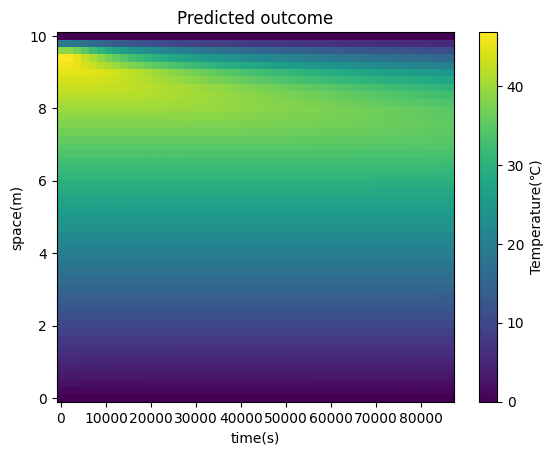

In [103]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph2)
colorbar.set_label('Temperature(℃)')
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_params_70.png')

In [104]:
data_x[0][70]

array([1.97, 1.7 , 1.51, 1.5 ], dtype=float32)

In [105]:
y_pred = model.predict(data_nonlinear.test_x)
data_x = data_nonlinear.test_x
data_y = data_nonlinear.test_y
#extract one case in the testing data and reoraginse the data structure for plotting

data_unscaled = np.load("heat_test_nonlinear_1h_params.npz")
xt_arr = data_unscaled["xt"].astype(np.float32)
y_predict_arr = y_pred[90].reshape(18921, 1)
y_true_arr = data_y[90].reshape(18921, 1)
np.savetxt("test_heat_nonlinear_1h_params.dat", np.hstack((xt_arr, y_true_arr, y_predict_arr)))

In [106]:
data = np.genfromtxt("test_heat_nonlinear_1h_params.dat", delimiter=' ')
#getting the refernce data

interp1 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,2])
#getting the predicted data

interp2 = LinearNDInterpolator(list(zip(data[:,0], data[:,1])), data[:,3])
x = data[:,0]
t = data[:,1]
X = np.linspace(min(x), max(x))
T = np.linspace(min(t), max(t))
X, T = np.meshgrid(X, T)

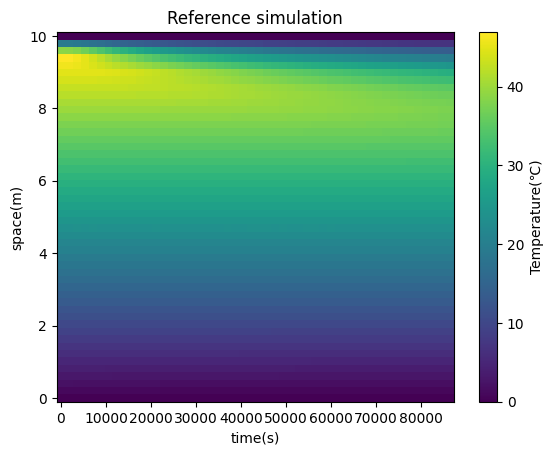

In [107]:
Z = interp1(X, T)
graph1 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph1)
colorbar.set_label('Temperature(℃)')
plt.title('Reference simulation')
plt.savefig('heat_reference_nonlinear_1h_params_90.png')

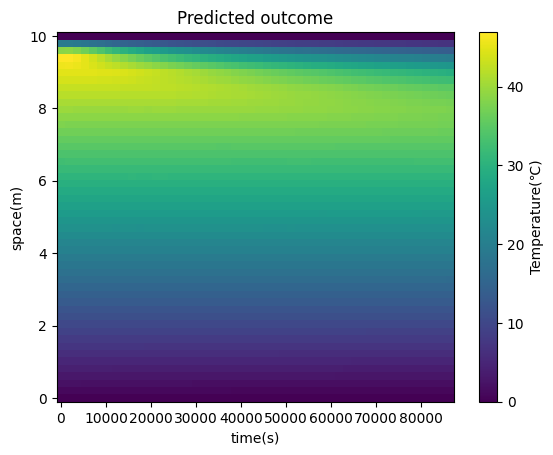

In [108]:
Z = interp2(X, T)
graph2 = plt.pcolormesh(X, T, Z)
plt.ylabel('space(m)')
plt.xlabel('time(s)')
colorbar = plt.colorbar(graph2)
colorbar.set_label('Temperature(℃)')
plt.title('Predicted outcome')
plt.savefig('heat_predict_nonlinear_1h_params_90.png')